# **SentimentArcs (Part 3): Lexical to Statistical GOFAI ML Models**

```
Jon Chun
12 Jun 2021: Started
04 Mar 2022: Last Update
```






# **[RESTART RUNTIME] May be Required**

In [1]:
# Make sure using a GPU

# Tesla V100 = (3.0 x) P100 (2 vCPUs)
#       P100 = (1.6 x) K80  (2 vCPUs/12GB RAM)
#       P100 ~ T4 
#       K80  = (     ) NVIDA GeForce RTX 3080 Ti
#
# High RAM Colab Pro  32GB RAM     $9.99/mo
#          Colab Pro+ 52GB        $49.95/mo

# Paperspace Free & Paid JupyterLab vs Google Colab
# https://blog.paperspace.com/alternative-to-google-colab-pro/#:~:text=Most%20notable%20is%20that%20the,and%2012%20GB%20of%20RAM.&text=Meanwhile%2C%20in%20Paperspace%20Gradient%2C%20GPU,a%20Free%20or%20Paid%20instance. 
# https://www.kaggle.com/general/198232
# https://towardsdatascience.com/deep-learning-on-a-budget-450-egpu-vs-google-colab-494f9a2ff0db (3080 vs Colab)
# https://towardsdatascience.com/when-to-use-cpus-vs-gpus-vs-tpus-in-a-kaggle-competition-9af708a8c3eb (Kaggle Comp)
# https://towardsdatascience.com/google-colab-pro-is-it-worth-49-99-c542770b8e56 (Colab Pro+)
# https://www.quora.com/Which-is-better-Google-Colab-or-Kaggle-Notebook (Kaggle vs Colab GPUs)

!nvidia-smi

Fri Mar  4 05:19:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [118]:
# [RESTART RUNTIME] May be Required

!pip install flair

     |████████████████████████████████| 322 kB 14.2 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2 MB 78.5 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 48 kB 7.5 MB/s 
     |████████████████████████████████| 981 kB 88.8 MB/s 
     |████████████████████████████████| 3.8 MB 45.5 MB/s 
     |████████████████████████████████| 19.7 MB 60.7 MB/s 
     |████████████████████████████████| 788 kB 78.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
     |████████████████████████████████| 895 kB 83.4 MB/s 
     |████████████████████████████████| 6.5 MB 77.5 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9692 sha256=389ffd2e4a8610616e9c3b01e240bdec3b82f11fc810

# **[STEP 1] Manual Configuration/Setup**



## (Popups) Connect Google gDrive

In [1]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


## (3 Inputs) Define Directory Tree

In [2]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



#@markdown **Sentiment Arcs Directory Structure** \
#@markdown \
#@markdown **1. Input Directories:** \
#@markdown (a) Raw textfiles in subdir: ./text_raw/(text_type)/  \
#@markdown (b) Cleaned textfiles in subdir: ./text_clean/(text_type)/ \
#@markdown \
#@markdown **2. Output Directories** \
#@markdown (1) Raw Sentiment time series datafiles and plots in subdir: ./sentiment_raw/(text_type) \
#@markdown (2) Cleaned Sentiment time series datafiles and plots in subdir: ./sentiment_clean/(text_type) \
#@markdown \
#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "novels" #@param ["novels", "social_media", "finance"]

Corpus_Type = "new" #@param ["new", "reference"]

#@markdown Please check that the required textfiles and datafiles exist in the correct subdirectories before continuing.


# **[STEP 2] Automatic Configuration/Setup**

In [3]:
# Define all Sub/Dir global CONSTANTS

import os

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_subdirs.py'

get_subdirs(Corpus_Genre, Corpus_Type, 'lex2ml')

Verify the Directory Structure:

-------------------------------

          [Corpus Genre]: novels

           [Corpus Type]: new


   [FNAME_SENTIMENT_RAW]: sentiment_raw_novels_new_lex2ml.json


       [SUBDIR_TEXT_RAW]: ./text_raw/novels_text_new_raw/

     [SUBDIR_TEXT_CLEAN]: ./text_clean/novels_text_new_clean/

  [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/novels_sentiment_new_raw/

[SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/novels_sentiment_new_clean/

          [SUBDIR_PLOTS]: ./plots/

           [SUBDIR_DATA]: ./data/

          [SUBDIR_UTILS]: ./utils/



## Configure Jupyter Notebook

In [4]:
# Configure Jupyter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read YAML Configuration for Corpus and Models 

In [5]:
!pip install pyyaml
import yaml

In [25]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/read_yaml.py'

read_yaml(Corpus_Genre, Corpus_Type)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = corpus_titles_dt.keys()
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

SentimentArcs Model Ensemble ------------------------------

AutoGluon_Text
BERT_2IMDB
BERT_Dual_Coding
BERT_Multilingual
BERT_Yelp
CNN_DNN
Distilled_BERT
FLAML_AutoML
Fully_Connected_Network
HyperOpt_CNN_Flair_AutoML
LSTM_DNN
Logistic_Regression
Logistic_Regression_CV
Multilingual_CNN_Stanza_AutoML
Multinomial_Naive_Bayes
Pattern
Random_Forest
RoBERTa_Large_15DB
RoBERTa_XML_8Language
SentimentR_JockersRinker
SentimentR_Jockers
SentimentR_Bing
SentimentR_NRC
SentimentR_SentiWord
SentimentR_SenticNet
SentimentR_LMcD
SentimentR_SentimentR
PySentimentR_JockersRinker
PySentimentR_Huliu
PySentimentR_NRC
PySentimentR_SentiWord
PySentimentR_SenticNet
PySentimentR_LMcD
SyuzhetR_AFINN
SyuzhetR_Bing
SyuzhetR_NRC
SyuzhetR_SyuzhetR
T5_IMDB
TextBlob
VADER
AFINN
XGBoost


Corpus Texts ------------------------------

scollins_thehungergames1
cmieville_thecityandthecity


There are 42 Models in the SentimentArcs Ensemble above.


There are 2 Texts in the Corpus above.





## Install Python Libraries

In [ ]:
# Intentionally left blank

2022-03-04 04:32:10,376 : INFO : NumExpr defaulting to 2 threads.


## Load Libraries

In [7]:
import numpy as np

from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
import json
from pathlib import Path

2022-03-04 05:52:28,812 : INFO : NumExpr defaulting to 4 threads.


In [8]:
"""
# Scikit Utilities, Metrics, Pipelines and Models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
""";

## Define Global Parameters

In [9]:
# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()


dict_keys(['$', '€', '4ao', 'a.m', 'a3', 'aamof', 'acct', 'adih', 'afaic', 'afaict', 'afaik', 'afair', 'afk', 'app', 'approx', 'apps', 'asap', 'asl', 'atk', 'ave.', 'aymm', 'ayor', 'b&b', 'b+b', 'b.c', 'b2b', 'b2c', 'b4', 'b4n', 'b@u', 'bae', 'bak', 'bbbg', 'bbc', 'bbias', 'bbl', 'bbs', 'be4', 'bfn', 'blvd', 'bout', 'brb', 'bros', 'brt', 'bsaaw', 'btw', 'bwl', 'c/o', 'cet', 'cf', 'cia', 'csl', 'cu', 'cul8r', 'cv', 'cwot', 'cya', 'cyt', 'dae', 'dbmib', 'diy', 'dm', 'dwh', 'e123', 'eet', 'eg', 'embm', 'encl', 'encl.', 'etc', 'faq', 'fawc', 'fb', 'fc', 'fig', 'fimh', 'ft.', 'ft', 'ftl', 'ftw', 'fwiw', 'fyi', 'g9', 'gahoy', 'gal', 'gcse', 'gfn', 'gg', 'gl', 'glhf', 'gmt', 'gmta', 'gn', 'g.o.a.t', 'goat', 'goi', 'gps', 'gr8', 'gratz', 'gyal', 'h&c', 'hp', 'hr', 'hrh', 'ht', 'ibrb', 'ic', 'icq', 'icymi', 'idc', 'idgadf', 'idgaf', 'idk', 'ie', 'i.e', 'ifyp', 'IG', 'iirc', 'ilu', 'ily', 'imho', 'imo', 'imu', 'iow', 'irl', 'j4f', 'jic', 'jk', 'jsyk', 'l8r', 'lb', 'lbs', 'ldr', 'lmao', 'lmfao', 

## Setup Matplotlib Style

In [10]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------\n')
plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')




 New figure size:  (20, 10)
Matplotlib Configuration ------------------------------



KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        


  Edit ./utils/config_matplotlib.py to change


## Setup Seaborn Style

In [11]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')




Seaborn Configuration ------------------------------



## **Utility Functions**

### Generate Convenient Data Lists

In [26]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
corpus_titles_dt
print('\n')

corpus_texts_ls = list(corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


Dictionary: corpus_titles_dt


{'cmieville_thecityandthecity': ['The City and The City by China Mieville',
  2009,
  0],
 'scollins_thehungergames1': ['The Hunger Games 1 by Suzanne Collins ',
  2008,
  0]}




Corpus Texts:
  scollins_thehungergames1
  cmieville_thecityandthecity



Natural Corpus Titles:
  The Hunger Games 1 by Suzanne Collins 
  The City and The City by China Mieville


In [27]:
# get_model_families()

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_model_families.py'

ensemble_models_dt = get_model_famalies(models_titles_dt)

print('\nTest: Lexicon Family of Models:')
ensemble_models_dt['lexicon']


There are 12 Lexicon Models
  Lexicon Model #0: sentimentr_sentimentr
  Lexicon Model #1: pysentimentr_jockersrinker
  Lexicon Model #2: pysentimentr_huliu
  Lexicon Model #3: pysentimentr_nrc
  Lexicon Model #4: pysentimentr_sentiword
  Lexicon Model #5: pysentimentr_senticnet
  Lexicon Model #6: pysentimentr_lmcd
  Lexicon Model #7: syuzhetr_afinn
  Lexicon Model #8: syuzhetr_bing
  Lexicon Model #9: syuzhetr_nrc
  Lexicon Model #10: syuzhetr_syuzhetr
  Lexicon Model #11: afinn

There are 9 Heuristic Models
  Heuristic Model #0: pattern
  Heuristic Model #1: sentimentr_jockersrinker
  Heuristic Model #2: sentimentr_jockers
  Heuristic Model #3: sentimentr_bing
  Heuristic Model #4: sentimentr_nrc
  Heuristic Model #5: sentimentr_sentiword
  Heuristic Model #6: sentimentr_senticnet
  Heuristic Model #7: sentimentr_lmcd
  Heuristic Model #8: vader

There are 8 Traditional ML Models
  Traditional ML Model #0: autogluon
  Traditional ML Model #1: flaml
  Traditional ML Model #2: logreg


['sentimentr_sentimentr',
 'pysentimentr_jockersrinker',
 'pysentimentr_huliu',
 'pysentimentr_nrc',
 'pysentimentr_sentiword',
 'pysentimentr_senticnet',
 'pysentimentr_lmcd',
 'syuzhetr_afinn',
 'syuzhetr_bing',
 'syuzhetr_nrc',
 'syuzhetr_syuzhetr',
 'afinn']

### File Functions

In [28]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read Clean Corpus Texts and any Existing Raw Sentiment Data**

In [29]:
print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

# Verify in SentimentArcs Root Directory and cd into ./utils for R programs
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (texts_clean_ls) of all preprocessed text files
  try:
    texts_clean_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    texts_clean_ls = [x.split('/')[-1] for x in texts_clean_ls]
    texts_clean_ls = [x.split('.')[0] for x in texts_clean_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(texts_clean_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(texts_clean_ls))
  print('\n')
  print(f'Found {len(texts_clean_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING  Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The  Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

Trying to find EXISTING Raw Sentiment Datafile:
  [sentiment_raw_novels_new_lex2ml.json]
  in Raw Sentiment Subdir: ./sentiment_raw/novels_sentiment_new_raw/

Found EXISTING  Raw Sentiment Datafile exists, Loading...

The  Models have Analyzed these Texts in the Corpus:

  dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   afinn                       10125 non-null  float64
 1   flair                       10125 non-null  float64
 2   pattern                     10125 non-null  float64
 3   pysentimentr_huliu          10125 non-null  float64
 4   pysentimentr_jockersrinker  10125 non-null  float64
 5   pysentimentr_lmcd           10125 non-null  float64
 6   pysentimentr_nrc            10125 non-null  float64
 7   pysentimentr_senticnet    

In [31]:
models_ls = list(set(corpus_texts_dt[corpus_titles_ls[0]].columns) - set(['text_clean','text_raw']))
print(f'There are [{len(models_ls)} Models] Pre-Existing in the Datafile for this Notebook:\n')
models_ls
print('\n')

print(f'There are [{len(corpus_titles_ls)} Texts] in the current Corpus:\n')
corpus_titles_ls

There are [12 Models] Pre-Existing in the Datafile for this Notebook:



['flair',
 'pysentimentr_sentiword',
 'pysentimentr_huliu',
 'pysentimentr_senticnet',
 'pysentimentr_nrc',
 'stanza',
 'afinn',
 'textblob',
 'pysentimentr_lmcd',
 'vader',
 'pysentimentr_jockersrinker',
 'pattern']



There are [2 Texts] in the current Corpus:



['cmieville_thecityandthecity', 'scollins_thehungergames1']

## Verify Previous Sentiment Values Just Read In with Plots

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

r_scaler = RobustScaler() 
z_scaler = StandardScaler()

Title #0: cmieville_thecityandthecity


Title #1: scollins_thehungergames1


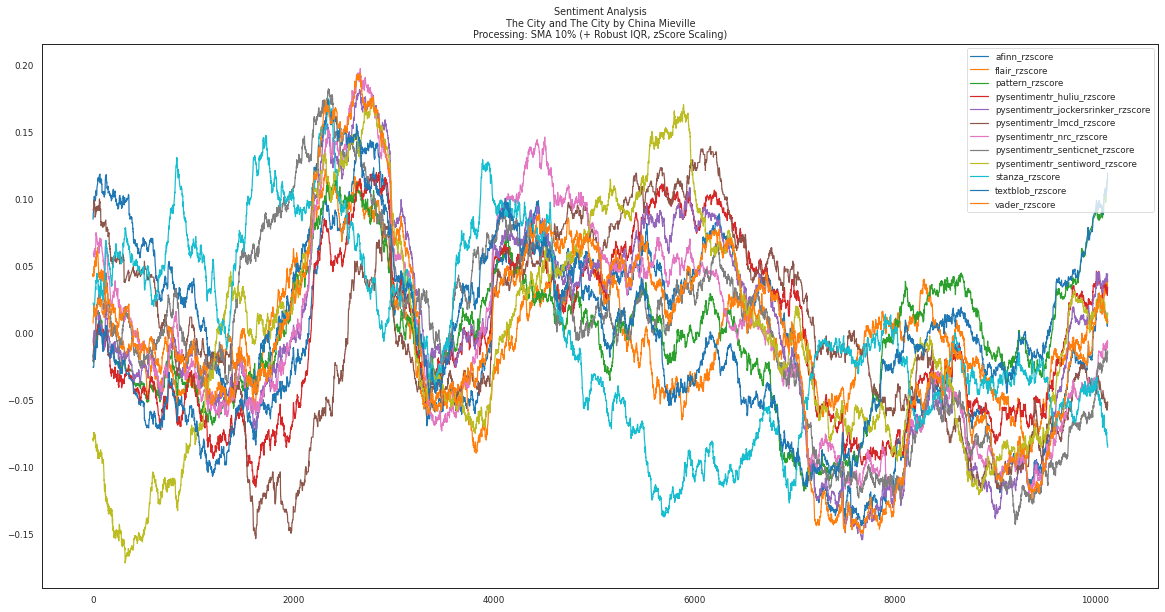

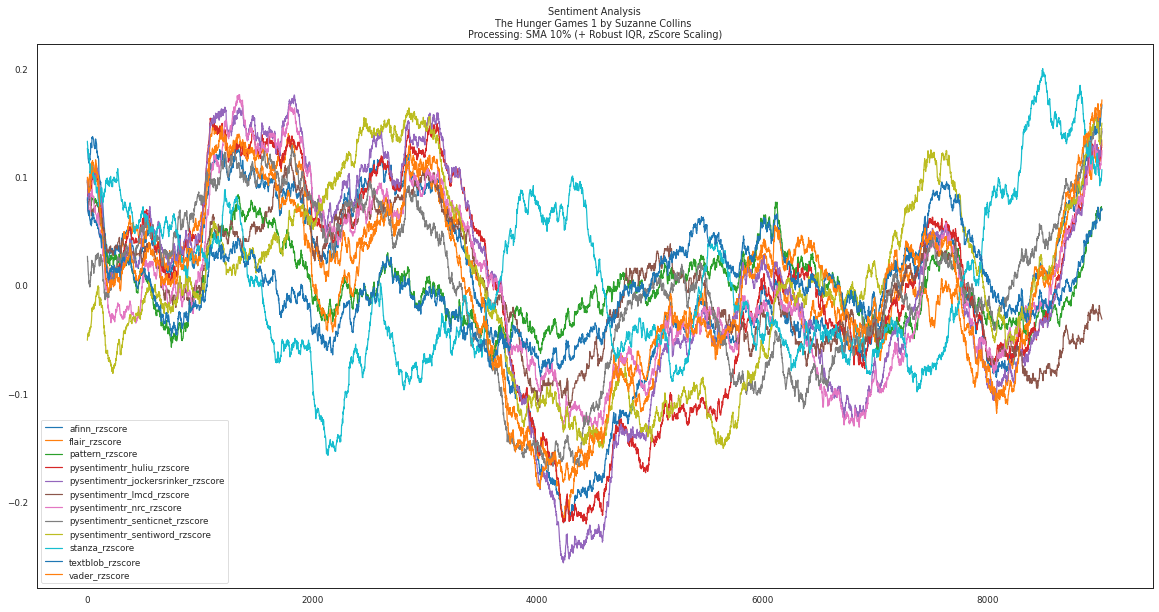

In [33]:
# Plot Sentiment Time Series for all Models in this Notebook run so far

for i, atitle in enumerate(corpus_titles_ls):
  col_rzscores_ls = []
  print(f"Title #{i}: {atitle}")
  df = corpus_texts_dt[atitle].copy()
  numeric_cols_ls = df.select_dtypes(include=[np.number]).columns
  for anum_col_str in numeric_cols_ls:
    anum_col_robust_np = r_scaler.fit_transform(df[anum_col_str].values.reshape(-1, 1) )
    anum_col_rzscore_np = z_scaler.fit_transform(anum_col_robust_np)
    anum_col_rzscore_str = f'{anum_col_str}_rzscore'
    df[anum_col_rzscore_str] = pd.Series(anum_col_rzscore_np.squeeze(-1,))
    col_rzscores_ls.append(anum_col_rzscore_str)


  win_10per = int(0.10 * df.shape[0])
  df[col_rzscores_ls].rolling(win_10per, center=True, min_periods=0).mean().plot(title=f"Sentiment Analysis\n{corpus_titles_dt[atitle][0]}\nProcessing: SMA 10% (+ Robust IQR, zScore Scaling)")

# **[STEP 4] Get Sentiments**

## **Lexicons**

In [53]:
# PyReadR enables Python to read R datafiles (e.g. *.rda)

!pip install pyreadr
import pyreadr

     |████████████████████████████████| 361 kB 14.4 MB/s 


In [63]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'lexicon'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = True #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family] if 'pysentimentr_' in x] + ['afinn']
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

Lexicon Models in this Section:

['pysentimentr_jockersrinker', 'pysentimentr_huliu', 'pysentimentr_nrc', 'pysentimentr_sentiword', 'pysentimentr_senticnet', 'pysentimentr_lmcd', 'afinn']


### **Jockers-Rinker**

In [54]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_jockersrinker'
model_type = 'Lexicon'

url = f"https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_{lexicon_name}.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, atest_word in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(atest_word.lower()) is None):
    # print(f'ERROR: {atest_word} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {atest_word} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(atest_word.lower())
    print(f'[{word_sentiment_fl: ^8}]: {atest_word}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, atest_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(atest_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {atest_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11710 entries, 0 to 11709
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       11710 non-null  object 
 1   y       11710 non-null  float64
dtypes: float64(1), object(1)
memory usage: 183.1+ KB


Testing jockers_rinker lexicon for WORDS Sentiment
--------------------------------------------------
[  0.75  ]: Love

[ -0.75  ]: Hate

[ -0.75  ]: bizarre

[  -0.5  ]: strange

[  -1.0  ]: furious

[  1.0   ]: elated

[  0.4   ]: curious

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing jockers_rinker lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -3.25  ]: I hate bad evil worthless Mondays.

[  0.75  ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[ -2.25  ]: You are a disgusting pig - I hate you.

[  3.3   ]: What a delightfully funny and beautiful good man.

[   0    ]: That was it



In [65]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_jockersrinker] Sentiment Recompute and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_jockersrinker] Sentiment Recompute and Value Updated


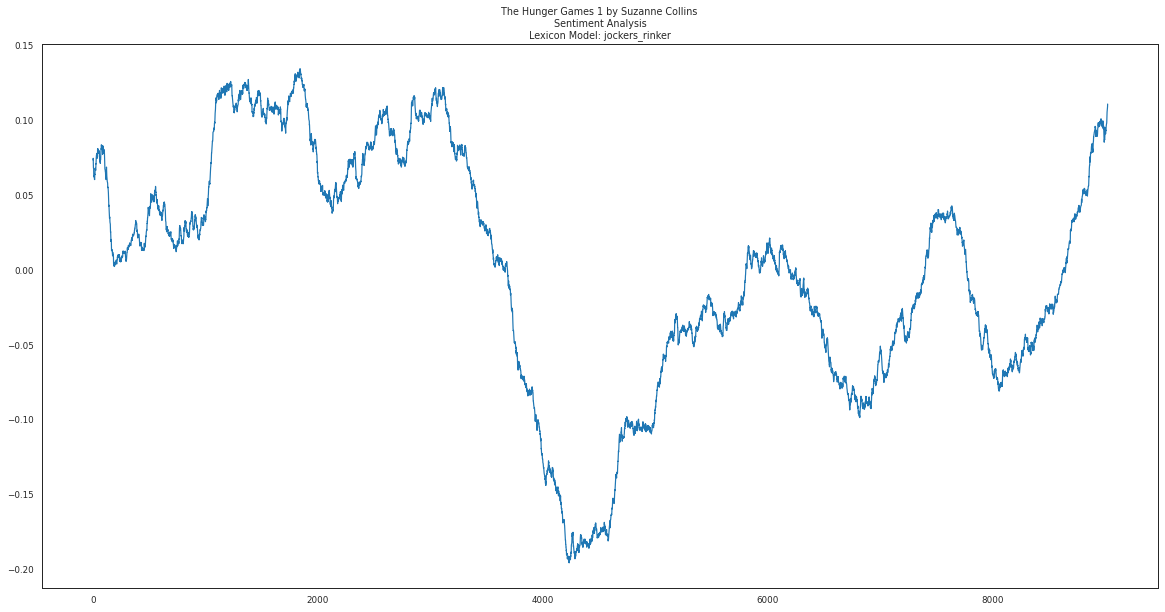

In [69]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **HuLiu (aka Bing)**

In [70]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'huliu'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_huliu'
model_type = 'Lexicon'

url = "https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_huliu.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, atest_word in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(atest_word.lower()) is None):
    # print(f'ERROR: {atest_word} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {atest_word} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(atest_word.lower())
    print(f'[{word_sentiment_fl: ^8}]: {atest_word}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, atest_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(atest_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {atest_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       6874 non-null   object 
 1   y       6874 non-null   float64
dtypes: float64(1), object(1)
memory usage: 107.5+ KB


Testing huliu lexicon for WORDS Sentiment
--------------------------------------------------
[  1.0   ]: Love

[  -1.0  ]: Hate

[  -1.0  ]: bizarre

[  -1.0  ]: strange

[  -1.0  ]: furious

[  1.0   ]: elated

[ ERROR  ]: curious [NOT IN LEXICON]

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing huliu lexicon for SENTENCES Sentiment
--------------------------------------------------
[  -4.0  ]: I hate bad evil worthless Mondays.

[  1.0   ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[  -3.0  ]: You are a disgusting pig - I hate you.

[  4.0   ]: What a delightfully funny and beautiful good man.

[   0    ]: That was it



In [75]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_huliu] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_huliu] Sentiment Recomputed and Value Updated


In [ ]:
corpus_texts_dt[corpus_titles_ls[0]].head()

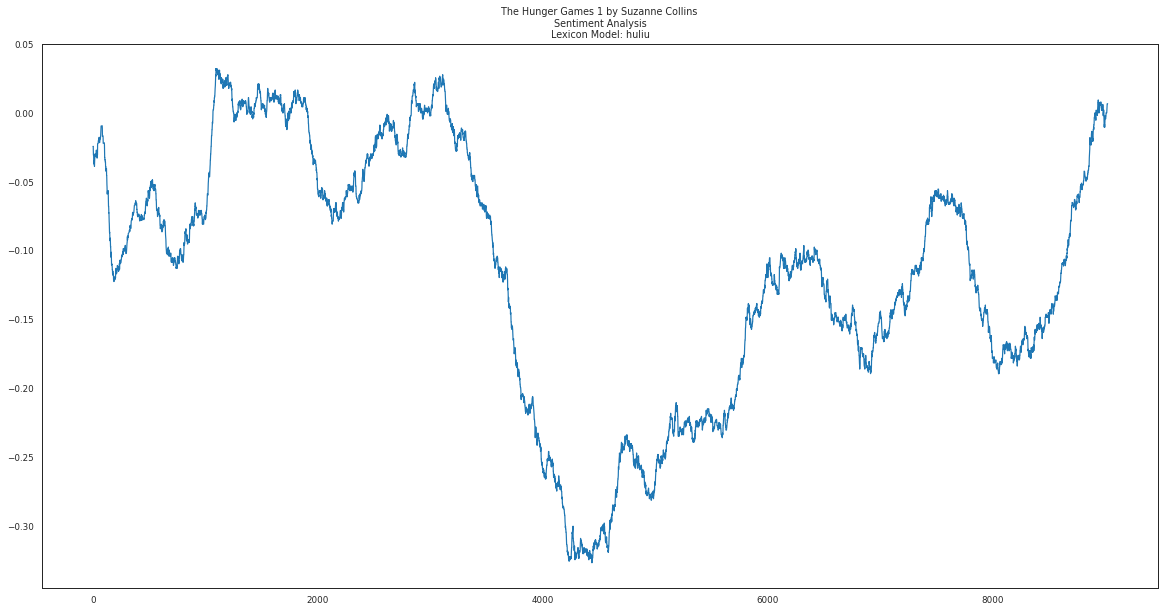

In [76]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **NRC**

In [77]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'nrc'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_nrc'
model_type = 'Lexicon'

url = "https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_nrc.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, atest_word in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(atest_word.lower()) is None):
    # print(f'ERROR: {atest_word} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {atest_word} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(atest_word.lower())
    print(f'[{word_sentiment_fl: ^8}]: {atest_word}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, atest_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(atest_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {atest_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5468 entries, 0 to 5467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       5468 non-null   object
 1   y       5468 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 64.2+ KB


Testing nrc lexicon for WORDS Sentiment
--------------------------------------------------
[   1    ]: Love

[   -1   ]: Hate

[   -1   ]: bizarre

[ ERROR  ]: strange [NOT IN LEXICON]

[   -1   ]: furious

[   1    ]: elated

[ ERROR  ]: curious [NOT IN LEXICON]

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing nrc lexicon for SENTENCES Sentiment
--------------------------------------------------
[  -4.0  ]: I hate bad evil worthless Mondays.

[  1.0   ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[  -3.0  ]: You are a disgusting pig - I hate you.

[  2.0   ]: What a delightfully funny and beautiful good man.

[   0    ]: That was it

In [78]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_nrc] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_nrc] Sentiment Recomputed and Value Updated


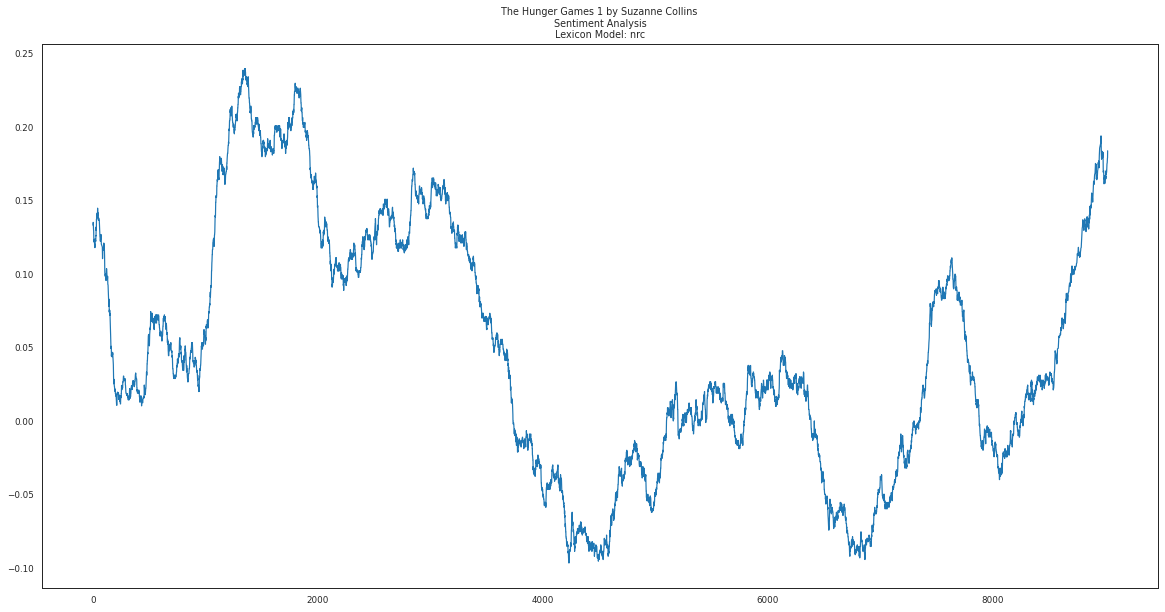

In [79]:
# Plot New Lexicon Values

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **SentiWord**


In [80]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'sentiword'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_sentiword'
model_type = 'Lexicon'

url = "https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_sentiword.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(aword_str.lower()) is None):
    # print(f'ERROR: {aword_str} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {aword_str} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(aword_str.lower())
    print(f'[{word_sentiment_fl: ^8}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(asent_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {asent_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20093 entries, 0 to 20092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       20093 non-null  object 
 1   y       20093 non-null  float64
dtypes: float64(1), object(1)
memory usage: 314.1+ KB


Testing sentiword lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.375  ]: Love

[ -0.25  ]: Hate

[ ERROR  ]: bizarre [NOT IN LEXICON]

[ ERROR  ]: strange [NOT IN LEXICON]

[ -0.125 ]: furious

[ ERROR  ]: elated [NOT IN LEXICON]

[ ERROR  ]: curious [NOT IN LEXICON]

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing sentiword lexicon for SENTENCES Sentiment
--------------------------------------------------
[-1.1428571428571428]: I hate bad evil worthless Mondays.

[ 0.375  ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[ -0.375 ]: You are a disgusting pig - I hate you.

[1.09375 ]: What a d

In [81]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_sentiword] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_sentiword] Sentiment Recomputed and Value Updated


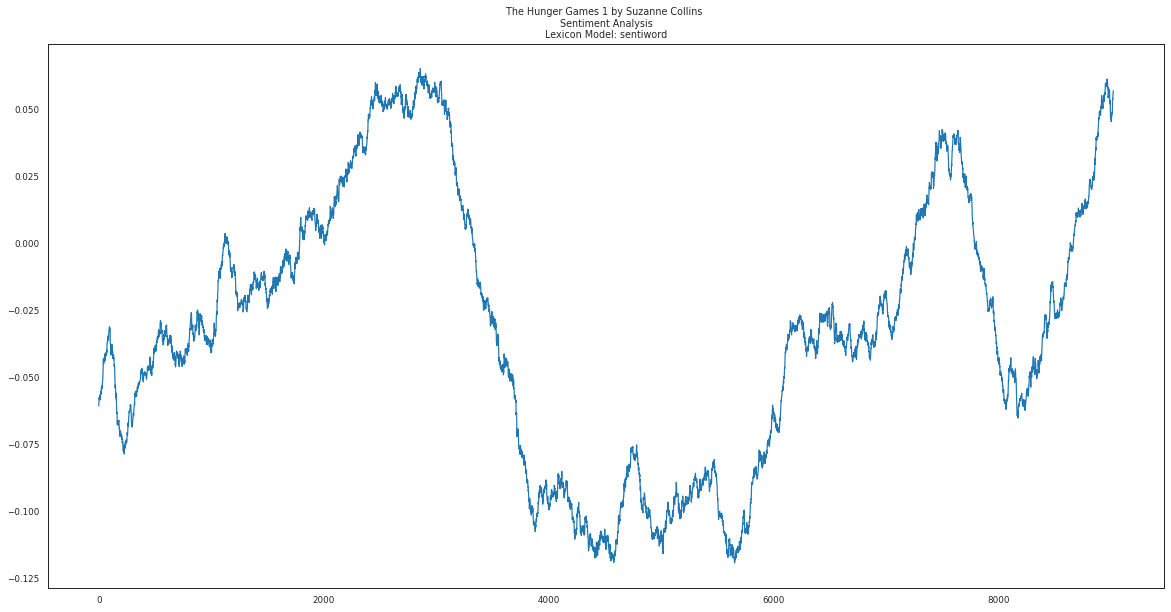

In [82]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **SenticNet**

In [83]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'senticnet'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_senticnet'
model_type = 'Lexicon'

url = "https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_senticnet.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, atest_word in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(atest_word.lower()) is None):
    # print(f'ERROR: {atest_word} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {atest_word} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(atest_word.lower())
    print(f'[{word_sentiment_fl: ^8}]: {atest_word}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, atest_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(atest_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {atest_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23626 entries, 0 to 23625
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       23626 non-null  object 
 1   y       23626 non-null  float64
dtypes: float64(1), object(1)
memory usage: 369.3+ KB


Testing senticnet lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.655  ]: Love

[ -0.83  ]: Hate

[ 0.569  ]: bizarre

[ -0.26  ]: strange

[ -0.41  ]: furious

[ 0.441  ]: elated

[ 0.314  ]: curious

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing senticnet lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -2.36  ]: I hate bad evil worthless Mondays.

[ 0.655  ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[ -1.24  ]: You are a disgusting pig - I hate you.

[1.8210000000000002]: What a delightfully funny and beautiful good man.

[   0    ]: That was it



In [84]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_senticnet] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_senticnet] Sentiment Recomputed and Value Updated


In [ ]:
# Plot New Lexicon Values

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Loughran-McDonald**

In [86]:
# Get Lexicon from SentimentR github repo

lexicon_name = 'loughran_mcdonald'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pysentimentr_lmcd'
model_type = 'Lexicon'

url = "https://github.com/trinker/lexicon/blob/master/data/hash_sentiment_loughran_mcdonald.rda?raw=true"
dst_path = f"{lexicon_dense}.rda"
dst_path_again = pyreadr.download_file(url, dst_path)
res = pyreadr.read_r(dst_path)
# print(f'type(res): {type(res)}\n')
# res

# Convert to DataFrame
lexicon_df = res[f'hash_sentiment_{lexicon_name}']
# lexicon_df.head()
lexicon_df.info()
print('\n')

# Reshape into Dictionary[word] = sentiment
lexicon_df.set_index('x', inplace=True)
lexicons_dt[lexicon_name] = lexicon_df.to_dict()['y']

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, atest_word in enumerate(test_words_ls):

  if (lexicons_dt[lexicon_name].get(atest_word.lower()) is None):
    # print(f'ERROR: {atest_word} not found in lexicon')
    word_sentiment_fl = 'ERROR'
    print(f'[{word_sentiment_fl: ^8}]: {atest_word} [NOT IN LEXICON]\n')
    continue
  else:
    word_sentiment_fl = lexicons_dt[lexicon_name].get(atest_word.lower())
    print(f'[{word_sentiment_fl: ^8}]: {atest_word}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, atest_str in enumerate(test_sentences_ls):

  str_sentiment_fl = get_lexsent_sentiment(atest_str, lexicons_dt[lexicon_name])
  print(f'[{str_sentiment_fl: ^8}]: {atest_str}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702 entries, 0 to 2701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       2702 non-null   object 
 1   y       2702 non-null   float64
dtypes: float64(1), object(1)
memory usage: 42.3+ KB


Testing loughran_mcdonald lexicon for WORDS Sentiment
--------------------------------------------------
[ ERROR  ]: Love [NOT IN LEXICON]

[ ERROR  ]: Hate [NOT IN LEXICON]

[ ERROR  ]: bizarre [NOT IN LEXICON]

[ ERROR  ]: strange [NOT IN LEXICON]

[ ERROR  ]: furious [NOT IN LEXICON]

[ ERROR  ]: elated [NOT IN LEXICON]

[ ERROR  ]: curious [NOT IN LEXICON]

[ ERROR  ]: beserk [NOT IN LEXICON]

[ ERROR  ]: gambaro [NOT IN LEXICON]


Testing loughran_mcdonald lexicon for SENTENCES Sentiment
--------------------------------------------------
[  -2.0  ]: I hate bad evil worthless Mondays.

[   0    ]: I love Paris in the springtime

[   0    ]: It was Wednesday.

[   0    ]: You are

In [87]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: get_lexsent_sentiment(x, lexicons_dt[lexicon_name]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pysentimentr_lmcd] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pysentimentr_lmcd] Sentiment Recomputed and Value Updated


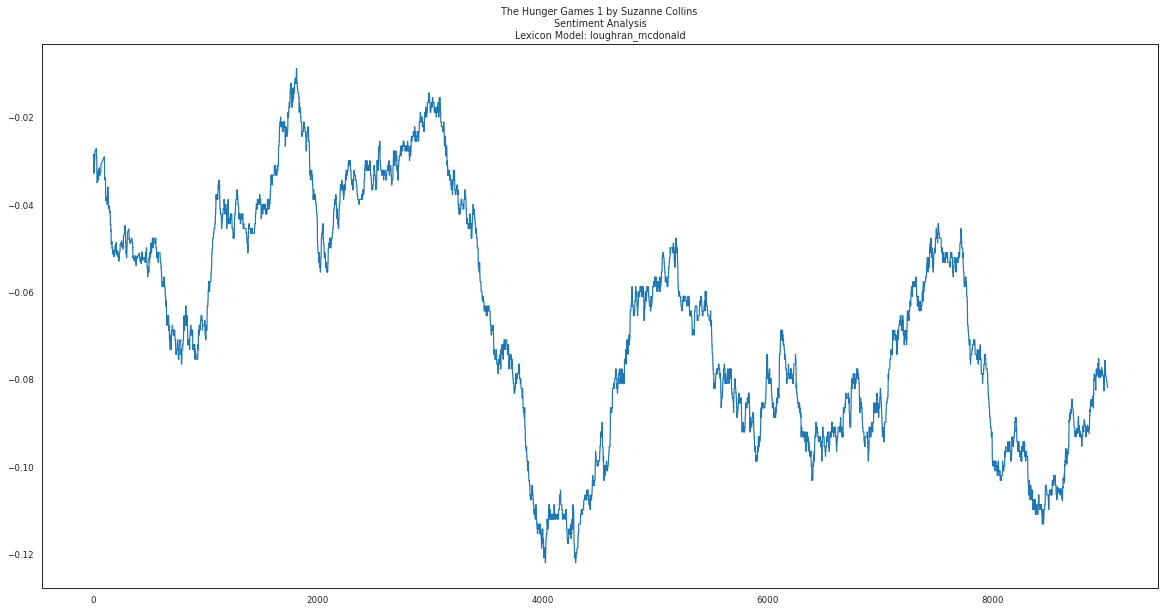

In [89]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **(FUTURE) MPQA**

* https://mpqa.cs.pitt.edu/

In [ ]:
# !wget https://mpqa.cs.pitt.edu/corpora/mpqa_corpus/mpqa_corpus_3_0

In [ ]:
# !ls -altr
# !head -n 10 mpqa_corpus_3_0

### **(FUTURE) LIWC**

* https://github.com/search?q=LIWC
* https://github.com/search?q=LIWC

### **AFINN**

In [90]:
!pip install afinn

     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=47171c724181017cd146078c2d5f043289095e81395141072ad907fb1ed78d03
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [93]:
from afinn import Afinn
afinn = Afinn(language='en')

lexicon_name = 'AFINN'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'afinn'
model_type = 'Lexicon'

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = afinn.score(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  words_ls = asent_str.split()
  sent_sentiment_fl = 0.0

  for j, atest_word in enumerate(words_ls):
    sent_sentiment_fl += afinn.score(atest_word.lower())

  print(f'[{sent_sentiment_fl: ^8}]: {asent_str}\n')

Testing AFINN lexicon for WORDS Sentiment
--------------------------------------------------
[  3.0   ]: Love

[  -3.0  ]: Hate

[  -2.0  ]: bizarre

[  -1.0  ]: strange

[  -3.0  ]: furious

[  3.0   ]: elated

[  1.0   ]: curious

[  0.0   ]: beserk

[  0.0   ]: gambaro


Testing AFINN lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -11.0  ]: I hate bad evil worthless Mondays.

[  3.0   ]: I love Paris in the springtime

[  0.0   ]: It was Wednesday.

[  -6.0  ]: You are a disgusting pig - I hate you.

[  13.0  ]: What a delightfully funny and beautiful good man.

[  0.0   ]: That was it



In [94]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: afinn.score(str(x).lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [afinn] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [afinn] Sentiment Recomputed and Value Updated


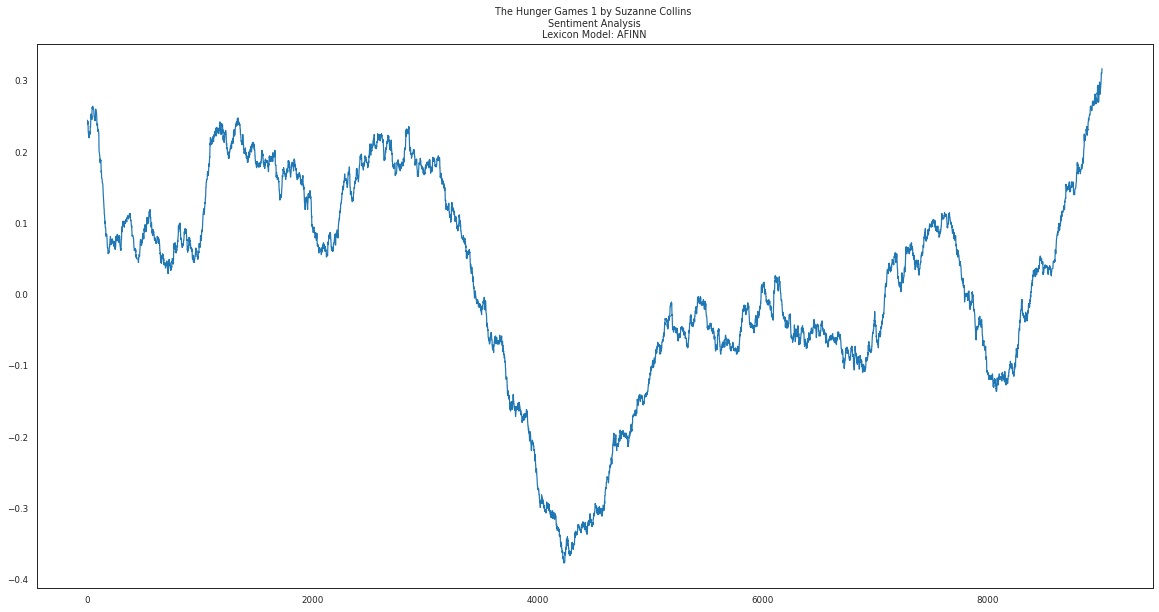

In [96]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Pattern**

In [132]:
!pip install pattern

     |████████████████████████████████| 22.2 MB 351 kB/s 
     |████████████████████████████████| 87 kB 8.1 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 5.6 MB 36.0 MB/s 
     |████████████████████████████████| 5.6 MB 39.2 MB/s 
     |████████████████████████████████| 419 kB 81.1 MB/s 
     |████████████████████████████████| 104 kB 99.1 MB/s 
     |████████████████████████████████| 3.6 MB 45.5 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=cf003cb315d5fefad42e5f213189e07706456f2c969a35bac0fb93a55c3937e7
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99964 sha256=20d6217682306afda1cdb1b3f4a04517372abd83ee8291a50a8f325d7d0dbdc4
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
 

In [135]:
from pattern.en import sentiment, polarity, subjectivity, positive

lexicon_name = 'Pattern'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'pattern'
model_type = 'Lexicon'

# Sentiment analysis (or opinion mining) attempts to determine if
# a text is objective or subjective, positive or negative.
# The sentiment analysis lexicon bundled in Pattern focuses on adjectives.
# It contains adjectives that occur frequently in customer reviews,
# hand-tagged with values for polarity and subjectivity.

# The polarity() function measures positive vs. negative, as a number between -1.0 and +1.0.
# The subjectivity() function measures objective vs. subjective, as a number between 0.0 and 1.0.
# The sentiment() function returns an averaged (polarity, subjectivity)-tuple for a given string.
for word in ("amazing", "horrible", "public"):
    print(word, sentiment(word))

print("")
print(sentiment(
    "The movie attempts to be surreal by incorporating time travel and various time paradoxes,"
    "but it's presented in such a ridiculous way it's seriously boring."))

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = polarity(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = polarity(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')

amazing (0.6000000000000001, 0.9)
horrible (-1.0, 1.0)
public (0.0, 0.06666666666666667)

(-0.21666666666666665, 0.8)
Testing Pattern lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.500  ]: Love

[ -0.800 ]: Hate

[ 0.400  ]: bizarre

[ -0.050 ]: strange

[ 0.000  ]: furious

[ 0.000  ]: elated

[ -0.100 ]: curious

[ 0.000  ]: beserk

[ 0.000  ]: gambaro


Testing Pattern lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -0.825 ]: I hate bad evil worthless Mondays.

[ 0.500  ]: I love Paris in the springtime

[ 0.000  ]: It was Wednesday.

[ -0.900 ]: You are a disgusting pig - I hate you.

[ 0.600  ]: What a delightfully funny and beautiful good man.

[ 0.000  ]: That was it



In [136]:
# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: polarity(x.lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [pattern] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [pattern] Sentiment Recomputed and Value Updated


In [ ]:
corpus_texts_dt[corpus_titles_ls[0]].head()

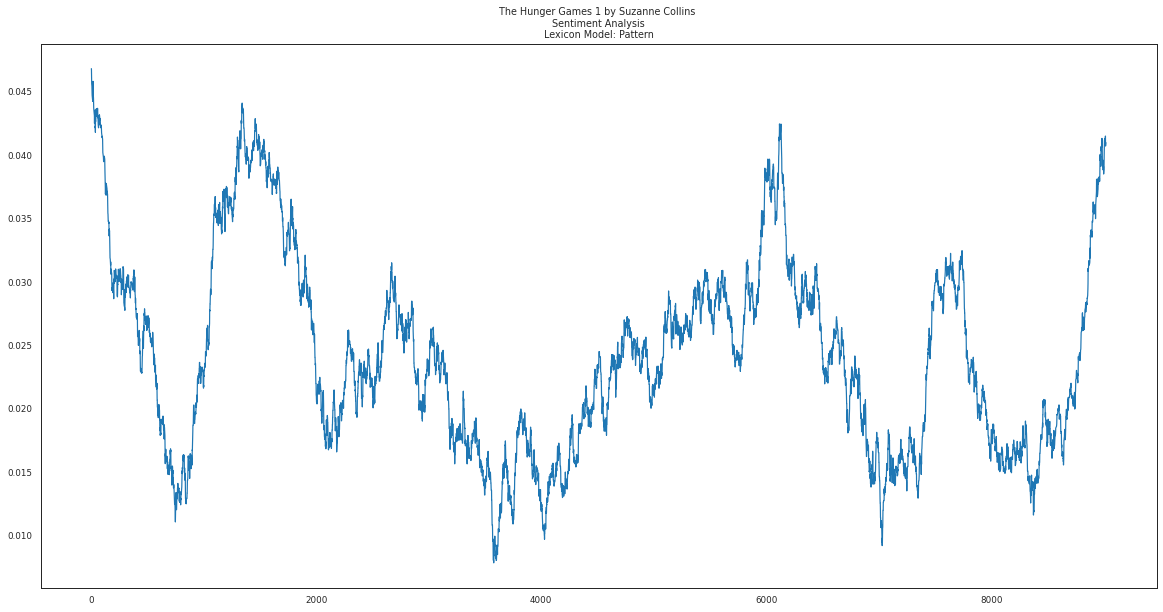

In [137]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [138]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_lex2ml.json
Saving Corpus_Genre: novels
        Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,afinn,flair,pattern,pysentimentr_huliu,pysentimentr_jockersrinker,pysentimentr_lmcd,pysentimentr_nrc,pysentimentr_senticnet,pysentimentr_sentiword,stanza,text_clean,text_raw,textblob,vader
0,0.0,0.8531,0.000000,0.0,0.00,0.0,0.0,0.000,0.0000,10.000000,annotation,Annotation,0.000000,0.0000
1,0.0,-0.6146,0.000000,0.0,-0.25,0.0,0.0,-0.554,0.1250,5.253383,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",0.000000,0.0000
2,0.0,-0.7487,0.018750,0.0,-0.50,1.0,-1.0,-0.705,-1.0625,5.912419,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",0.075000,0.0000
3,1.0,0.9984,1.000000,1.0,0.10,0.0,1.0,2.543,0.6250,8.338057,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",1.000000,1.3733
4,8.0,0.9982,0.158796,2.0,2.25,1.0,1.0,4.240,1.1375,13.026639,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",1.952778,0.9371




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   afinn                       10125 non-null  float64
 1   flair                       10125 non-null  float64
 2   pattern                     10125 non-null  float64
 3   pysentimentr_huliu          10125 non-null  float64
 4   pysentimentr_jockersrinker  10125 non-null  float64
 5   pysentimentr_lmcd           10125 non-null  float64
 6   pysentimentr_nrc            10125 non-null  float64
 7   pysentimentr_senticnet      10125 non-null  float64
 8   pysentimentr_sentiword      10125 non-null  float64
 9   stanza                      10125 non-null  float64
 10  text_clean                  10125 non-null  object 
 11  text_raw                    10125 non-null  object 
 12  textblob                    10125 non-null  float64
 13  vader                       1

## **Heuristics**

In [ ]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'heuristic'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = True #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family] if 'pysentimentr_' in x] + ['afinn']
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

### **VADER**

In [99]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 14.1 MB/s 


In [104]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()

lexicon_name = 'VADER'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'vader'
model_type = 'Heuristic'

# Test Sentence
test_str = "The food was great!"
vs = vader_analyzer.polarity_scores(test_str)
print("{:-<65} {}".format(test_str, str(vs)))

# Test Words
print(f'\n\nTesting {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = vader_analyzer.polarity_scores(aword_str.lower())['compound']
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = sent2vader_comp(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')

The food was great!---------------------------------------------- {'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}


Testing VADER lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.637  ]: Love

[ -0.572 ]: Hate

[ -0.318 ]: bizarre

[ -0.202 ]: strange

[ -0.572 ]: furious

[ 0.637  ]: elated

[ 0.318  ]: curious

[ 0.000  ]: beserk

[ 0.000  ]: gambaro


Testing VADER lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -2.214 ]: I hate bad evil worthless Mondays.

[ 0.637  ]: I love Paris in the springtime

[ 0.000  ]: It was Wednesday.

[ -1.099 ]: You are a disgusting pig - I hate you.

[ 2.052  ]: What a delightfully funny and beautiful good man.

[ 0.000  ]: That was it



In [105]:
# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: sent2vader_comp(str(x).lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [vader] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [vader] Sentiment Recomputed and Value Updated


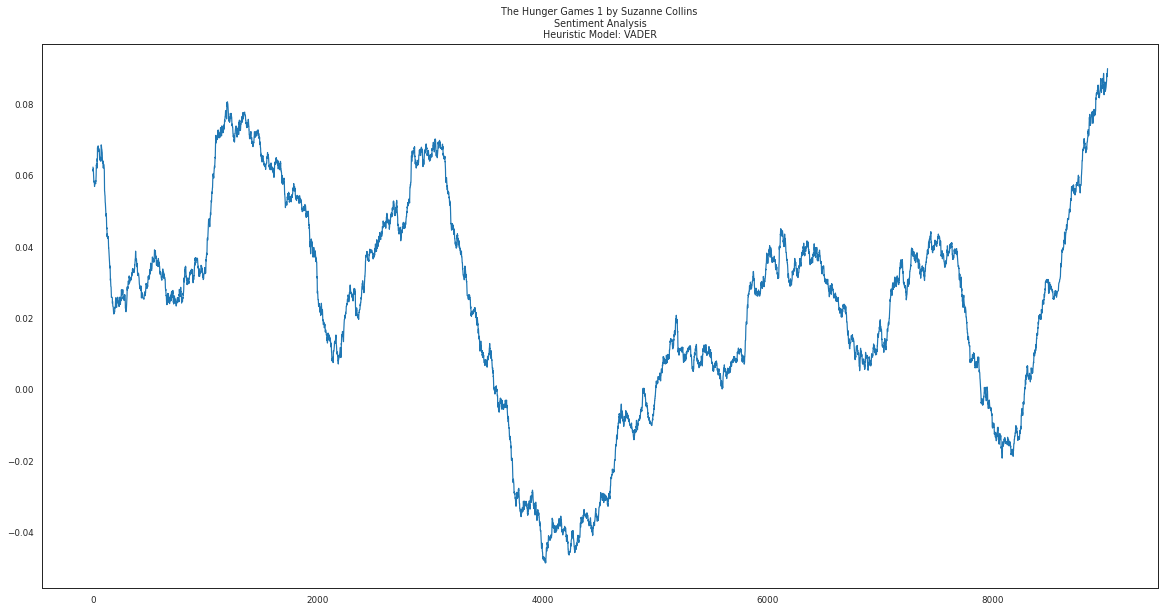

In [107]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

## **ML**

* https://neptune.ai/blog/document-classification-small-datasets
* https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair (TB,VADER,Flair)

In [ ]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'ml'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = True #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family] if 'pysentimentr_' in x] + ['afinn']
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

### **(FUTURE) FastText**

* https://github.com/facebookresearch/fastText
* https://medium.com/@lope.ai/sentiment-analysis-example-using-fasttext-6b1b4d334c53
* https://colab.research.google.com/drive/1bb2OWQcDDolESwhkATD0el0RvF33fenZ#scrollTo=X5PWbhOzZ3ze
* https://fasttext.cc/docs/en/english-vectors.html (embeddings)
* https://github.com/RaRe-Technologies/gensim/blob/37e49971efa74310b300468a5b3cf531319c6536/docs/notebooks/Word2Vec_FastText_Comparison.ipynb
* https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/
* https://github.com/jatinmandav/Neural-Networks/tree/master/Sentiment-Analysis (Universal Sentence Encoder 77%, fastText 69%, word2vec 69%)
* https://github.com/search?q=fasttext+sentiment

Code:
* https://github.com/charlesmalafosse/FastText-sentiment-analysis-for-tweets/blob/master/betsentiment_sentiment_analysis_fasttext.py (tweets)
* https://gist.github.com/hiteshn97/8f222a2773e11d6921b937abaa21ab75 (fastText,  keras)

In [ ]:
"""
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip
%cd fastText-0.9.2
!make
""";

In [ ]:
%%time
"""
train = open('tweets.train','w')  
test = open('tweets.valid','w')  
# with open('../sentiment140.1600000.csv', mode='r', encoding = "ISO-8859-1") as csv_file:  
with open('../sentiment140.csv', mode='r', encoding = "ISO-8859-1") as csv_file:  
    csv_reader = csv.DictReader(csv_file, fieldnames=['target', 'id', 'date', 'flag', 'user', 'text'])
    line = 0
    for row in csv_reader:
        # Clean the training data
        # First we lower case the text
        text = row["text"].lower()
        # remove links
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
        #Remove usernames
        text = re.sub('@[^\s]+','', text)
        # replace hashtags by just words
        text = re.sub(r'#([^\s]+)', r'\1', text)
        #correct all multiple white spaces to a single white space
        text = re.sub('[\s]+', ' ', text)
        # Additional clean up : removing words less than 3 chars, and remove space at the beginning and teh end
        text = re.sub(r'\W*\b\w{1,3}\b', '', text)
        text = text.strip()
        line = line + 1
        # Split data into train and validation
        if line%16 == 0:
            print(f'__label__{row["target"]} {text}', file=test)
        else:
            print(f'__label__{row["target"]} {text}', file=train)
"""

In [ ]:
%%time

# !./fasttext supervised -input tweets.train -output model_tweet

# !./fasttext supervised -input tweets.train -output model_tweet -epoch 30 -lr 0.1
# !./fasttext supervised -input tweets.train -output model_tweet -dim 300 -label __label__ -pretrainedVecctors wiki.ar.vec # Arabic for Netflix

In [ ]:
%%time

# !./fasttext test model_tweet.bin tweets.valid

In [ ]:
"""
!pip install fasttext

from fasttext import load_model
classifier = load_model('model_tweet.bin')

""";

In [ ]:
"""
text_ls = ['Ugghhh... Not happy at all! sorry', 'Happyyyyyyy', 'OH yeah! lets rock.']
labels = classifier.predict(text_ls)
print(labels)

with open('test.txt','w') as fp:
  fp.write("\n".join(text_ls))

!cat test.txt

!./fasttext predict model_tweet.bin test.txt

!./fasttext predict-prob model_tweet.bin test.txt

# Load Different Embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

!unzip crawl-300d-2M-subword.zip


import io

fname = 'crawl-300d-2M-subword.vec'

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

load_vectors(fname)

""";

### **TextBlob**

In [113]:
from textblob import TextBlob

lexicon_name = 'TextBlob'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'textblob'
model_type = 'Heuristic'

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = TextBlob(aword_str.lower()).sentiment.polarity
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = sent2textblob(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')

Testing TextBlob lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.500  ]: Love

[ -0.800 ]: Hate

[ 0.400  ]: bizarre

[ -0.050 ]: strange

[ 0.000  ]: furious

[ 0.000  ]: elated

[ -0.100 ]: curious

[ 0.000  ]: beserk

[ 0.000  ]: gambaro


Testing TextBlob lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -3.300 ]: I hate bad evil worthless Mondays.

[ 0.500  ]: I love Paris in the springtime

[ 0.000  ]: It was Wednesday.

[ -1.800 ]: You are a disgusting pig - I hate you.

[ 2.800  ]: What a delightfully funny and beautiful good man.

[ 0.000  ]: That was it



In [114]:
# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: sent2textblob(str(x).lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [textblob] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [textblob] Sentiment Recomputed and Value Updated


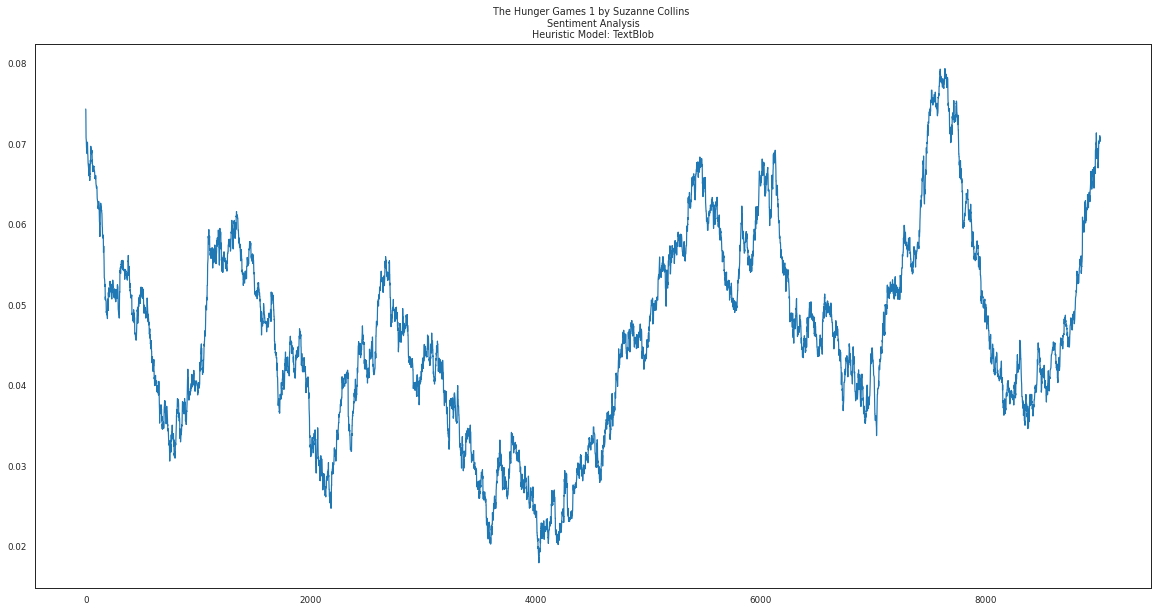

In [115]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [116]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_lex2ml.json
Saving Corpus_Genre: novels
        Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,afinn,flair,pattern,pysentimentr_huliu,pysentimentr_jockersrinker,pysentimentr_lmcd,pysentimentr_nrc,pysentimentr_senticnet,pysentimentr_sentiword,stanza,text_clean,text_raw,textblob,vader
0,0.0,0.8531,0.000000,0.0,0.00,0.0,0.0,0.000,0.0000,10.000000,annotation,Annotation,0.000000,0.0000
1,0.0,-0.6146,0.000000,0.0,-0.25,0.0,0.0,-0.554,0.1250,5.253383,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",0.000000,0.0000
2,0.0,-0.7487,0.018750,0.0,-0.50,1.0,-1.0,-0.705,-1.0625,5.912419,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",0.075000,0.0000
3,1.0,0.9984,1.000000,1.0,0.10,0.0,1.0,2.543,0.6250,8.338057,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",1.000000,1.3733
4,8.0,0.9982,0.158796,2.0,2.25,1.0,1.0,4.240,1.1375,13.026639,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",1.952778,0.9371




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   afinn                       10125 non-null  float64
 1   flair                       10125 non-null  float64
 2   pattern                     10125 non-null  float64
 3   pysentimentr_huliu          10125 non-null  float64
 4   pysentimentr_jockersrinker  10125 non-null  float64
 5   pysentimentr_lmcd           10125 non-null  float64
 6   pysentimentr_nrc            10125 non-null  float64
 7   pysentimentr_senticnet      10125 non-null  float64
 8   pysentimentr_sentiword      10125 non-null  float64
 9   stanza                      10125 non-null  float64
 10  text_clean                  10125 non-null  object 
 11  text_raw                    10125 non-null  object 
 12  textblob                    10125 non-null  float64
 13  vader                       1

## **DNN Models**

In [ ]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'dnn'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = True #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family] if 'pysentimentr_' in x] + ['afinn']
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

### **Flair**

In [119]:
import flair

from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

lexicon_name = 'Flair'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'flair'
model_type = 'Embeddings'

2022-03-04 06:51:36,687 : INFO : 'pattern' package not found; tag filters are not available for English


2022-03-04 06:51:37,146 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp8hze0re3


100%|██████████| 265512723/265512723 [00:07<00:00, 35136857.08B/s]

2022-03-04 06:51:44,793 copying /tmp/tmp8hze0re3 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-03-04 06:51:45,126 removing temp file /tmp/tmp8hze0re3
2022-03-04 06:51:45,165 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [127]:
sentence = Sentence('The food was great!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)
print('\n')
print(sentence.labels[0])

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = flair_sentiment(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = flair_sentiment(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')

Sentence above is:  [POSITIVE (0.9961)]


POSITIVE (0.9961)
Testing Flair lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.977  ]: Love

[ -1.000 ]: Hate

[ -0.989 ]: bizarre

[ -0.992 ]: strange

[ -0.988 ]: furious

[ 0.998  ]: elated

[ 0.983  ]: curious

[ -0.548 ]: beserk

[ 0.880  ]: gambaro


Testing Flair lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -0.997 ]: I hate bad evil worthless Mondays.

[ 0.999  ]: I love Paris in the springtime

[ -0.994 ]: It was Wednesday.

[ -1.000 ]: You are a disgusting pig - I hate you.

[ 0.999  ]: What a delightfully funny and beautiful good man.

[ -0.944 ]: That was it



In [129]:
%%time

# NOTE:  4m10s @19:38 on 20220228 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: flair_sentiment(x.lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [flair] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [flair] Sentiment Recomputed and Value Updated
CPU times: user 2min 12s, sys: 615 ms, total: 2min 12s
Wall time: 2min 13s


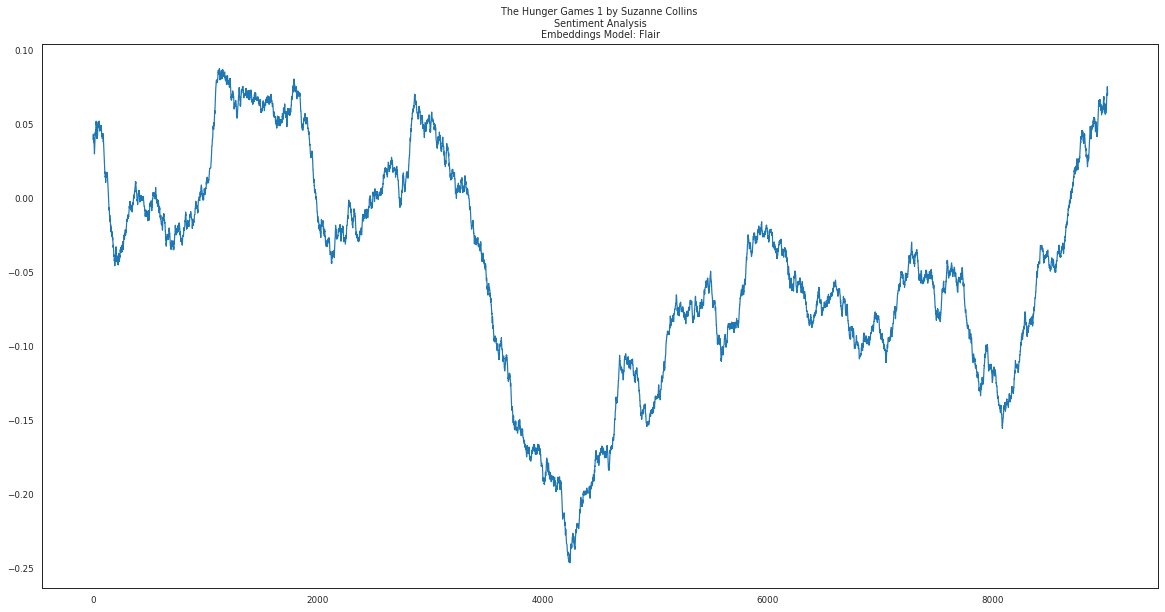

In [130]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [131]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_lex2ml.json
Saving Corpus_Genre: novels
        Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,afinn,flair,pattern,pysentimentr_huliu,pysentimentr_jockersrinker,pysentimentr_lmcd,pysentimentr_nrc,pysentimentr_senticnet,pysentimentr_sentiword,stanza,text_clean,text_raw,textblob,vader
0,0.0,0.8531,0.000000,0.0,0.00,0.0,0.0,0.000,0.0000,10.000000,annotation,Annotation,0.000000,0.0000
1,0.0,-0.6146,0.000000,0.0,-0.25,0.0,0.0,-0.554,0.1250,5.253383,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",0.000000,0.0000
2,0.0,-0.7487,0.018750,0.0,-0.50,1.0,-1.0,-0.705,-1.0625,5.912419,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",0.075000,0.0000
3,1.0,0.9984,1.000000,1.0,0.10,0.0,1.0,2.543,0.6250,8.338057,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",1.000000,1.3733
4,8.0,0.9982,0.158796,2.0,2.25,1.0,1.0,4.240,1.1375,13.026639,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",1.952778,0.9371




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   afinn                       10125 non-null  float64
 1   flair                       10125 non-null  float64
 2   pattern                     10125 non-null  float64
 3   pysentimentr_huliu          10125 non-null  float64
 4   pysentimentr_jockersrinker  10125 non-null  float64
 5   pysentimentr_lmcd           10125 non-null  float64
 6   pysentimentr_nrc            10125 non-null  float64
 7   pysentimentr_senticnet      10125 non-null  float64
 8   pysentimentr_sentiword      10125 non-null  float64
 9   stanza                      10125 non-null  float64
 10  text_clean                  10125 non-null  object 
 11  text_raw                    10125 non-null  object 
 12  textblob                    10125 non-null  float64
 13  vader                       1

### **Stanza**

In [139]:
!pip install stanza

     |████████████████████████████████| 432 kB 12.7 MB/s 
     |████████████████████████████████| 174 kB 70.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=be760c2df54cae51603382106dfb723313469f6db2bb69b736f49c04a2a88d0d
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [140]:
%time

import stanza

stanza.download('en')

lexicon_name = 'Stanza'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'stanza'
model_type = 'Linguistic'

nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

# Test stanza directly
doc = nlp('Ram is a bad boy')
for i, sentence in enumerate(doc.sentences):
    print(i, sentence.sentiment)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 22.6 µs


2022-03-04 06:59:59,931 : INFO : Downloading default packages for language: en (English)...


2022-03-04 07:00:19,261 : INFO : Finished downloading models and saved to /root/stanza_resources.
2022-03-04 07:00:19,269 : INFO : Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-03-04 07:00:19,271 : INFO : Use device: gpu
2022-03-04 07:00:19,273 : INFO : Loading: tokenize
2022-03-04 07:00:20,099 : INFO : Loading: sentiment
2022-03-04 07:00:20,774 : INFO : Done loading processors!


0 0


In [145]:
# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = stanza_discrete2continous_sentiment(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = stanza_discrete2continous_sentiment(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')


Testing Stanza lexicon for WORDS Sentiment
--------------------------------------------------
[ 20.000 ]: Love

[ 0.000  ]: Hate

[ 0.000  ]: bizarre

[ 10.000 ]: strange

[ 10.000 ]: furious

[ 20.000 ]: elated

[ 20.000 ]: curious

[ 10.000 ]: beserk

[ 10.000 ]: gambaro


Testing Stanza lexicon for SENTENCES Sentiment
--------------------------------------------------
[ 1.057  ]: I hate bad evil worthless Mondays.

[ 3.700  ]: I love Paris in the springtime

[ 2.503  ]: It was Wednesday.

[ 3.047  ]: You are a disgusting pig - I hate you.

[ 5.506  ]: What a delightfully funny and beautiful good man.

[ 2.503  ]: That was it



In [ ]:
%%time

# NOTE:  4m10s @19:38 on 20220228 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: stanza_discrete2continous_sentiment(x.lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity


In [ ]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


# **[END OF REFACTORED CODE]**

## **Statistical ML Models**

* Linear Regression
* Logistic Regression
* Random Forest Classifier
* Linear SVC
* MultinomialNB

Tutorials

* https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (Tutorial) 
* https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/natural_language_processing/example_text_classification.ipynb (github)
* https://wellsr.com/python/python-sentiment-analysis-with-sklearn/
* https://colab.research.google.com/drive/186bOdu08nv4xHe6VeBgt_aIk9_fziqsX#scrollTo=hpDp3V0Lg-sw

#### Setup and Configuration


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import save_npz, load_npz  # load/save sparse matrices
from joblib import dump, load # load/save sklearn objects efficiently

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

In [ ]:
# Vectorizing text
from sklearn.feature_extraction.text import TfidfVectorizer


# Validation: https://www.kaggle.com/pocooo/types-of-cross-validation-all-you-need

# Simple Cross Fold Validation
from sklearn.model_selection import KFold
# model=DecisionTreeClassifier()
kfold_validation=KFold(10)

# import numpy as np
from sklearn.model_selection import cross_val_score
# results=cross_val_score(model,X,y,cv=kfold_validation)
# print(results)
# print(np.mean(results))

# Stratified CV 
from sklearn.model_selection import StratifiedKFold
skfold=StratifiedKFold(n_splits=5)
# model=DecisionTreeClassifier()
# scores=cross_val_score(model,X,y,cv=skfold)
# print(np.mean(scores))

# LOO CV
from sklearn.model_selection import LeaveOneOut
# model=DecisionTreeClassifier()
leave_validation=LeaveOneOut()
# results=cross_val_score(model,X,y,cv=leave_validation)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# TODO: Next few cells unneeded?

In [ ]:
nlp = spacy.blank('en')

nlp = spacy.load('en', disable=['parser', 'ner'])

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
# nlp.add_pipe(PySBDFactory(nlp))

In [ ]:
stopwords_custom = ['bazinga', 'hoohaw', 'pating']
stopwords_en.extend(stopwords_custom)

In [ ]:
# Utility Functions for ML Model Metrics

# https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook

def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

def lexicon_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

In [ ]:
from sklearn.pipeline import Pipeline
text_clf_SGDClassifier = Pipeline([('vect', CountVectorizer(ngram_range=(2,4), stop_words='english',lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),
])
text_clf_SGDClassifier.fit(X, y)



In [ ]:
!ls ./data

In [ ]:
# TEST
fld = './data/'

[os.path.join(fld, f) for f in os.listdir() if os.path.isfile(os.path.join(fld, f))]

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly
import plotly.graph_objs as go
# import plotly.offline as ply
# plotly.offline.init_notebook_mode()
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [ ]:
classifier_names = ['Naive Bayes', 
                    'Decision Tree', 
                    'Random Forest', 
                    'Nearest Neighbors', 
                    'Neural Network']

classifiers = [GaussianNB(),
               DecisionTreeClassifier(max_depth=10),
               RandomForestClassifier(max_depth=10),
               KNeighborsClassifier(5),
               MLPClassifier()]

plot_data=[]

clf_data=zip(classifier_names, classifiers)

for clf_name, clf in clf_data:
    print('Running '+clf_name)
    kf=StratifiedKFold(n_splits=10, shuffle=True)
    scores=cross_val_score(clf, X, y, cv=kf)
    print(scores)
    plot_data.append(
        go.Scatter(
            x=[i+1 for i in range(10)],
            y=scores,
            mode='lines',
            name=clf_name
        )
    )



#### Download Sentiment IMDB Training Dataset (if necessary)

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Check if IMDB datafile exists, download if missing

filepath_imdb = f"{SUBDIR_DATA}imdb-dataset-of-50k-movie-reviews.zip"
print(f'filepath: {filepath_imdb}')

my_file = Path(filepath_imdb)
if my_file.is_file():
  print('\n[SKIP] to the next Section [Load IMDB Dataset]\n       IMDB training dataset already exists\n')
else:
  print('\n[CONTINUE] executing code cells')


In [ ]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Get IMDB Dataset

%cd ./data
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip
!ls -altr

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

### Prepare IMDB Dataset

In [ ]:
# Verify in project root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
imdb50k_df = pd.read_csv(f"{SUBDIR_DATA}IMDB Dataset.csv")
imdb50k_df["polarity"] = imdb50k_df["sentiment"].map({"negative": 0, "positive": 1})
imdb50k_df["text_raw"] = imdb50k_df["review"].astype('string')
imdb50k_df.drop(columns=['sentiment', 'review'], inplace=True)

# supervised_db = 'imdb50k'

imdb50k_df.head()
imdb50k_df.info()

#### Clean and Split Training Dataset

In [ ]:
import nltk
nltk.download('omw-1.4')

In [ ]:
import texthero as hero
from texthero import preprocessing

stem_pipeline = [preprocessing.fillna,
                 preprocessing.lowercase,
                 preprocessing.remove_digits,
                 preprocessing.remove_punctuation,
                 preprocessing.remove_diacritics,
                 preprocessing.remove_stopwords,
                 preprocessing.remove_whitespace,
                 preprocessing.stem]

In [ ]:
%%time

# NOTE: 3m55s @02:54 on 20220302 Colab Pro
#        

imdb50k_df['text_clean'] = imdb50k_df['text_raw'].pipe(hero.clean, stem_pipeline)

In [ ]:
# Saved Cleaned IMDB Training Text Datafile

fname_imdb50k_clean = f'{SUBDIR_DATA}imdb50k_clean.csv'
imdb50k_df.to_csv(fname_imdb50k_clean, index=False)
!ls -altr 

In [ ]:
!ls ./data

In [ ]:
TRAIN_TEST_SPLIT_PER = 0.8

data_len = imdb50k_df.shape[0]
split_indx = int(TRAIN_TEST_SPLIT_PER * data_len)

train_df = imdb50k_df[:split_indx]
test_df = imdb50k_df[split_indx:]

print(f'Splitting {TRAIN_TEST_SPLIT_PER*100:.2f}% of Training Data for Testing')
print(f'  There are {data_len} examples, {split_indx} of them used for Testing, {data_len - split_indx} for Training')

In [ ]:
train_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn import datasets

In [ ]:
%%time

# NOTE: 

# Vectorize IMDB Review (Representation: Trigram TF-IDF)

# Step 1: Bigram
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bigram_vectorizer.fit(train_df['text_clean'].values)

# X_train_bigram = bigram_vectorizer.transform(train_df['text_clean'].values)


# Step 2: TF-IDF
# Texthero removes stopwords
# CountVectorizer includes high-freq bigrams
# CountVectorizer limits max_features/token vocabulary size
# without max features IMDB Training (40k reviews), X_train_bigram_tf_idf shape = (40000, 2211883)
# bigram_tf_idf_transformer = TfidfTransformer(ngram_range=(1,2), stop_words=stopwords_en_ls, max_features=1000)
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)
X_train = X_train_bigram_tf_idf
y_train = train_df['polarity']


In [ ]:
type(X_train_bigram_tf)

In [ ]:
%%time

# NOTE: 50s

# Save checkpoint

!pwd
filename_save = f'{SUBDIR_DATA}imdb50k_stems.csv'
imdb50k_df.to_csv(filename_save, encoding='utf-8', index=False)
!ls -altr $SUBDIR_DATA

In [ ]:
!ls ./data

#### Vectorize IMDB Dataset

In [ ]:
%%time

# NOTE: 

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords_en_ls, max_features=1000)
vectors = vectorizer.fit_transform(imdb50k_df.text_clean)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
type(train_df.iloc[0]['polarity'])

In [ ]:
# For Statistical ML Models, prepare Dataset
#   separate text examples (X) from labels (y)

X = X_train_bigram_tf_idf # words_df
y = train_df['polarity'].values # imdb50k_df.polarity
X.shape
print('\n')
y.shape
type(y[0])

In [ ]:
# Split labeled dataset into training, validation and test sets
# e.g. for IMDB 50k reviews: Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=42)

print("Dataset Splits: Train, Valid, Test")
[x.shape for x in [X_train,X_valid,X_test]]

In [ ]:
X_train

In [ ]:
# Clean text_raw

for i, atext_str in enumerate(corpus_titles_ls):
  print(f'Processing #{i}: {atext_str}')

  corpus_texts_dt[atext_str].head()
  # df['text_clean'] = df['text_raw'].pipe(hero.clean)

In [ ]:
# Remove non-alphanumeric chacters
# imdb50k_df['text_lower'] = imdb50k_df['text_raw']

"""
pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
imdb50k_df['text_clean'] = imdb50k_df['text_raw'].str.lower().str.strip().str.findall(pattern).str.join(' ')
imdb50k_df.head(1)
""";

In [ ]:
import spacy

nlp = spacy.blank('en')

nlp = spacy.load('en', disable=['parser', 'ner'])

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
# nlp.add_pipe(PySBDFactory(nlp))

In [ ]:
%%time

# NOTE: (no stem) 4m09s
#       (w/ stem) 4m24s

i = 0

for key_novel, atext_df in corpus_texts_dt.items():

  print(f'Processing Novel #{i}: {key_novel}...')

  atext_df['text_clean'] = clean_text(atext_df, 'text_raw', text_type='formal')

  atext_df['text_clean'] = lemma_pipe(atext_df['text_clean'])
  atext_df['text_clean'] = atext_df['text_clean'].astype('string')

  # TODO: Fill in all blank 'text_clean' rows with filler semaphore
  atext_df.text_clean = atext_df.text_clean.fillna('this_blank')

  atext_df.head(2)

  print(f'  shape: {atext_df.shape}')

  i += 1

In [ ]:
# Verify the first Text in Corpus is cleaned

corpus_texts_dt[corpus_titles_ls[0]].head(20)
corpus_texts_dt[corpus_titles_ls[0]].info()

### Simple Models

In [ ]:
seed = 42
dataset = datasets.load_wine()
X = dataset.data; y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
LinearDiscriminantAnalysis

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [ ]:
results = []
names = []
seed=42

scoring = 'accuracy'
for name, model in models:
      kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

"""

LR: 0.862886 (0.005822)
LDA: 0.859657 (0.006562)
KNN: 0.728571 (0.008688)
CART: 0.710829 (0.007842)
NB: 0.817286 (0.007659)

""";

#### Linear Regression (linreg)

#### Logistic Regression (logreg)

#### Logistic Regression, 6-Fold CV (logreg_cv6)

#### Random Forest (rf)

#### Linear SVC (lin_svc)

#### Multinomial Naive Bayes (multi_nb)

In [ ]:


from sklearn.pipeline import Pipeline

text_clf_SGDClassifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), stop_words='english',lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),
])
text_clf_SGDClassifier.fit(X_train, y_train)
clf_linreg = LinearRegression()

clf_linreg.fit(X, y)


### Ensemble Models

#### XGBoost (xgb)

* https://xgboost.readthedocs.io/en/stable/

* https://github.com/dmlc/xgboost

* https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [ ]:
!pip install xgboost

In [ ]:
import xgboost
print(xgboost.__version__)

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier()

#### CatBoost (catb)

* https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

* https://github.com/catboost/tutorials/

* https://catboost.ai/

In [ ]:
!pip install catboost

In [ ]:
import catboost
print(catboost.__version__)

In [ ]:
from catboost import CatBoostClassifier, Pool   # https://catboost.ai/

In [ ]:


model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    # cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

In [ ]:
%%time

# NOTE: 

# test_data = catboost_pool = Pool(X_train, y_train)

clf_catb = CatBoostClassifier(iterations=50,
                              random_seed=rand_seed,
                              depth=6,
                              learning_rate=0.5,
                              loss_function='Logloss',
                              verbose=5)

# train the model
clf_catb.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=True
)

print('Model is fitted: ' + str(clf_catb.is_fitted()))
print('Model params:')
print(clf_catb.get_params())

#### LightGBM (lgbm)

#### AdaBoost (adab)

### AutoML of Models

#### FLAML (flaml)

#### AutoGluon (autogluon)

## **Deep Neural Networks**

* https://github.com/thoailinh/Sentiment-Analysis-using-BERT (Viet Comparison)

* https://github.com/Feuoy/sentiment-analysis (Chinese Comparison)

* https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model
* https://github.com/bentrevett/pytorch-sentiment-analysis

* https://github.com/nileshsah/deep-text-classifier/blob/master/inshorts_notebook.ipynb
* https://github.com/saurabhrathor/InceptionModel_SentimentAnalysis (fasttext emb CNN+LSTM) BB_twtr SemEval2017
* https://github.com/kaliahinartem/twitter_sentiment_analysis
* https://github.com/leelaylay/TweetSemEval


### **Common Setup**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
training_df.info()

In [ ]:
# Split labeled dataset into training, validation and test sets
# e.g. for IMDB 50k reviews: Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(training_df['text_raw'], training_df['polarity'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

[x.shape for x in [X_train,X_valid,X_test]]


In [ ]:
X_train.shape
print('\n')
type(X_train)

In [ ]:
type(X_train)

In [ ]:
X_train[:2]

In [ ]:
%%time

# Tokenize text

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(training_df.text_raw)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train1[2])

In [ ]:
type(X_train1)
print('\n')
X_train1

In [ ]:
corpus_sents_df.head()

In [ ]:
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_clean'].astype('string')
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:2]

In [ ]:
X_corpus1 = tokenizer.texts_to_sequences(X_corpus_ser)
type(X_corpus1)
X_corpus_ser[4]
X_corpus1[4]

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(X_corpus_ser)) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
X_corpus = np.array(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
tokens_ls_ls = tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])
X_corpus_ar = np.array([np.array(lsi) for lsi in tokens_ls_ls])
X_corpus_ar
""";

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
# X_corpus = X_corpus.astype('int32')
# npa = np.asarray(someListOfLists, dtype=np.float32)
X_corpus[:3]
print('\n')
type(X_corpus)
""";

In [ ]:
print(X_train[2])

In [ ]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
seq_lens = [len(s) for s in X_corpus1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
# Set max sequence and pad where necessary

maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

print(X_train1[2, :])

In [ ]:
X_corpus1 = pad_sequences(X_corpus1, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

### **Fully Connected Networks (FCN)**

In [ ]:
# Build the Network

embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
%%time

# Train the Network

history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

In [ ]:
y_test1_pred = model.predict(X_test1)
y_test1_pred

In [ ]:
y_test1_pred.size

In [ ]:
y_test1_pred_bin = np.where(y_test1_pred > 0.5, 1, 0)
y_test1_pred_bin = y_test1_pred_bin.squeeze()

In [ ]:
type(y_test1_pred_bin[0])

In [ ]:
y_test

In [ ]:
y_test_fl = y_test.apply(lambda x: float(x))
y_test_fl

In [ ]:
y_test_ar = np.array(y_test_fl, dtype=np.float32)
type(y_test_ar)
print('\n')
y_test_ar.shape
print('\n')
y_test_ar

In [ ]:
type(y_test1_pred)
print('\n')
y_test1_pred = y_test1_pred.squeeze()
y_test1_pred.shape
print('\n')
y_test1_pred

In [ ]:
accuracy_score(y_test, y_test1_pred_bin)

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
sns.heatmap(confusion_matrix(y_test, y_test1_pred_bin),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show();

In [ ]:
y_corpus1_pred = model.predict(X_corpus1)
type(y_corpus1_pred)
print('\n')
print(y_corpus1_pred)

In [ ]:
fcn_ar = y_corpus1_pred.squeeze()
fcn_ar.shape

In [ ]:
corpus_sents_df['fcn'] = pd.Series(fcn_ar)

In [ ]:
# corpus_sents_df['fcn'].apply(lambda x: 6*(x-0.3)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nFully Connected Neural Net (Default w/IMDB) SMA=10%');

### **RNN**

### **LSTM**

**Ref: https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#4.-Predictive-Modelling-using-Machine-Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()



In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,y_train, test_size=0.2,random_state=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
%%time

# NOTE: 3m51s

D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

In [ ]:
#Plot accuracy and loss

plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,y_test)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:5]

In [ ]:
type(X_corpus)

In [ ]:
##create sequences of reviews
seq_corpus = tokenizer.texts_to_sequences(X_corpus_ser)
# seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
type(seq_corpus)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_corpus]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
max_seq_len

In [ ]:
#create padded sequences
pad_corpus=pad_sequences(seq_corpus,truncating = 'post', padding = 'pre',maxlen=584) # max_seq_len)
# pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Generate predictions for the corpus dataset
y_corpus_pred = model.predict(pad_corpus)
y_corpus_pred.shape
y_corpus_pred

In [ ]:
lstm_ar = y_corpus_pred.squeeze()
lstm_ar.shape

In [ ]:
corpus_sents_df['lstm'] = pd.Series(lstm_ar)

In [ ]:
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['lstm'].apply(lambda x: 5*(x-0.47)).rolling(900, center=True).mean().plot(label='LSTM Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nLSTM Neural Net (Default w/IMDB) SMA=10%');

In [ ]:
corpus_root_filename

In [ ]:
corpus_sents_df.to_csv(f'sum_4andDNN_{corpus_root_filename}.csv')

**Ref: https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model**

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict(X_test1))

In [ ]:
history.history

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

### **CNN**

* https://github.com/bentrevett/pytorch-sentiment-analysis (CNN w/GLoVE and IMDB)

* https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
%%time

# NOTE: 

model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict_classes(X_test1))

In [ ]:
plot_history(history)

### **BERT**

In [ ]:
# https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#5.-Predictive-Modelling-using-Deep-Learning

#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
#pass our texts to the tokenizer

Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [ ]:
#preparing our datasets

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## **Deep Neural Networks**

* https://github.com/thoailinh/Sentiment-Analysis-using-BERT (Viet Comparison)

* https://github.com/Feuoy/sentiment-analysis (Chinese Comparison)

* https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model
* https://github.com/bentrevett/pytorch-sentiment-analysis

* https://github.com/nileshsah/deep-text-classifier/blob/master/inshorts_notebook.ipynb
* https://github.com/saurabhrathor/InceptionModel_SentimentAnalysis (fasttext emb CNN+LSTM) BB_twtr SemEval2017
* https://github.com/kaliahinartem/twitter_sentiment_analysis
* https://github.com/leelaylay/TweetSemEval


### **Common Setup**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
training_df.info()

In [ ]:
# Split labeled dataset into training, validation and test sets
# e.g. for IMDB 50k reviews: Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(training_df['text_raw'], training_df['polarity'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

[x.shape for x in [X_train,X_valid,X_test]]


In [ ]:
X_train.shape
print('\n')
type(X_train)

In [ ]:
type(X_train)

In [ ]:
X_train[:2]

In [ ]:
%%time

# Tokenize text

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(training_df.text_raw)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train1[2])

In [ ]:
type(X_train1)
print('\n')
X_train1

In [ ]:
corpus_sents_df.head()

In [ ]:
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_clean'].astype('string')
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:2]

In [ ]:
X_corpus1 = tokenizer.texts_to_sequences(X_corpus_ser)
type(X_corpus1)
X_corpus_ser[4]
X_corpus1[4]

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(X_corpus_ser)) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
X_corpus = np.array(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
tokens_ls_ls = tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])
X_corpus_ar = np.array([np.array(lsi) for lsi in tokens_ls_ls])
X_corpus_ar
""";

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
# X_corpus = X_corpus.astype('int32')
# npa = np.asarray(someListOfLists, dtype=np.float32)
X_corpus[:3]
print('\n')
type(X_corpus)
""";

In [ ]:
print(X_train[2])

In [ ]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
seq_lens = [len(s) for s in X_corpus1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
# Set max sequence and pad where necessary

maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

print(X_train1[2, :])

In [ ]:
X_corpus1 = pad_sequences(X_corpus1, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

### **Fully Connected Networks (FCN)**

In [ ]:
# Build the Network

embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
%%time

# Train the Network

history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

In [ ]:
y_test1_pred = model.predict(X_test1)
y_test1_pred

In [ ]:
y_test1_pred.size

In [ ]:
y_test1_pred_bin = np.where(y_test1_pred > 0.5, 1, 0)
y_test1_pred_bin = y_test1_pred_bin.squeeze()

In [ ]:
type(y_test1_pred_bin[0])

In [ ]:
y_test

In [ ]:
y_test_fl = y_test.apply(lambda x: float(x))
y_test_fl

In [ ]:
y_test_ar = np.array(y_test_fl, dtype=np.float32)
type(y_test_ar)
print('\n')
y_test_ar.shape
print('\n')
y_test_ar

In [ ]:
type(y_test1_pred)
print('\n')
y_test1_pred = y_test1_pred.squeeze()
y_test1_pred.shape
print('\n')
y_test1_pred

In [ ]:
accuracy_score(y_test, y_test1_pred_bin)

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
sns.heatmap(confusion_matrix(y_test, y_test1_pred_bin),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show();

In [ ]:
y_corpus1_pred = model.predict(X_corpus1)
type(y_corpus1_pred)
print('\n')
print(y_corpus1_pred)

In [ ]:
fcn_ar = y_corpus1_pred.squeeze()
fcn_ar.shape

In [ ]:
corpus_sents_df['fcn'] = pd.Series(fcn_ar)

In [ ]:
# corpus_sents_df['fcn'].apply(lambda x: 6*(x-0.3)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nFully Connected Neural Net (Default w/IMDB) SMA=10%');

### **RNN**

### **LSTM**

**Ref: https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#4.-Predictive-Modelling-using-Machine-Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()



In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,y_train, test_size=0.2,random_state=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
%%time

# NOTE: 3m51s

D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

In [ ]:
#Plot accuracy and loss

plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,y_test)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:5]

In [ ]:
type(X_corpus)

In [ ]:
##create sequences of reviews
seq_corpus = tokenizer.texts_to_sequences(X_corpus_ser)
# seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
type(seq_corpus)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_corpus]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
max_seq_len

In [ ]:
#create padded sequences
pad_corpus=pad_sequences(seq_corpus,truncating = 'post', padding = 'pre',maxlen=584) # max_seq_len)
# pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Generate predictions for the corpus dataset
y_corpus_pred = model.predict(pad_corpus)
y_corpus_pred.shape
y_corpus_pred

In [ ]:
lstm_ar = y_corpus_pred.squeeze()
lstm_ar.shape

In [ ]:
corpus_sents_df['lstm'] = pd.Series(lstm_ar)

In [ ]:
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['lstm'].apply(lambda x: 5*(x-0.47)).rolling(900, center=True).mean().plot(label='LSTM Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nLSTM Neural Net (Default w/IMDB) SMA=10%');

In [ ]:
corpus_root_filename

In [ ]:
corpus_sents_df.to_csv(f'sum_4andDNN_{corpus_root_filename}.csv')

**Ref: https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model**

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict(X_test1))

In [ ]:
history.history

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

### **CNN**

* https://github.com/bentrevett/pytorch-sentiment-analysis (CNN w/GLoVE and IMDB)

* https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
%%time

# NOTE: 

model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict_classes(X_test1))

In [ ]:
plot_history(history)

### **BERT**

In [ ]:
# https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#5.-Predictive-Modelling-using-Deep-Learning

#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
#pass our texts to the tokenizer

Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [ ]:
#preparing our datasets

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## **AutoKeras**

* https://autokeras.com/tutorial/text_classification/

In [ ]:
# RESTART RUNTIME

!pip install autokeras

In [ ]:
import os

import numpy as np
import tensorflow as tf
from sklearn.datasets import load_files

import autokeras as ak

In [ ]:
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)

# set path to dataset
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), "aclImdb")

classes = ["pos", "neg"]
train_data = load_files(
    os.path.join(IMDB_DATADIR, "train"), shuffle=True, categories=classes
)
test_data = load_files(
    os.path.join(IMDB_DATADIR, "test"), shuffle=False, categories=classes
)

x_train = np.array(train_data.data)
y_train = np.array(train_data.target)
x_test = np.array(test_data.data)
y_test = np.array(test_data.target)

print(x_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)
print(x_train[0][:50])  # this film was just brilliant casting

In [ ]:
# Initialize the text classifier.
clf = ak.TextClassifier(
    overwrite=True, max_trials=1
)  # It only tries 1 model as a quick demo.

# Feed the text classifier with training data.
clf.fit(x_train, y_train, epochs=2)

# Predict with the best model.
predicted_y = clf.predict(x_test)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

In [ ]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
)

In [ ]:
"""
split = 5000
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

clf.fit(
    x_train,
    y_train,
    epochs=2,
    # Use your own validation set.
    validation_data=(x_val, y_val),
)
""";

In [ ]:
input_node = ak.TextInput()
output_node = ak.TextBlock(block_type="ngram")(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)
clf.fit(x_train, y_train, epochs=2)

## **Pytorch-Optimize**

* https://github.com/jettify/pytorch-optimizer (20210705 2k)

## **Keras-Tuner**

* https://github.com/keras-team/keras-tuner

# **END**

# **[OLD STARTING POINT]**

In [ ]:
groups_ls = ['models_baseline_ls',
                'models_sentimentr_ls',
                'models_syuzhetr_ls',
                'models_transformer_ls']

# Could add suffix '_sst2' if classifiers trained on SST2 (currently requires 30m on Colab Pro/GPU+RAM)
models_supervised_ls = ['linreg_imdb50k',
                   'svc_imdb50k',
                   'logreg_imdb50k',
                   'dforest_imdb50k',
                   'multinb_imdb50k']

models_baseline_ls = ['sentimentr',
                      'syuzhet',
                      'bing',
                      'sentiword',
                      'senticnet',
                      'nrc',
                      'afinn',
                      'vader',
                      'textblob',
                      'flair',
                      'pattern',
                      'stanza']

models_sentimentr_ls = ['jockers_rinker',
                        'jockers',
                        'huliu',
                        'senticnet',
                        'sentiword',
                        'nrc',
                        'lmcd']

models_syuzhetr_ls = ['syuzhet',
                      'bing',
                      'afinn',
                      'nrc']

models_transformer_ls = ['roberta15lg', 
                         'nlptown', 
                         'yelp', 
                         'hinglish',
                         'imdb2way', 
                         'huggingface', 
                         't5imdb50k', 
                         'robertaxml8lang']

# Temporarily redefine from English to French Transformer Models
# models_transformer_ls = ['flaubert', 'nlptown', 'robertaxml8lang']

**Install Libraries**

In [ ]:
# fast detection of character set encoding for text/files

!pip install cchardet

In [ ]:
!pip install pysbd

In [ ]:
# common ML code

!pip install sklearn

In [ ]:
%pip install contractions

In [ ]:
!pip install pysbd

In [ ]:
!pip install spacy

In [ ]:
import pysbd
import spacy
from pysbd.utils import PySBDFactory

# Conditionally loads english or french PySBD/NLTK Sentence tokenizers 
#   in parags2sents()

# nlp = spacy.blank('en')

# nlp = spacy.load('en', disable=['parser', 'ner'])

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
# nlp.add_pipe(PySBDFactory(nlp))

In [ ]:


# or you can use it implicitly with keyword
# pysbd = nlp.create_pipe('pysbd')
# nlp.add_pipe(pysbd)

# doc = nlp('My name is Jonas E. Smith. Please turn to p. 55.')
# print(list(doc.sents))
# [My name is Jonas E. Smith., Please turn to p. 55.]

**Import Libraries**

In [ ]:
import os
import sys
import io
import glob
import json
import contextlib

In [ ]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import re
import string

In [ ]:
from itertools import cycle  # For plotly

import collections
from collections import OrderedDict

In [ ]:
# Import libraries for logging

import logging
from datetime import datetime
import time                     # (TODO: check no dependencies and delete)
from time import gmtime, strftime

In [ ]:
import nltk

# Download for sentence tokenization
import nltk.data
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Download for nltk/VADER sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') # Load the English Model

In [ ]:
from sklearn.preprocessing import MinMaxScaler   # To normalize time series
from sklearn.preprocessing import StandardScaler # To Standardize time series: center(sub mean) and rescale within 1 SD (only for well-behaved guassian distributions)
from sklearn.preprocessing import RobustScaler   # To Standardize time series: center(sub median) and rescale within 25%-75% (1st-3rd) IQR (better for noisy, outliers distributions)

In [ ]:
minmax_scaler = MinMaxScaler()
mean_std_scaler = StandardScaler()
median_iqr_scaler = RobustScaler()

In [ ]:
# Zoom interpolates new datapoints between existing datapoints to expand a time series 

from scipy.ndimage.interpolation import zoom

In [ ]:
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy import signal
from scipy.signal import argrelextrema

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels import robust

In [ ]:
corpus_sects_df = pd.DataFrame()

**Define Library-Dependent Objects**

In [ ]:
import contractions

In [ ]:
# Necessary to define before defining Utility Functions using these DataFrames

corpus_sents_df = pd.DataFrame()

**Configure Jupyter Notebook**

In [ ]:
from IPython.display import HTML, display

def my_css():
   display(HTML("""<style>table.dataframe td{white-space: nowrap;}</style>"""))

get_ipython().events.register('pre_run_cell', my_css)

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure matplotlib and seaborn

# Plotting pretty figures and avoid blurry images
# %config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
# sns.set_context('talk')

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100
plt.rc('figure', facecolor='white')

In [ ]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from ipywidgets import widgets, interactive

# Configure Google Colab

%load_ext google.colab.data_table

In [ ]:
# Text wrap

from IPython.display import HTML

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from IPython.display import HTML

import plotly.graph_objects as go
import plotly.express as px
import plotly

In [ ]:
from IPython.display import HTML, display

def my_css():
   display(HTML("""<style>table.dataframe td{white-space: nowrap;}</style>"""))

get_ipython().events.register('pre_run_cell', my_css)

In [ ]:
# with pd.option_context('display.max_colwidth', None):
#   display(corpus_transformer_df['sent_raw'])

In [ ]:
# with pd.option_context('display.max_colwidth', None):
#   display(corpus_sentimentr_df.iloc[:10]['sent_raw'])

**Configuration Details Snapshot**

In [ ]:
# Snap Shot of Time, Machine, Data and Library/Version Blueprint
# TODO:

In [ ]:
!pip list

In [ ]:
# !pip install watermark

In [ ]:
# %load_ext watermark

In [ ]:
# %watermark

# **Delete/Reset Main DataStructure**

In [ ]:
%whos DataFrame

In [ ]:
# %reset_selective corpus_sents_df corpus_parags_df corpus_sects_df corpus_chaps_df

In [ ]:
# %reset_selective corpus_sentimentr corpus_syuzhetr_df corpus_transformer_df corpus_unified_df

In [ ]:
# %reset_selective temp_baseline_df temp_df temp_sentimentr_df temp_syuzhetr_df temp_transformer_df unified_crux_df corr_df

# **Connect to Corpus Text files**

## **Option (a): Connect to Google gDrive**

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize Single Word
print(lemmatizer.lemmatize("bats"))

In [ ]:
test_str = "I love eating bats and driving many cars." #  around the darken town at night."

doc = nlp(test_str)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])
#> 'the strip bat be hang on -PRON- foot for good'

In [ ]:
"""

def stem_str(text_str):
  '''
  Given a text string
  Return the same string with all tokens stemmed where possible
  '''

  from nltk.stem import WordNetLemmatizer # For stemming the sentence
  from nltk.stem import SnowballStemmer # For stemming the sentence


""";

In [ ]:
def lemmatize_str(text_str):
  '''
  Given a text string
  Return the same string with all tokens lemmatized where possible
  '''

  # NOTE: depends upon Setup above importing minimal SpaCy pipeline defined as [nlp]

  # Lemmaitization MAY help performance, but depends on SA Model and Corpus (see below)
  # https://opendatagroup.github.io/data%20science/2019/03/21/preprocessing-text.html 
  # Which library: NLTK, SpaCy, TextBlob, CLiPS Pattern, gensim, Stanford OpenNLP/Stanza, Flair, etc.
  # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
  # Spelling, Contractions, etc
  # https://cnvrg.io/sentiment-analysis-python/

  text_lemma_ls = []

  token_ls = text_str.split()

  for atoken in token_ls:
    if len(atoken) > 2:
      print(f'lemmatizing: {atoken}')
      atoken_lemma = lemmatizer.lemmatize(atoken)
      print(f'    lemma: {atoken_lemma}')
      text_lemma_ls.append(atoken_lemma)
    else:
      print(f'skip lemmatizing')
      text_lemma_ls.append(atoken)

  text_lemma_str = ' '.join(text_lemma_ls)

  return text_lemma_str.strip()

# Test

test_str = "I love eating bats and driving many cars." #  around the darken town at night."

test_lemma_str = lemmatize_str(test_str)
print(f'test_lemma_str: {test_lemma_str}')

In [ ]:
lemmatizer.lemmatize('eating')

In [ ]:
def del_leadroman(str_raw):
  '''
  Given a text string
  Return the string with any possible leaning roman numerals removed [IVXLCM]
  '''


  # Rule 1: consecutive 'i' tokens indicate a roman numeral followed by 'I' pronoun
  pattern_doublei = re.compile(r'\b[iI][\s]+[iI]\b')
  str_clean1 = re.sub(pattern_doublei, "i", str_raw)

  # Rule 2: any [vxlcm]-only tokens are stray roman numerals
  pattern_romanno = re.compile(r'\b[vxlcm]{1,10}\b')
  str_clean2 = re.sub(pattern_romanno, "", str_clean1)

  return str_clean2


# Test

test_str = """I I was born in Tuckahoe, near Hillsborough, and about twelve miles from Easton, in Talbot county, Maryland. I have no accurate knowledge of my age, never having seen any authentic record containing it. By far the larger part of the slaves know as little of their ages as horses know of theirs, and it is the wish of most masters within my knowledge to keep their slaves thus ignorant. I do not remember to have ever met a slave who could tell of his birthday. They seldom come nearer to it than planting-time, harvest-time, cherry-time, spring-time, or fall-time. A want of information concerning my own was a source of unhappiness to me even during childhood. The white children could tell their ages. I could not tell why I ought to be deprived of the same privilege. I was not allowed to make any inquiries of my master concerning it. He deemed all such inquiries on the part of a slave improper and impertinent, and evidence of a restless spirit. The nearest estimate I can give makes me now between twenty-seven and twenty-eight years of age. I come to this, from hearing my master say, some time during 1835, I was about seventeen years old.

My mother was named Harriet Bailey. She was the daughter of Isaac and Betsey Bailey, both colored, and quite dark. My mother was of a darker complexion than either my grandmother or grandfather.
"""

print(f"\n\nRESULT:\n\n{del_leadroman(test_str)}")

In [ ]:
stopwords_custom = ['bazinga', 'hoohaw', 'pating']
stopwords_en.extend(stopwords_custom)

In [ ]:
def clean_stemlemma_text(text, stem_fl =False, lemma_fl=True, punct_fl=True, stopword_ls=stopwords_en):
  '''
  Given a text string, flags for stemming or lemmatizing and 
  Return a clened version of the sting

  Preprocess a string.
  :parameter
      :param text: string - name of column containing text
      :param lst_stopwords: list - list of stopwords to remove
      :param stem_fl: bool - whether stemming is to be applied
      :param lemma_fl: bool - whether lemmitisation is to be applied
  :return
      cleaned tex
  '''
  # https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

  ## clean (convert to lowercase then strip)
  text = str(text).lower().strip()

  ## Punctuation (remove -ing, -ly, ...)
  if punct_fl == True:
      text = re.sub(r'[^\w\s]', '', text)

  ## Tokenize (convert from string to list)
  text_ls = text.split()    ## remove Stopwords
  if stopword_ls is not None:
      text_ls = [word for word in text_ls if word not in stopword_ls]
  
  ## Stemming (remove -ing, -ly, ...)
  if stem_fl == True:
      ps = nltk.stem.porter.PorterStemmer()
      text_ls = [ps.stem(word) for word in text_ls]
              
  ## Lemmatisation (convert the word into root word)
  # https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/ 
  if lemma_fl == True:
      # lem = nltk.stem.wordnet.WordNetLemmatizer()
      # text_ls = [lem.lemmatize(word) for word in text_ls]
      text_str = ' '.join(text_ls)
      doc = nlp(text_str)
      text_ls = [token.lemma_ for token in doc]
          
  ## back to string from list
  text = " ".join(text_ls)
  
  return text

# Test

clean_stemlemma_text('I going to have a interesting dinner party this coming Saturday.')

In [ ]:
# This function converts to lower-case, removes square bracket, removes numbers/punctuation, end of line hyphens

# https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
# https://machinelearningmastery.com/prepare-french-english-dataset-machine-translation/ 

def clean_text(text):

  # normalize unicode characters
  #   library [normalize] imported in Setup above

  if CORPUS_LANGUAGE == 'english':
    text = normalize('NFD', text).encode('ascii', 'ignore')
    text = text.decode('UTF-8')

    # remove non-printable chars form each token
    # regex pattern [re_print] defined in Setup above
    text = re_print.sub('', text)

    # to lower
    text = text.lower()

    # Spelling correction
    # from autocorrect import Speller #correcting the spellings
    
    # Adjust apostrophes and contractions
    # from contractions import contractions_dict # to solve contractions
    text = contractions.fix(text)  # Expand contrations
    # TODO: Problem with The Great Gatsby [I'm] -> [I' ]
    text = re.sub("\\'s", " own", text)  # After expanding normal apostrophes, expand possessive apostrophes "Mary's car" -> "Mary own car"

    # Join end of line words split by continuation hyphens 
    text = re.sub("-\n", " ", text)       
    text = re.sub("-\n\r", " ", text)
    text = re.sub("-\r", " ", text)
    text = re.sub("\[.*?\]", " ", text)

    text = re.sub("-", " ", text)  # Special care for hypenated words well-known: choose option (a)
                                    # (a) 'well known', (b) 'wellknown' (c) 'well known' and 'wellknown' cf: https://datascience.stackexchange.com/questions/81072/how-to-process-the-hyphenated-english-words-for-any-nlp-problem

    text = re.sub("/", " ", text)  # sociability/conversation/interesting -> sociability conversation interesting                             

    # Split string into tokens
    line = text.split()

    # remove punctuation from each token
    line = [word.translate(table) for word in line]
    # OLD string way: text = re.sub("[%s]" % re.escape(string.punctuation), " ", text)

    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]    
    # OLD stirng way: text = re.sub("\w*\d\w*", " ", text)

    # collapse/replace any whitespace(s) with a single hard space
    # OLD string way: text = re.sub("[\n]", " ", text)  # Replace newline with space
    # reassemble tokens into single string to return
    text_cleaned = ' '.join(line)

  elif CORPUS_LANGUAGE == 'french':
    # FRENCH: Minimal processing to preserve accents for Transformers
    # text = normalize('NFD', text).encode('ascii', 'ignore')
    # text = text.decode('UTF-8')

    # remove non-printable chars form each token
    # regex pattern [re_print] defined in Setup above
    # text = re_print.sub('', text)

    # to lower
    text = text.lower()

    # Spelling correction
    # from autocorrect import Speller #correcting the spellings
    
    # Adjust apostrophes and contractions
    # from contractions import contractions_dict # to solve contractions
    # text = contractions.fix(text)  # Expand contrations
    # TODO: Problem with The Great Gatsby [I'm] -> [I' ]
    # text = re.sub("\\'s", " own", text)  # After expanding normal apostrophes, expand possessive apostrophes "Mary's car" -> "Mary own car"

    # Join end of line words split by continuation hyphens 
    text = re.sub("-\n", " ", text)       
    text = re.sub("-\n\r", " ", text)
    text = re.sub("-\r", " ", text)
    text = re.sub("\[.*?\]", " ", text)

    text = re.sub("-", " ", text)  # Special care for hypenated words well-known: choose option (a)
                                    # (a) 'well known', (b) 'wellknown' (c) 'well known' and 'wellknown' cf: https://datascience.stackexchange.com/questions/81072/how-to-process-the-hyphenated-english-words-for-any-nlp-problem

    text = re.sub("/", " ", text)  # sociability/conversation/interesting -> sociability conversation interesting                             

    # Split string into tokens
    line = text.split()

    # remove punctuation from each token
    # line = [word.translate(table) for word in line]
    # OLD string way: text = re.sub("[%s]" % re.escape(string.punctuation), " ", text)

    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]    
    # OLD stirng way: text = re.sub("\w*\d\w*", " ", text)

    # collapse/replace any whitespace(s) with a single hard space
    # OLD string way: text = re.sub("[\n]", " ", text)  # Replace newline with space
    # reassemble tokens into single string to return
    text_cleaned = ' '.join(line)

  else:
    print(f'ERROR: CORPUS_LANG must be [english|french] but was set to: {CORPUS_LANG}')

  return text_cleaned

# Test

print(clean_text("Le pépiement matinal des oiseaux semblait insipide à Françoise. I'm going to eat at Sloppy Joes's Place tonight."))
"""

# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# normalize unicode characters
		line = normalize('NFD', line).encode('ascii', 'ignore')
		line = line.decode('UTF-8')
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [word.translate(table) for word in line]
		# remove non-printable chars form each token
		line = [re_print.sub('', w) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
""";

In [ ]:
import string
string.punctuation

In [ ]:
test_str = 'what the @#$*(! do you mean!??'
print(test_str.strip(string.punctuation))

res = re.sub(r'[^\w\s]', '', test_str)
print(f"res = {' '.join(res.split())}")

In [ ]:
"""

import string
p = re.compile("[" + re.escape(string.punctuation) + "]")
print(p.sub("", "\"hello world!\", he's told me."))

import string
string.punctuation
'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
'!Hello.'.strip(string.punctuation)

""";

In [ ]:
test_str = 'CHAPTER 1. -  HELLO\n\n  '
# test_str = 'The rain in Spain\n\n  '

test_str.isupper()

test_str.islower()

In [ ]:
test_str = 'CHAPTER 1. HELLOa'

res_str = re.sub(r'[^\s\w]','', test_str)
print(f'res_str: {res_str}')
print(True == re.match(r'[A-Z]', res_str))

if (re.match(r'[^A-Z]', re.sub(r'[^\s\w]','', test_str))):
  print('True')
else:
  print('False')

if (re.match(r'[^A-Z]', re.sub(r'[^\s\w]','', test_str))):
  print('True')
else:
  print('False')

In [ ]:
def del_sectchap_headers(text_raw_ls, text_type='section'):
  '''
  Given a list of either Chapter or Section texts (with possible embedded SECTION or CHAPTER lines)
  Return 2 lists free of all SECTION and CHAPTER lines, with the _clean_ version passed through clean_text(text_raw)
  '''

  print(f'Entered clean_sectchap() with text_type: {text_type} and text_raw_ls len: {len(text_raw_ls)}')
  text_filtered_ls = []
  text_headers_ls = []

  if text_type == 'chapter':
    text_min_len = MIN_CHAP_LEN
  elif text_type == 'section':
    text_min_len = MIN_SECT_LEN
  else:
    print(f"ERROR: In clean_sectchap() with text_type={text_type}, must be ['section'|'chapter']")
    return [-99], [-99], [-99], [-99], [-99], '-99' # Return with ERROR condition


  # Strip off whitespace
  text_raw_ls = [x.strip() for x in text_raw_ls]

  # Filter out chapters that are empty or shorter than MIN_PARAG_LEN
  text_raw_ls = [x for x in text_raw_ls if not (len(x.strip()) <= text_min_len)]

  # Filter out SECTION/CHAPTER lines (could be embedded or leading)
  corpus_segs_filtered_ls = []

  if text_type == 'chapter':
    # Remove possible SECTION lines within Chapter text segments
    print(f'Removing any SECTION headers from Chapters')

    for i, achap_raw in enumerate(text_raw_ls):  #  (corpus_chaps_raw_ls):
      print(f'  In Chapter #{i}: {achap_raw[:50]}\n')
      achap_nosectheads_ls = []
      if bool(re.match(rf"{pattern_sect}", achap_raw)):
        print(f'    Before filtering SECTION line, len: {len(achap_raw)}')
        achap_nosectheads_ls = re.split(rf'{pattern_sect}', achap_raw, flags=re.I) # , flags=re.I)
        achap_nosectheads_ls = [x.strip() for x in achap_nosectheads_ls]
        achap_nosectheads_ls = [x for x in achap_nosectheads_ls if len(x) > text_min_len]
        achap_sects_noheads_str = '\n\n'.join([x.strip() for x in achap_nosectheads_ls])
        achap_nosectheads_ls = [x.strip() for x in achap_nosectheads_ls]
        print(f'    After filtering SECTION line, len: {len(achap_sects_noheads_str)}')
        print(f'                                  {len(achap_nosectheads_ls)} SECTION headers in Chapter #{i}')
      else:
        print(f'    No filtering needed')
        achap_sects_noheads_str = achap_raw.strip()
      text_filtered_ls.append(achap_sects_noheads_str)

    print(f'  Chapter #{i} filtered of any SECTION lines')

  elif text_type == 'section':
    # Remove possible CHAPTER lines within Section text segments
    print(f'Removing any CHAPTER headers from Sections')

    for i, asect_raw in enumerate(text_raw_ls):  #  (corpus_sects_raw_ls):
      print(f'  In Section #{i}: {asect_raw[:50]}\n')
      asect_nochapheads_ls = []
      if bool(re.match(rf"{pattern_chap}", asect_raw)):
        print(f'    Before filtering CHAPTER line, len: {len(asect_raw)}')
        asect_nochapheads_ls = re.split(rf'{pattern_chap}', asect_raw, flags=re.I) # , flags=re.I)
        asect_nochapheads_ls = [x for x in asect_nochapheads_ls if not re.escape(x).isupper()]  # TODO: Don't Assume CHAPTER X. TITLE IN ALL CAPS
        asect_nochapheads_ls = [x.strip() for x in asect_nochapheads_ls]
        asect_nochapheads_ls = [x for x in asect_nochapheads_ls if len(x) > text_min_len]
        asect_chaps_noheads_str = '\n\n'.join([x.strip() for x in asect_nochapheads_ls])
        asect_nochapheads_ls = [x.strip() for x in asect_nochapheads_ls]
        print(f'    After filtering CHAPTER line, len: {len(asect_chaps_noheads_str)}')
        print(f'                                       {len(asect_nochapheads_ls)} CHAPTER headers in Section #{i}')
      else:
        print(f'    No filtering needed')
        asect_chaps_noheads_str = asect_raw.strip()
      text_filtered_ls.append(asect_chaps_noheads_str)

    print(f'  Section #{i} filtered of any CHAPTER lines')

  # Collapse multiple whitespaces down to one
  text_filtered_ls = [re.sub(r'[ ]{2,}',' ', x) for x in text_filtered_ls] # ' '.join(x.split()).strip() for x in corpus_segs_raw_ls]

  # Filter out chapters that are empty or shorter than MIN_PARAG_LEN
  text_filtered_ls = [x for x in text_filtered_ls if not (len(x.strip()) <= text_min_len)]

  # Call clean_text on text sgements (Chapters/Segments)
  # text_raw_ls = [clean_text(x) for x in text_filtered_ls]

  print(f'  Returning from clean_sectchap() with text_filtered_ls: {len(text_filtered_ls)}')
  
  return text_filtered_ls, text_raw_ls

In [ ]:
def delete_multiple_element(list_object, indices):
  '''
  Given a list of objects and a list of indicies into that list 
  Remove all the objects in the list and return the resulting shortened list
    being careful to remove all objects at the original index positions 

  Ref: https://thispointer.com/python-remove-elements-from-list-by-index/
  '''

  indices = sorted(indices, reverse=True)
  for idx in indices:
    if idx < len(list_object):
      list_object.pop(idx)

  return list_object

# Test
list_of_num = [51, 52, 53, 54, 55, 56, 57, 58, 59]
list_of_indices = [4, 2, 6]

# Remove elements from list_of_num at index 4,2 and 6
delete_multiple_element(list_of_num, list_of_indices)
print(list_of_num)

In [ ]:
test_ls = ['one','two','three','four','five']

[i for i, word in enumerate(test_ls) if len(word) == 4 ]


In [ ]:
def corpus2chapsect(corpus_source, corpus_type='file'):
  '''
  Given a corpus_source and a corpus_type=['file'|'string'] that tells how to to extract the corpus from corpus_source
    (if 'file' type, assume already %cd into correct subdir)
  Return a lists of Chapters and Section texts, raw or minimally processed 
  '''

  # corpus_chaps_raw_ls, corpus_chaps_clean_ls, corpus_sects_raw_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str = corpus2chapsect(corpus_filename)

  # Return variables
  corpus_chaps_raw_ls = []      #
  corpus_chaps_filtered_ls = [] # List of raw/filtered/clean Chapter text segments extracted from Corpus
  corpus_chaps_clean_ls = []    #      length = 1 if no Chapter structure
  corpus_sects_raw_ls = []      # 
  corpus_sects_filtered_ls = [] # List of raw/filtered/clean Section text segments extracted from Chapters
  corpus_sects_clean_ls = []    #      length = 1 if no Chapter or Section structure
                                #      length = Chapter segments length if no Section structure
  
  sect_chapno_ls = []           # List of Chapter numbers sequenced by unique Section number in Corpus
  corpus_raw_str = ''           # String with Corpus as raw string
  
  # This extra layer corpus source (file/string) allows the corpus text to have an
  #   additional layer optionally preprocessed after reading from file
  #   which could be useful for special text types (e.g. non-Latin encoding, tweets, etc)
  if corpus_type == 'file':
    # with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    #   corpus_raw_str = infp.read()

    encoding_type='cp1252'
    encoding_type='utf-8'
    encoding_type=''

    # with open(corpus_source, "r", encoding=CORPUS_ENCODING) as infp:
    with open(corpus_source, "r", errors='ignore') as infp:
      corpus_raw_str = infp.read()
  else:
    corpus_raw_str = corpus_source



  # Strip out non-printing characters
  # corpus_clean_str = re.sub(f'[^{re.escape(string.printable)}]', ' ', corpus_raw_str)
  # corpus_clean_str = corpus_raw_str

  # normalize unicode characters
  #   library [normalize] imported in Setup above
  if CORPUS_LANGUAGE == 'english':
    corpus_raw_str = normalize('NFD', corpus_raw_str).encode('ascii', 'ignore')
    corpus_raw_str = corpus_raw_str.decode('UTF-8')
  elif CORPUS_LANGUAGE == 'french':
    pass
  else:
    print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to: {CORPUS_LANGUAGE}')

  # remove non-printable chars form each token
  #   regex pattern [re_print] defined in Setup above
  if CORPUS_LANGUAGE == 'english':
    corpus_clean_str = re_print.sub('', corpus_raw_str)
  elif CORPUS_LANGUAGE == 'french':
    corpus_clean_str = corpus_raw_str
  else:
    print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to: {CORPUS_LANGUAGE}')


  print(f'BEFORE regex extraction of CHAPTER/SECTION: {len(corpus_clean_str)}')

  # Check if a Chapter structure is found in this corpus
  print(f'Using RegEx pattern_chap: {pattern_chap}')
  corpus_chaps_raw_ls = re.split(rf'{pattern_chap}', corpus_clean_str) # , flags=re.I)
  corpus_chap_flag = len(corpus_chaps_raw_ls) > 1
  # print(f'Do Chapters exist in Corpus? {corpus_chap_flag} (Chapter count = {len(corpus_chaps_raw_ls)})')

  # Check if a Section structure is found in this corpus
  print(f'Using RegEx pattern_sect: {pattern_sect}')
  corpus_sects_raw_ls = re.split(rf'{pattern_sect}', corpus_clean_str, flags=re.I) # , flags=re.I)
  corpus_sect_flag = len(corpus_sects_raw_ls) > 1
  # print(f'Do Sections exist in Corpus? {corpus_sect_flag} (Section count = {len(corpus_sects_raw_ls)})')

  print(f'The Corpus at {corpus_filename}:')
  print(f'    Has Chapters? {corpus_chap_flag} (Count: {len(corpus_chaps_raw_ls)})')
  print(f'    Has Sections? {corpus_sect_flag} (Count: {len(corpus_sects_raw_ls)})')



  # TEST A: Does Chapter structure exist in Corpus?

  if corpus_chap_flag == True:
    # If a Chapter structure is found, filter out SECTION headers from all Chapters  corpus_chaps_raw_ls
    corpus_chaps_filtered_ls, corpus_chaps_clean_ls = del_sectchap_headers(corpus_chaps_raw_ls, text_type='chapter')
    print(f'TEST A (False): {len(corpus_chaps_filtered_ls)} Chapters in Corpus')

    # Create list of Chapter Numbers
    corpus_chapno_ls = list(range(len(corpus_chaps_filtered_ls)))

    # TEST B: Does Section structure exist in Corpus with Chapter struture? (TEST A: Chapter structure exists == True)

    if corpus_sect_flag == True:    
      # TODO: Verify with manual seeting SECTION_HEADINGS != "None":
      # TEST B: (True) Yes Section/Yes Chapter
      #         Process Sections

      # NOTE: Could call del_sectchap_headers to segment original Corpus into Segments, but if Chapter structure exists
      #       it is safer to directly segement already parsed Chapters due to edge cases in various Corpora
      # corpus_sects_raw_ls, corpus_sects_clean_ls = del_sectchap_headers(corpus_sects_raw_ls, text_type='section')

      print(f'  TEST A(True)/TEST B(True): {len(corpus_sects_raw_ls)} Sections in Corpus') # Chapters = True, Sections = True')  del_sectchap_headers
      corpus_sectno = 0
      corpus_sects_dt = {}       # Dictionary of key=SectionNo, value=SectionText
      achap_sectchapno_ls = []  # list of ChapterNo corresponding to counting sequence of SectionNo     
      achap_sects_raw_ls = []    # List of raw Sections extracted from current Chapter
      # achap_sects_clean_ls = []  # List of clean Sections extracted from current Chapter
      for achap_no, achap_filtered_str in enumerate(corpus_chaps_filtered_ls):
        # Split current filtered Chapter into multiple Sections
        print(f'Calling del_sectchap_headers() with text_type=section and len of Chaps: {len(achap_filtered_str)}')
        # Split current Chapter at Section lines
        achap_sects_raw_ls = re.split(rf'{pattern_sect}', achap_filtered_str, flags=re.I) # , flags=re.I)
        print(f'Calling del_sectchap_headers() with {len(achap_sects_raw_ls)} SECTIONS in Chapter #{achap_no}')
        achap_sects_filtered_ls, achap_sects_clean_ls = del_sectchap_headers(achap_sects_raw_ls, text_type='section')
        print(f'  Found {len(achap_sects_filtered_ls)} Sections in Chapter #{achap_no}')

        # For each Section extracted from the current Chapter, store details
        achap_sects_ct = len(achap_sects_filtered_ls)
        for achap_asect_no, achap_asect_filtered_str in enumerate(achap_sects_raw_ls):
          print(f'Processed: Chapter #{achap_no}, Section #{achap_asect_no}')
          corpus_sects_dt[corpus_sectno] = achap_sects_filtered_ls[achap_asect_no]     # Store Section text in Dict indexed by Corpus Section No
          corpus_sectno += 1
          print(f'Section #{corpus_sectno} is in Chapter #{achap_no}')
          sect_chapno_ls.append(achap_no)                              # Store Chapter No corresponding to sequence of Sections in List

        corpus_sects_filtered_ls += achap_sects_filtered_ls
        corpus_sects_clean_ls += achap_sects_clean_ls
        # sect_chapno_ls += achap_sectchapno_ls

        # # use index to identify objects to remove from parallel data structures

    else:
      # corpus_sect_flat == False:
      # TEST B: (False) No Section/Yes Chapter stucture

      # Create pseudo-Sections by copying Chapters to Sections
      # Note, Sections much be at least as fine-grained as Chapters
      #       cannot have multiple Chapters with one/no Sections 
      #       because Sections are used to mark Corpus boundaries in Plots

      print(f'  TEST A(True)/TEST B(False): {len(corpus_sects_raw_ls)} Sections in Corpus') # Chapters = True, Sections = True')
      # print('Chapters = True, Sections = False')
      corpus_sects_filtered_ls = [x for x in corpus_chaps_filtered_ls]
      corpus_sects_clean_ls = [x for x in corpus_chaps_clean_ls]
      # Create list of Chapter Numbers for each Section
      sect_chapno_ls = [x for x in corpus_chapno_ls]


  else:
    # TEST A: (False) No Chapter structure in Corpus
    print(f'TEST A (False): {len(corpus_chaps_raw_ls)} Chapters in Corpus')

    # TEST B: Does Section structure exists within Corpus without Chapter structure? (TEST A: Chapter structure exists == False)
    if corpus_sect_flag == True:    
      # TODO: Verify with manual seeting SECTION_HEADINGS != "None":

      # TEST B: (True) Yes Section/No Chapter
      #         Create Sections with multiple entires, but dummy Chapter with just one row
      # If a chapter structure is found, process it
      print(f'  TEST A(False)/TEST B(True): {len(corpus_sects_raw_ls)} Sections in Corpus') # Chapters = True, Sections = True')
      # print('Chapters = False, Sections = True')
      corpus_sects_filtered_ls, corpus_sects_clean_ls = del_sectchap_headers(corpus_sects_raw_ls, text_type='section')
      # Create list of Chapter numbers for each Section (trivial since no Chapter structure)
      sect_chapno_ls = list(range(len(corpus_sects_filtered_ls)))
      # Pad out empty Chapter structure
      corpus_chaps_raw_ls = [corpus_raw_str]
      corpus_chaps_filtered_ls = [corpus_raw_str]
      corpus_chaps_clean_ls = [clean_text(corpus_raw_str)]

    else:
      # TEST B: (False) No Section/No Chapter
      #         Create same dummy Section/Chapter DataFrame with just one row
      print(f'  TEST A(False)/TEST B(False): {len(corpus_sects_raw_ls)} Sections in Corpus') # Chapters = True, Sections = True')  achp_no
      # print('Chapters = False, Sections = False')
      corpus_chaps_raw_ls = [corpus_raw_str]
      corpus_chaps_filtered_ls = [corpus_raw_str]
      corpus_chaps_clean_ls = [clean_text(corpus_raw_str)]
      corpus_sects_raw_ls = [corpus_raw_str]
      corpus_sects_filtered_ls = [corpus_raw_str]
      corpus_sects_clean_ls = [clean_text(corpus_raw_str)]
      sect_chapno_ls = [1]
      

  print(f'corpus_chaps_raw_ls: {len(corpus_chaps_raw_ls)}')
  print(f'corpus_chaps_clean_ls: {len(corpus_chaps_clean_ls)}')
  print(f'corpus_sects_raw_ls: {len(corpus_sects_raw_ls)}')
  print(f'corpus_sects_clean_ls: {len(corpus_sects_clean_ls)}')
  print(f'sect_chapno_ls: {len(sect_chapno_ls)}')


  # Last step is to remove strings that are too short/null, 
  #   removal has to be synchronized with removal across parallel lists containing related data

  if corpus_chap_flag == True:
    #  get indicies of too short Chapters to delete
    chaps_del_idx = [i for i, achap in enumerate(corpus_chaps_raw_ls) if len(achap) < MIN_CHAP_LEN]
    print(f'  Deleting {len(chaps_del_idx)} shorth/null Chapters')
    # use index to identify objects to remove from parallel data structure
    corpus_chaps_raw_ls = delete_multiple_element(corpus_chaps_raw_ls, chaps_del_idx)
    print(f'    returned with {len(corpus_chaps_raw_ls)} Chapters left')
    # corpus_chaps_clean_ls = delete_multiple_element(corpus_chaps_clean_ls, chaps_del_idx)
    # delete_multiple_element(chapno_ls, chaps_del_idx) 

  if corpus_sect_flag == True:
    # get indicies of too short Sections to be removed
    sects_del_idx = [i for i, asect in enumerate(corpus_sects_raw_ls) if len(asect) < MIN_SECT_LEN]  
    print(f'  Deleting {len(sects_del_idx)} shorth/null Sections')
    # use index to identify objects to remove from parallel data structures
    corpus_sects_raw_ls = delete_multiple_element(corpus_sects_raw_ls, sects_del_idx)
    corpus_sects_clean_ls = delete_multiple_element(corpus_sects_clean_ls, sects_del_idx)
    sect_chapno_ls = delete_multiple_element(sect_chapno_ls, sects_del_idx)

  # TODO: Redundance check for null/empty elements after last cleaning pass
  corpus_sects_clean_ls = [clean_text(x) for x in corpus_sects_clean_ls]
  corpus_chaps_clean_ls = [clean_text(x) for x in corpus_chaps_clean_ls]

  print(f'corpus_chaps_raw_ls: {len(corpus_chaps_raw_ls)}')
  print(f'corpus_chaps_clean_ls: {len(corpus_chaps_clean_ls)}')
  print(f'corpus_sects_raw_ls: {len(corpus_sects_raw_ls)}')
  print(f'corpus_sects_clean_ls: {len(corpus_sects_clean_ls)}')
  print(f'sect_chapno_ls: {len(sect_chapno_ls)}')


  """

  # parag_sents_ls = list(doc.sents)

  
  # Naive method will not work, does not maintain order and synchronization across parellel data structures
  corpus_chaps_raw_ls = [x for x in corpus_chaps_raw_ls if len(x) > MIN_CHAP_LEN]    
  corpus_chaps_clean_ls = [x for x in corpus_chaps_clean_ls if len(x) > MIN_CHAP_LEN]  
  chaps_del_idx = [i for i, achap in enumerate(corpus_chaps_raw_ls) if len(achap) < MIN_CHAP_LEN]
  #  get indicies of too short Sections to be removed
  corpus_sects_raw_ls = [x for x in corpus_sects_raw_ls if len(x) > MIN_CHAP_LEN]    
  corpus_sects_clean_ls = [x for x in corpus_sects_clean_ls if len(x) > MIN_CHAP_LEN] 
  sects_del_idx = [i for i, asect in enumerate(corpus_sects_raw_ls if len(asect) < MIN_SECT_LEN]
  """;

  return corpus_chaps_raw_ls, corpus_chaps_clean_ls, corpus_sects_raw_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str


In [ ]:
"""

corpus_chaps_raw_ls, corpus_chaps_clean_ls, corpus_sects_raw_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str = corpus2chapsect(corpus_filename)

# Create list of Chapter Numbers
corpus_chapno_ls = list(range(len(corpus_chaps_raw_ls)))

# print('\n')
# print(f'Chapter #{achap_no} Ch Length: {len(achap_str)}')
print(f'\n             Chapters:  {len(corpus_chaps_raw_ls)}')
print('\n')
print(f'        First Chapter:\n    {corpus_chaps_raw_ls[0][:500]}\n')
print(f'       Second Chapter:\n    {corpus_chaps_raw_ls[1][:500]}')
print('\n')
print(f'  Second-Last Chapter:\n    {corpus_chaps_raw_ls[-2][:500]}\n')
print(f'         Last Chapter:\n    {corpus_chaps_raw_ls[-1][:500]}')
print('\n')

# print('\n')
# print(f'Chapter #{achap_no} Ch Length: {len(achap_str)}')
print(f'\n             Sections:  {len(corpus_sects_raw_ls)}')
print('\n')
print(f'        First Section:\n    {corpus_sects_raw_ls[0][:500]}\n')
print(f'       Second Section:\n    {corpus_sects_raw_ls[1][:500]}')
print('\n')
print(f'  Second-Last Section:\n    {corpus_sects_raw_ls[-2][:500]}\n')
print(f'         Last Section:\n    {corpus_sects_raw_ls[-1][:500]}')
print('\n')

""";

In [ ]:
test_raw_str = """
CHAPTER 0.

Many friends have helped me in writing this book. 

CHAPTER 1.

Some are dead and so illustrious that I scarcely dare name them, yet no one can read or write without being perpetually in the debt of Defoe, Sir Thomas Browne, Sterne, Sir Walter Scott, Lord Macaulay, Emily Bronte, De Quincey, and Walter Pater,--to name the first that come to mind. 

CHAPTER 2.

Others are alive, and though perhaps as illustrious in their own way, are less formidable for that very reason. I am specially indebted to Mr C.P. Sanger
"""

len(test_raw_str)
print('\n')
test_raw_str = re.sub(f'[^{re.escape(string.printable)}]', ' ', test_raw_str)

test_chaps_raw_ls, test_chaps_clean_ls, test_sects_raw_ls, test_sects_clean_ls, test_sect_chapno_ls, test_raw_str = corpus2chapsect(test_raw_str, corpus_type='string')

"""
pattern = r'CHAPTER [0123456789]{1,2}[.]+[\w]*[os.return]*'
test_raw_ls = re.split(rf'{pattern}', test_raw_str, flags=re.I) # , flags=re.I)
print(f'{len(test_raw_ls)} Chapters found in this corpus.\n')
print(f'Chapter 0 len is {len(test_raw_ls[0])}')
"""



In [ ]:
# test_raw_ls[1].strip()

In [ ]:
def filter_nonprintable(text):
    import itertools
    # Use characters of control category
    nonprintable = itertools.chain(range(0x00,0x20),range(0x7f,0xa0))
    # Use translate to remove all non-printable characters
    return text.translate({character:None for character in nonprintable})


In [ ]:
# build a table mapping all non-printable characters to None

NOPRINT_TRANS_TABLE = {
    i: None for i in range(0, sys.maxunicode + 1) if not chr(i).isprintable()
}

def make_printable(s):
    """Replace non-printable characters in a string."""

    # the translate method on str removes characters
    # that map to None from the string
    return s.translate(NOPRINT_TRANS_TABLE)


assert make_printable('Café') == 'Café'
assert make_printable('\x00\x11Hello') == 'Hello'
assert make_printable('') == ''


In [ ]:
"""
def corpus2chunks(corpus_filename, sent_tok='pysbd'):
  '''
  Given a corpus filename (assuming already %cd into correct subdir) 
    and a sentence tokeniziation method in ['pysbd'(default)|'both'|'nltk']
  Return 6 lists and a string of the raw corpus:
    4 Paragraph length lists -----
    parag_raw_ls : list of raw text for each paragraph
    parag_clean_ls : list of clean text for each sentence

    parag_sentno_start_ls : list of the Sentence Number at the start of every Paragraph
    parag_sentno_end_ls : list of the Sentence Number at the end of every Paragraph

    2 Sentence length lists -----
    sent_raw_ls : list of raw text for each sentence
    sent_clean_ls : list of clean text for each sentence
  '''

  # Load PySBD if necessary
  if (sent_tok == 'pysbd') | (sent_tok == 'both'):
    from pysbd.utils import PySBDFactory
    nlp = spacy.blank('en')
    # explicitly adding component to pipeline
    # (recommended - makes it more readable to tell what's going on)
    nlp.add_pipe(PySBDFactory(nlp))
    # pysbd = nlp.create_pipe('pysbd')
    # nlp.add_pipe(pysbd)
    # doc = nlp('My name is Jonas E. Smith. Please turn to p. 55.')
    # print(list(doc.sents))

  # Read file into raw text string
  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  # Split into Raw Paragraphs
  print(f'BEFORE stripping out headings len: {len(corpus_raw_str)}')
  corpus_parags_raw_ls = re.split(r'[\n]{2,}', corpus_raw_str)
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_ls)}')


  # Copy/Clean Paragraphs into new list
  # Filter out numbers(often footnotes) from Paragraphs
  corpus_parags_ls = [re.sub(r'[0-9]','',x) for x in corpus_parags_raw_ls]

  # Filter out empty lines Paragraphs
  corpus_parags_ls = [x for x in corpus_parags_ls if (len(x.strip()) >= MIN_PARAG_LEN)]

  # Strip out non-printing characters
  corpus_parags_ls = [re.sub(f'[^{re.escape(string.printable)}]', '', x) for x in corpus_parags_ls]

  print(f'   Parag count before processing sents: {len(corpus_parags_ls)}')
  # FIRST PASS at Sentence Tokenization with PySBD
  corpus_sents_all_ls = []
  for i, aparag in enumerate(corpus_parags_ls):
""";

In [ ]:
def corpus2lines(corpus_filename, pysbd_only=False):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of every line defined by puncutation/NLTK.sent_tokenize or newlines [\n]{2,}
  '''

  from pysbd.utils import PySBDFactory
  nlp = spacy.blank('en')
  # explicitly adding component to pipeline
  # (recommended - makes it more readable to tell what's going on)
  nlp.add_pipe(PySBDFactory(nlp))
  # pysbd = nlp.create_pipe('pysbd')
  # nlp.add_pipe(pysbd)
  # doc = nlp('My name is Jonas E. Smith. Please turn to p. 55.')
  # print(list(doc.sents))

  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  print(f'BEFORE stripping out headings len: {len(corpus_raw_str)}')

  corpus_parags_ls = re.split(r'[\n]{2,}', corpus_raw_str)
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_ls)}')

  # Strip off whitespace from Paragraphs
  corpus_parags_ls = [x.strip() for x in corpus_parags_ls]

  # Filter out numbers(often footnotes) from Paragraphs
  corpus_parags_ls = [re.sub(r'[0-9]','',x) for x in corpus_parags_ls]

  # Filter out empty lines Paragraphs
  corpus_parags_ls = [x for x in corpus_parags_ls if (len(x.strip()) >= MIN_PARAG_LEN)]

  # Strip out non-printing characters
  corpus_parags_ls = [re.sub(f'[^{re.escape(string.printable)}]', '', x) for x in corpus_parags_ls]

  print(f'   Parag count before processing sents: {len(corpus_parags_ls)}')
  # FIRST PASS at Sentence Tokenization with PySBD
  corpus_sents_all_ls = []
  for i, aparag in enumerate(corpus_parags_ls):

    # Generally PySBD outperforms NLTK and SpaCy, 
    #   but for Samuel Butler's 1900 translation of Homer's Odyssey
    #   it failed in many cases so we combine/stack PySBD with NLTK
    #   (exception to rule: NLTK > SpaCy for SentTokenization circa 2020
    #    https://www.kaggle.com/questions-and-answers/130344)

    # NLTK Sentence Tokenization
    # 3605 lines with 'To the Lighthouse' by V.Woolf
    # aparag_sents_ls = (sent_tokenize(aparag))
    
    # SpaCy Sentence Tokenization
    # TODO: Speed up my specializaing pipe
    # 3968 lines for 'To the Lighthouse' by V.Woolf
    # doc = nlp(aparag)   
    # aparag_sents_ls = [sent for sent in doc.sents]
    # aparag_sents_ls = [x for x in doc]

    # FIRST, tokenize with PySBD
    # PySBD Sentence Tokenization
    # 3457 lines for 'To the Lighthouse' by V.Woolf
    # using pysbd and SpaCy
    # or you can use it implicitly with keyword
    

    aparag_nonl = re.sub('[\n]{1,}', ' ', aparag)
    doc = nlp(aparag_nonl)
    aparag_sents_first_ls = list(doc.sents)
    print(f'pysbd found {len(aparag_sents_first_ls)} Sentences in Paragraph #{i}')

    # Strip off whitespace from Sentences
    aparag_sents_first_ls = [str(x).strip() for x in aparag_sents_first_ls]

    # Filter out empty line Sentences
    aparag_sents_first_ls = [x for x in aparag_sents_first_ls if (len(x.strip()) > MIN_SENT_LEN)]

    print(f'      {len(aparag_sents_first_ls)} Sentences remain after cleaning')

    corpus_sents_all_ls += aparag_sents_first_ls

  # (OPTIONAL) SECOND PASS as Sentence Tokenization with NLTK
  if pysbd_only == True:
    # Only do one pass at Sentence tokenization with PySBD above
    corpus_sents_all_ls = aparag_sents_first_ls
  else:
    # Do second pass, tokenize again with NLTK to catch any Sentence tokenization missed by PySBD
    corpus_sents_all_second_ls = []
    aparag_sents_second_ls = []
    for asent_first in corpus_sents_all_ls:
      aparag_sents_second_ls = sent_tokenize(asent_first)

      # Strip off whitespace from Sentences
      aparag_sents_second_ls = [str(x).strip() for x in aparag_sents_second_ls]

      # Filter out empty line Sentences
      aparag_sents_second_ls = [x for x in aparag_sents_second_ls if (len(x.strip()) > MIN_SENT_LEN)]

      corpus_sents_all_second_ls += aparag_sents_second_ls

    corpus_sents_all_ls = corpus_sents_all_second_ls

  # Filter out lines containing only punctuation (e.g. '"', '.', '...', etc)
  # parag_before_punctstrip_ct = len(corpus_parags_ls)
  # corpus_parags_ls = [x for x in corpus_parags_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  # print(f'Punctuation only Paragraph Count: {len(corpus_parags_ls) - parag_before_punctstrip_ct}')

  # Filter out the Section separator '-----' lines
  # corpus_parags_ls = [x for x in corpus_parags_ls if not (x.strip().startswith('----- '))]

  # Filter out the Section separator 'SECTION ' lines
  # for i,temp_str in enumerate(corpus_parags_ls):
  #   if temp_str.startswith('SECTION '):
  #     print(f'Parag #{i}: {temp_str}')
  # corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('SECTION '))]

  # Filter out any possible embedded 'SECTION ' lines
  # for i,temp_str in enumerate(corpus_parags_ls):
  #   if 'SECTION' in temp_str:   # .contains('SECTION '):
  #     print(f'Parag #{i}: {temp_str}')
  # corpus_parags_ls = del_substrs_list(corpus_parags_ls, pattern_sect) # [re.sub(rf'{pattern_sect}', '', x) for x in corpus_parags_ls]

  # Filter out the Chapter separator 'CHAPTER ' lines
  # for i,temp_str in enumerate(corpus_parags_ls):
  #   if temp_str.startswith('CHAPTER '):
  #     print(f'Parag #{i}: {temp_str}')
  # corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('CHAPTER '))]

  print(f'About to return corpus_sents_all_ls with len = {len(corpus_sents_all_ls)}')
  return corpus_sents_all_ls, corpus_raw_str



In [ ]:
def corpus2sects(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a 3 lists: First, the list of Section text strings
                    Second, a list of tuples that match (Sentence No, Segment No)
                    Third, a list of Sentences that not found in any Section 
  '''

  corpus_sects_ls = []


  # encoding = CORPUS_ENCODING,  'windows-1252', 'utf-8', 'cp1252', 'iso-8859-1'
  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  # pattern_sect = 'SECTION [\d]{1,2}[.]?[^\n]*'
  # pattern_sect = 'SECTION [0123456789]{1,2}[^\n]*'
  # corpus_sects_ls = re.split(r'SECTION [\d]{1,2}[.]* [A-Z \.-:—;-’\'"]*[\n]*', corpus_raw_str flags=re.I) # , flags=re.I)
  corpus_sects_ls = re.split(rf'{pattern_sect}', corpus_raw_str, flags=re.I) # , flags=re.I)
  # corpus_sects_ls = re.split(rf'{pattern_sect}', corpus_raw_str, flags=re.I) # , flags=re.I)
  print(f'len(corpus_raw_str: {len(corpus_raw_str)}')
  print(f'len(corpus_sects_ls): {len(corpus_sects_ls)}')
  print(f'    First section: Length={len(corpus_sects_ls[0])}\n    {corpus_sects_ls[0][:500]}')
  print(f'    Second section: {corpus_sects_ls[1][:500]}')
  print('\n')
  print(f'    Second-Last section: {corpus_sects_ls[-2][:500]}')
  print(f'    Last section: {corpus_sects_ls[-1][:500]}')



  # Strip off whitespace 
  corpus_sects_ls = [x.strip() for x in corpus_sects_ls]

  # Filter out empty lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (len(x.strip()) <= MIN_SECT_LEN)]

  # Filter out the Section separator '-----' lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (x.strip().startswith('----- '))]

  # Filter out the Section separator 'SECTION ' lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (x.strip().startswith('SECTION '))]

  # Filter out any possible embedded 'CHAPTER ' lines
  # TODO: Zeroing out corpus_sects_ls
  # corpus_sects_ls = del_substrs_list(corpus_sects_ls, pattern_chap) # corpus_sects_ls = [re.sub(rf'{pattern_sect}', '', x) for x in corpus_sects_ls]

  # Filter out the Chapter separator 'CHAPTER ' lines
  # Keep for now, messy but enables proper SECTION assignments to appropraite CHAPTERs
  # corpus_sects_ls = [x for x in corpus_sects_ls if not (x.strip().startswith('CHAPTER '))]


  print(f'About to process {len(corpus_sects_ls)} Sections')
  # Filter out Sentences in Section that don't have a corresponding Sentence in corpus_sents_df 
  # Old Strategy: Filter out lines containing embedded SECTION or CHAPTER RegEx patterns 

  sect_sentences_match_ls = []
  sect_sentences_unmatch_ls = []
  sect_sentences_unmatch_ct = 0
  corpus_sentence_current = 0


  for asect_no, asection in enumerate(corpus_sects_ls):
    # sect_sentences_ls = []

    # NLTK Sentence Tokenization
    # 3605 lines with 'To the Lighthouse' by V.Woolf
    # asect_sents_ls = (sent_tokenize(asect))
    
    # SpaCy Sentence Tokenization
    # TODO: Speed up my specializaing pipe
    # 3968 lines for 'To the Lighthouse' by V.Woolf
    # doc = nlp(asect)   
    # asect_sents_ls = [sent for sent in doc.sents]
    # asect_sents_ls = [x for x in doc]

    # PySBD Sentence Tokenization
    # 3457 lines for 'To the Lighthouse' by V.Woolf
    # using pysbd and SpaCy
    from pysbd.utils import PySBDFactory
    nlp = spacy.blank('en')
    # explicitly adding component to pipeline
    # (recommended - makes it more readable to tell what's going on)
    nlp.add_pipe(PySBDFactory(nlp))
    # or you can use it implicitly with keyword
    # pysbd = nlp.create_pipe('pysbd')
    # nlp.add_pipe(pysbd)
    # doc = nlp('My name is Jonas E. Smith. Please turn to p. 55.')
    # print(list(doc.sents))
    doc = nlp(asection)
    asect_sents_ls = list(doc.sents)

    # Create a normalized/no puncutation list of Corpus sentences for clean test comparisions filtered
    corpus_sents_nopunct_ls = [re.sub(r'[^A-Za-z0-9]', ' ',x) for x in corpus_sents_ls]
    # corpus_sents_nopunct_ls = [x for x in corpus_sents_nopunct_ls if x.isalnum()]
    corpus_sents_nopunct_strip_ls = [x.strip() for x in corpus_sents_nopunct_ls]

    for j, asection_sentence_raw in enumerate(asect_sents_ls):
      asection_sentence_str = str(asection_sentence_raw)
      asection_sentence_nopunct_str = re.sub(r'[^A-Za-z0-9]', ' ', asection_sentence_str)
      asection_sentence_nopunct_strip_str = asection_sentence_nopunct_str.strip()
      # This 'in' test is not sufficient, need to strip out punctuation/normalize
      if asection_sentence_nopunct_strip_str in corpus_sents_nopunct_strip_ls:
        sect_sentences_match_ls.append((asect_no, asection_sentence_str))
        print(f'  Matched Segment Sent')
      else:
        sect_sentences_unmatch_ct += 1
        print(f'  UNMATCHED Corpus Sentence #[{corpus_sentence_current}]\n           Segment Sentence #{j}: [{asection_sentence_str}]\n            [{asection_sentence_nopunct_strip_str}]')
        sect_sentences_unmatch_ls.append(asection_sentence_str)

      corpus_sentence_current += 1

    # section_str = ' '.join(sect_sentences_ls)
    # sect_sentences_match_ls.append(section_str)

    # if re.search(rf'{pattern_chap}', asect):
    #   print(f'In Section #{i} removing embedded CHAPTER:\n\n    {asect}')
    #   asect = re.sub(rf'{pattern_chap}', ' ', asect)

  return corpus_sects_ls, sect_sentences_match_ls, sect_sentences_unmatch_ls


# return corpus_sects_ls, corpus_raw_str

In [ ]:
def corpus2parags(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw paragraphs (corpus_parags_ls)
  '''

  # parag_sents_ls = list(doc.sents)
  
  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  corpus_parags_ls = re.split(r'[\n]{2,}', corpus_raw_str)
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_ls)}')

  # Strip off whitespace
  corpus_parags_ls = [x.strip() for x in corpus_parags_ls]

  # Filter out numbers(often footnotes) from Paragraphs
  corpus_parags_ls = [re.sub(r'[0-9]',' ',x) for x in corpus_parags_ls]

  # Filter out the Section separator '-----' lines
  # Redundant, filed by punctuation only filter above
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.strip().startswith('----- '))]

  # Filter out the Chapter/Section header lines
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('CHAPTER '))]
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('SECTION '))]
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('BOOK '))]
  corpus_parags_ls = [x for x in corpus_parags_ls if not (re.match(r"^[ ]*[0-9]{1,3}[\.]?[ ]*$", x))]
  corpus_parags_ls = [x for x in corpus_parags_ls if not (re.match(r"^[ ]*[IVXLC]{1,10}[\.]?[ ]*$", x))]

  # Filter out lines containing only punctuation (e.g. '"', '.', '...', etc)
  parag_before_punctstrip_ct = len(corpus_parags_ls)
  corpus_parags_ls = [x for x in corpus_parags_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  print(f'Punctuation only Paragraph Count: {len(corpus_parags_ls) - parag_before_punctstrip_ct}')

  # Filter out empty lines Paragraphs
  corpus_parags_ls = [x for x in corpus_parags_ls if (len(x.strip()) >= MIN_PARAG_LEN)]

  # Made a deepcopy of the original raw paragraphs after simple cleaning while continuing to clean the original
  corpus_parags_raw_ls = [x for x in corpus_parags_ls]

  # Strip out non-printing characters
  corpus_parags_ls = [re.sub(f'[^{re.escape(string.printable)}]', ' ', x) for x in corpus_parags_ls]

  # Condense multiple whitespaces down into one
  corpus_parags_ls = [' '.join(x.split()).strip() for x in corpus_parags_ls]

  # Verify no Chapter/Section header lines remain
  for i,temp_str in enumerate(corpus_parags_ls):
    if temp_str.startswith('CHAPTER '):
      print(f'Parag #{i}: {temp_str}')

  return corpus_parags_ls, corpus_parags_raw_ls, corpus_raw_str


In [ ]:
def sect2parags(sect_str):
  '''
  Given a Section as a text string
  Return a list of raw Paragraphs and a raw Section text string
  '''

  if CORPUS_LANGUAGE == 'english':
    sect_clean_str = re.sub(f'[^{re.escape(string.printable)}]', ' ', sect_str)
  elif CORPUS_LANGUAGE == 'french':
    sect_clean_str = sect_str 
  else:
    print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to {CORPUS_LANGUAGE}')

  sect_parags_raw_ls = re.split(r'[\n]{2,}', sect_clean_str)
  # print(f'Section Paragraph Raw Count: {len(sect_parags_raw_ls)}')

  # parag_sents_ls = list(doc.sents)
  
  # Strip off whitespace
  sect_parags_raw_ls = [x.strip() for x in sect_parags_raw_ls]

  # Filter out numbers(often footnotes) from Paragraphs
  sect_parags_raw_ls = [re.sub(r'[0-9]',' ',x) for x in sect_parags_raw_ls]

  # Filter out the Section separator '-----' lines
  # Redundant, filed by punctuation only filter above
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.strip().startswith('----- '))]

  # Filter out the Chapter/Section header lines
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('CHAPTER '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('SECTION '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('BOOK '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (re.match(r"^[ ]*[0-9]{1,3}[\.]?[ ]*$", x))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (re.match(r"^[ ]*[IVXLC]{1,10}[\.]?[ ]*$", x))]

  # Filter out lines containing only punctuation (e.g. '"', '.', '...', etc)
  parag_before_punctstrip_ct = len(sect_parags_raw_ls)
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  # print(f'Punctuation only Paragraph Count: {len(sect_parags_raw_ls) - parag_before_punctstrip_ct}')

  # Filter out Paragraphs that are empty or shorter than MIN_PARAG_LEN
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if (len(x.strip()) >= MIN_PARAG_LEN)]

  # Made a clean copy of the original raw paragraphs after simple cleaning while continuing to clean the original
  sect_parags_clean_ls = [clean_text(x) for x in sect_parags_raw_ls]

  # Verify no Chapter/Section header lines remain
  for i,temp_str in enumerate(sect_parags_raw_ls):
    if temp_str.startswith('CHAPTER '):
      print(f'ERROR: CHAPTERS not filtered\n    Parag #{i}: {temp_str}')

  return sect_parags_raw_ls, sect_clean_str


In [ ]:
test_str = """
CHAPTER 2.

The biographer is now faced with a difficulty which it is better perhaps to confess than to gloss over. Up to this point in telling the story of Orlando's life, documents, both private and historical, have made it possible to fulfil the first duty of a biographer, which is to plod, without looking to right or left, in the indelible footprints of truth; unenticed by flowers; regardless of shade; on and on methodically till we fall plump into the grave and write finis on the tombstone above our heads. But now we come to an episode which lies right across our path, so that there is no ignoring it. Yet it is dark, mysterious, and undocumented; so that there is no explaining it. Volumes might be written in interpretation of it; whole religious systems founded upon the signification of it. Our simple duty is to state the facts as far as they are known, and so let the reader make of them what he may.

In the summer of that disastrous winter which saw the frost, the flood, the deaths of many thousands, and the complete downfall of Orlando's hopes--for he was exiled from Court; in deep disgrace with the most powerful nobles of his time; the Irish house of Desmond was justly enraged; the King had already trouble enough with the Irish not to relish this further addition--in that summer Orlando retired to his great house in the country and there lived in complete solitude. One June morning--it was Saturday the 18th--he failed to rise at his usual hour, and when his groom went to call him he was found fast asleep. Nor could he be awakened. He lay as if in a trance, without perceptible breathing; and though dogs were set to bark under his window; cymbals, drums, bones beaten perpetually in his room; a gorse bush put under his pillow; and mustard plasters applied to his feet, still he did not wake, take food, or show any sign of life for seven whole days. On the seventh day he woke at his usual time (a quarter before eight, precisely) and turned the whole posse of caterwauling wives and village soothsayers out of his room, which was natural enough; but what was strange was that he showed no consciousness of any such trance, but dressed himself and sent for his horse as if he had woken from a single night's slumber. Yet some change, it was suspected, must have taken place in the chambers of his brain, for though he was perfectly rational and seemed graver and more sedate in his ways than before, he appeared to have an imperfect recollection of his past life. He would listen when people spoke of the great frost or the skating or the carnival, but he never gave any sign, except by passing his hand across his brow as if to wipe away some cloud, of having witnessed them himself. When the events of the past six months were discussed, he seemed not so much distressed as puzzled, as if he were troubled by confused memories of some time long gone or were trying to recall stories told him by another. It was observed that if Russia was mentioned or Princesses or ships, he would fall into a gloom of an uneasy kind and get up and look out of the window or call one of the dogs to him, or take a knife and carve a piece of cedar wood. But the doctors were hardly wiser then than they are now, and after prescribing rest and exercise, starvation and nourishment, society and solitude, that he should lie in bed all day and ride forty miles between lunch and dinner, together with the usual sedatives and irritants, diversified, as the fancy took them, with possets of newt's slobber on rising, and draughts of peacock's gall on going to bed, they left him to himself, and gave it as their opinion that he had been asleep for a week.

But if sleep it was, of what nature, we can scarcely refrain from asking, are such sleeps as these? Are they remedial measures--trances in which the most galling memories, events that seem likely to cripple life for ever, are brushed with a dark wing which rubs their harshness off and gilds them, even the ugliest and basest, with a lustre, an incandescence? Has the finger of death to be laid on the tumult of life from time to time lest it rend us asunder? Are we so made that we have to take death in small doses daily or we could not go on with the business of living? And then what strange powers are these that penetrate our most secret ways and change our most treasured possessions without our willing it? Had Orlando, worn out by the extremity of his suffering, died for a week, and then come to life again? And if so, of what nature is death and of what nature life? Having waited well over half an hour for an answer to these questions, and none coming, let us get on with the story.

Now Orlando gave himself up to a life of extreme solitude. His disgrace at Court and the violence of his grief were partly the reason of it, but as he made no effort to defend himself and seldom invited anyone to visit him (though he had many friends who would willingly have done so) it appeared as if to be alone in the great house of his fathers suited his temper. Solitude was his choice. How he spent his time, nobody quite knew. The servants, of whom he kept a full retinue, though much of their business was to dust empty rooms and to smooth the coverlets of beds that were never slept in, watched, in the dark of the evening, as they sat over their cakes and ale, a light passing along the galleries, through the banqueting-halls, up the staircase, into the bedrooms, and knew that their master was perambulating the house alone. None dared follow him, for the house was haunted by a great variety of ghosts, and the extent of it made it easy to lose one's way and either fall down some hidden staircase or open a door which, should the wind blow it to, would shut upon one for ever--accidents of no uncommon occurrence, as the frequent discovery of the skeletons of men and animals in attitudes of great agony made evident. Then the light would be lost altogether, and Mrs Grimsditch, the housekeeper, would say to Mr Dupper, the chaplain, how she hoped his Lordship had not met with some bad accident. Mr Dupper would opine that his Lordship was on his knees, no doubt, among the tombs of his ancestors in the Chapel, which was in the Billiard Table Court, half a mile away on the south side. For he had sins on his conscience, Mr Dupper was afraid; upon which Mrs Grimsditch would retort, rather sharply, that so had most of us; and Mrs Stewkley and Mrs Field and old Nurse Carpenter would all raise their voices in his Lordship's praise; and the grooms and the stewards would swear that it was a thousand pities to see so fine a nobleman moping about the house when he might be hunting the fox or chasing the deer; and even the little laundry maids and scullery maids, the Judys and the Faiths, who were handing round the tankards and cakes, would pipe up their testimony to his Lordship's gallantry; for never was there a kinder gentleman, or one more free with those little pieces of silver which serve to buy a knot of ribbon or put a posy in one's hair; until even the Blackamoor whom they called Grace Robinson by way of making a Christian woman of her, understood what they were at, and agreed that his Lordship was a handsome, pleasant, darling gentleman in the only way she could, that is to say by showing all her teeth at once in a broad grin. In short, all his serving men and women held him in high respect, and cursed the foreign Princess (but they called her by a coarser name than that) who had brought him to this pass.

But though it was probably cowardice, or love of hot ale, that led Mr Dupper to imagine his Lordship safe among the tombs so that he need not go in search of him, it may well have been that Mr Dupper was right. Orlando now took a strange delight in thoughts of death and decay, and, after pacing the long galleries and ballrooms with a taper in his hand, looking at picture after picture as if he sought the likeness of somebody whom he could not find, would mount into the family pew and sit for hours watching the banners stir and the moonlight waver with a bat or death's head moth to keep him company. Even this was not enough for him, but he must descend into the crypt where his ancestors lay, coffin piled upon coffin, for ten generations together. The place was so seldom visited that the rats made free with the lead work, and now a thigh bone would catch at his cloak as he passed, or he would crack the skull of some old Sir Malise as it rolled beneath his foot. It was a ghastly sepulchre; dug deep beneath the foundations of the house as if the first Lord of the family, who had come from France with the Conqueror, had wished to testify how all pomp is built upon corruption; how the skeleton lies beneath the flesh: how we that dance and sing above must lie below; how the crimson velvet turns to dust; how the ring (here Orlando, stooping his lantern, would pick up a gold circle lacking a stone, that had rolled into a corner) loses its ruby and the eye which was so lustrous shines no more. 'Nothing remains of all these Princes', Orlando would say, indulging in some pardonable exaggeration of their rank, 'except one digit,' and he would take a skeleton hand in his and bend the joints this way and that. 'Whose hand was it?' he went on to ask. 'The right or the left? The hand of man or woman, of age or youth? Had it urged the war horse, or plied the needle? Had it plucked the rose, or grasped cold steel? Had it--' but here either his invention failed him or, what is more likely, provided him with so many instances of what a hand can do that he shrank, as his wont was, from the cardinal labour of composition, which is excision, and he put it with the other bones, thinking how there was a writer called Thomas Browne, a Doctor of Norwich, whose writing upon such subjects took his fancy amazingly.

So, taking his lantern and seeing that the bones were in order, for though romantic, he was singularly methodical and detested nothing so much as a ball of string on the floor, let alone the skull of an ancestor, he returned to that curious, moody pacing down the galleries, looking for something among the pictures, which was interrupted at length by a veritable spasm of sobbing, at the sight of a Dutch snow scene by an unknown artist. Then it seemed to him that life was not worth living any more. Forgetting the bones of his ancestors and how life is founded on a grave, he stood there shaken with sobs, all for the desire of a woman in Russian trousers, with slanting eyes, a pouting mouth and pearls about her neck. She had gone. She had left him. He was never to see her again. And so he sobbed. And so he found his way back to his own rooms; and Mrs Grimsditch, seeing the light in the window, put the tankard from her lips and said Praise be to God, his Lordship was safe in his room again; for she had been thinking all this while that he was foully murdered.

Orlando now drew his chair up to the table; opened the works of Sir Thomas Browne and proceeded to investigate the delicate articulation of one of the doctor's longest and most marvellously contorted cogitations.

For though these are not matters on which a biographer can profitably enlarge it is plain enough to those who have done a reader's part in making up from bare hints dropped here and there the whole boundary and circumference of a living person; can hear in what we only whisper a living voice; can see, often when we say nothing about it, exactly what he looked like; know without a word to guide them precisely what he thought--and it is for readers such as these that we write--it is plain then to such a reader that Orlando was strangely compounded of many humours--of melancholy, of indolence, of passion, of love of solitude, to say nothing of all those contortions and subtleties of temper which were indicated on the first page, when he slashed at a dead nigger's head; cut it down; hung it chivalrously out of his reach again and then betook himself to the windowseat with a book. The taste for books was an early one. As a child he was sometimes found at midnight by a page still reading. They took his taper away, and he bred glow-worms to serve his purpose. They took the glow-worms away, and he almost burnt the house down with a tinder. To put it in a nutshell, leaving the novelist to smooth out the crumpled silk and all its implications, he was a nobleman afflicted with a love of literature. Many people of his time, still more of his rank, escaped the infection and were thus free to run or ride or make love at their own sweet will. But some were early infected by a germ said to be bred of the pollen of the asphodel and to be blown out of Greece and Italy, which was of so deadly a nature that it would shake the hand as it was raised to strike, and cloud the eye as it sought its prey, and make the tongue stammer as it declared its love. It was the fatal nature of this disease to substitute a phantom for reality, so that Orlando, to whom fortune had given every gift--plate, linen, houses, men-servants, carpets, beds in profusion--had only to open a book for the whole vast accumulation to turn to mist. The nine acres of stone which were his house vanished; one hundred and fifty indoor servants disappeared; his eighty riding horses became invisible; it would take too long to count the carpets, sofas, trappings, china, plate, cruets, chafing dishes and other movables often of beaten gold, which evaporated like so much sea mist under the miasma. So it was, and Orlando would sit by himself, reading, a naked man.

The disease gained rapidly upon him now in his solitude. He would read often six hours into the night; and when they came to him for orders about the slaughtering of cattle or the harvesting of wheat, he would push away his folio and look as if he did not understand what was said to him. This was bad enough and wrung the hearts of Hall, the falconer, of Giles, the groom, of Mrs Grimsditch, the housekeeper, of Mr Dupper, the chaplain. A fine gentleman like that, they said, had no need of books. Let him leave books, they said, to the palsied or the dying. But worse was to come. For once the disease of reading has laid upon the system it weakens it so that it falls an easy prey to that other scourge which dwells in the inkpot and festers in the quill. The wretch takes to writing. And while this is bad enough in a poor man, whose only property is a chair and a table set beneath a leaky roof--for he has not much to lose, after all--the plight of a rich man, who has houses and cattle, maidservants, asses and linen, and yet writes books, is pitiable in the extreme. The flavour of it all goes out of him; he is riddled by hot irons; gnawed by vermin. He would give every penny he has (such is the malignity of the germ) to write one little book and become famous; yet all the gold in Peru will not buy him the treasure of a well-turned line. So he falls into consumption and sickness, blows his brains out, turns his face to the wall. It matters not in what attitude they find him. He has passed through the gates of Death and known the flames of Hell.


"""

sect_parags_raw_ls, sect_clean_str =sect2parags(test_str)

In [ ]:
len(sect_parags_raw_ls)

In [ ]:
from pysbd.utils import PySBDFactory
nlp = spacy.blank('en')
# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
nlp.add_pipe(PySBDFactory(nlp))

In [ ]:
# parag_sents_raw_ls, parag_clean_str = parag2sents(aparag_raw)
'''
test_str = """
As they neared the shore each bar rose, heaped itself, broke and swept a thin veil of white water across the sand. The wave paused, and then drew out again, sighing like a sleeper whose breath comes and goes unconsciously. Gradually the dark bar on the horizon became clear as if the sediment in an old wine-bottle had sunk and left the glass green. Behind it, too, the sky cleared as if the white sediment there had sunk, or as if the arm of a woman couched beneath the horizon had raised a lamp and flat bars of white, green and yellow spread across the sky like the blades of a fan. Then she raised her lamp higher and the air seemed to become fibrous and to tear away from the green surface flickering and flaming in red and yellow fibres like the smoky fire that roars from a bonfire. Gradually the fibres of the burning bonfire were fused into one haze, one incandescence which lifted the weight of the woollen grey sky on top of it and turned it to a million atoms of soft blue. The surface of the sea slowly became transparent and lay rippling and sparkling until the dark stripes were almost rubbed out. Slowly the arm that held the lamp raised it higher and then higher until a broad flame became visible; an arc of fire burnt on the rim of the horizon, and all round it the sea blazed gold.

"""

aparag_sents_raw_ls, aparag_clean_str = parag2sents(test_str)
''';

In [ ]:
# Configure the appropriate Sentence tokenizers according to CORPUS_LANGUAGE

if CORPUS_LANGUAGE == 'english':
  nlp = spacy.blank('en')
  sent_tokenize = nltk.data.load('tokenizers/punkt/PY3/english.pickle')
elif CORPUS_LANGUAGE == 'french':
  # default NLTK/french deletes necessary accented characters, disable until fix found
  sent_tok = 'pysbd'
  nlp = spacy.blank('fr')
  sent_tokenize = nltk.data.load('tokenizers/punkt/PY3/french.pickle')
else:
  print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to: {CORPUS_LANGUAGE}')

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
nlp.add_pipe(PySBDFactory(nlp))

In [ ]:
# Test Sentence tokinzer in English or French

test_en_str = "My name is Jonas E. Smith. Please turn to p. 55."

test_fr_str = "Le pépiement matinal des oiseaux semblait insipide à Françoise. Chaque parole des «bonnes» la faisait sursauter; incommodée par tous leurs pas, elle s'interrogeait sur eux; 'est que nous avions déménagé. Certes les domestiques ne remuaient pas moins, dans le «sixième» de notre ancienne demeure; mais elle les connaissait; elle avait fait de leurs allées et venues des choses amicales. Maintenant elle portait au silence même une attention douloureuse."

# doc = nlp(test_fr_str)
# print(list(doc.sents))
# [My name is Jonas E. Smith., Please turn to p. 55.]

In [ ]:
def parag2sents(parag_str, sent_tok='pysbd'):
  '''
  Given a Paragraph as a long string and a Sentence tokenizer engine ['pysbd'(default)|'both'|'nltk']
  Return a list of every Sentence within the given Paragraph
  '''

  # Load PySBD if necessary
  """
  if (sent_tok == 'pysbd') | (sent_tok == 'both'):
    from pysbd.utils import PySBDFactory
    nlp = spacy.blank('en')
    # explicitly adding component to pipeline
    # (recommended - makes it more readable to tell what's going on)
    nlp.add_pipe(PySBDFactory(nlp))
    # pysbd = nlp.create_pipe('pysbd')
    # nlp.add_pipe(pysbd)
    # doc = nlp('My name is Jonas E. Smith. Please turn to p. 55.')
    # print(list(doc.sents))
  """;

  # Minimally clean Paragraph string of non-printing characters
  if CORPUS_LANGUAGE == 'english':
    parag_clean_str = re.sub(f'[^{re.escape(string.printable)}]', ' ', parag_str).strip()
  elif CORPUS_LANGUAGE == 'french':
    parag_clean_str = parag_str.strip()
  else:
    print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to: {CORPUS_LANGUAGE}')

  # Replace embedded \n with spaces
  parag_clean_str = re.sub('[\n]{1,}', ' ', parag_clean_str)

  # Replaces mulitple whitespaces with one space
  parag_clean_str = ' '.join(parag_clean_str.split())

  # parag_sents_ls = list(doc.sents)


  # TOKENIZE with 1 of 3 ways
 
  # TODO: Try simple/fast RegEx Tokenizer in lieu of NTLK to complement PyBSD

  # ONE: Tokenize with PyBSD and NLTK 
  if (sent_tok == 'both'):
    doc = nlp(parag_clean_str)
    parag_sents_first_ls = list(doc.sents)
    for asent_temp in parag_sents_first_ls:
      asent_tokenized_temp = sent_tokenize(asent_temp)
      parag_sents_ls.append(asent_tokenized_temp)
    # print(f'  BOTH: {len(parag_sents_ls)} Sentences found in Paragraph')

  # TWO: Tokenize with PyBSD
  elif (sent_tok == 'pysbd'):
    doc = nlp(parag_clean_str)
    parag_sents_ls = list(doc.sents)
    # print(f' PySBD: {len(parag_sents_ls)} Sentences found in Paragraph')

  # THREE: Tokenize with NLTK
  elif (sent_tok == 'nltk'):
    parag_sents_ls = sent_tokenize(parag_clean_str)
    # print(f' NLTK: {len(parag_sents_ls)} Sentences found in Paragraph')

  # ERROR
  else:
    print(f'ERROR: sent_tok={sent_tok} but must be [pysbd(default)|both|nltk]')


  # CLEAN Sentences

  # Strip off whitespace from Sentences
  parag_sents_ls = [str(x).strip() for x in parag_sents_ls]

  # Copy/Clean Sentences into new list
  # Filter out numbers(often footnotes) from Sentences
  parag_sents_ls = [re.sub(r'[0-9]',' ',x) for x in parag_sents_ls]

  # Filter out the Chapter/Section header lines
  parag_sents_ls = [x for x in parag_sents_ls if not (re.match(r"^[\s]*CHAPTER[\s]*$", x))]
  parag_sents_ls = [x for x in parag_sents_ls if not (re.match(r"^[\s]*SECTION[\s]*$", x))]
  parag_sents_ls = [x for x in parag_sents_ls if not (re.match(r"^[\s]BOOK[\s]*$", x))]
  parag_sents_ls = [x for x in parag_sents_ls if not (re.match(r"^[\s]*[0-9]{1,3}[\.]?[\s]*$", x))]
  parag_sents_ls = [x for x in parag_sents_ls if not (re.match(r"^[\s]*[IVXLC]{1,10}[\.]?[\s]*$", x))]

  # Filter out lines containing only punctuation (e.g. '"', '.', '...', etc)
  parag_before_punctstrip_ct = len(parag_sents_ls)
  parag_sents_ls = [x for x in parag_sents_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  # print(f'Punctuation only Paragraph Count: {len(parag_sents_ls) - parag_before_punctstrip_ct}')

  # Condense multiple consecutive whitespaces down to one whitespace
  parag_sents_ls = [' '.join(x.split()) for x in parag_sents_ls]


  # Filter Sentences that are empty or shorter than MIN_SENT_LEN
  parag_sents_ls = [x for x in parag_sents_ls if (len(x.strip()) >= MIN_SENT_LEN)]

  return parag_sents_ls, parag_clean_str


In [ ]:
"""
def parag2sents(parag_str, sent_tok='py'):
  '''
  Given a Paragraph as a string,
  Return a list of raw Sentences and a raw text Paragraph string
  '''

  parag_clean_str = re.sub(f'[^{re.escape(string.printable)}]', '', parag_str)
  parag_parags_raw_ls = re.split(r'[\n]{2,}', parag_clean_str)
  print(f'Section Paragraph Raw Count: {len(parag_parags_raw_ls)}')

  # Strip off whitespace
  parag_parags_raw_ls = [x.strip() for x in parag_parags_raw_ls]

  # Filter out numbers(often footnotes) from Paragraphs
  sect_parags_raw_ls = [re.sub(r'[0-9]','',x) for x in sect_parags_raw_ls]

  # Filter out the Section separator '-----' lines
  # Redundant, filed by punctuation only filter above
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.strip().startswith('----- '))]

  # Filter out the Chapter/Section header lines
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('CHAPTER '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('SECTION '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (x.startswith('BOOK '))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (re.match(r"^[ ]*[0-9]{1,3}[\.]?[ ]*$", x))]
  sect_parags_raw_ls = [x for x in sect_parags_raw_ls if not (re.match(r"^[ ]*[IVXLC]{1,10}[\.]?[ ]*$", x))]


  parag_no = 0
  # sent_base = 0
  corpus_sents_ls = []
  for parag_no,aparag in enumerate(corpus_parags_ls):
    sents_ls = sent_tokenize(aparag)
    # Delete (whitespace only) sentences
    sents_ls = [x.strip() for x in sents_ls if len(x.strip()) > MIN_SENT_LEN]
    # Delete (punctuation only) sentences
    sents_ls = [x for x in sents_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_SENT_LEN]
    # Delete numbers (int or float) sentences
    sents_ls = [x for x in sents_ls if not (x.strip().isnumeric())]

    # Filter out leading SECTION separator 'SECTION ' lines
    for i,temp_str in enumerate(sents_ls):
      if temp_str.startswith('SECTION '):
        print(f'Sentence #{i}: {temp_str}')
    sents_ls = [x for x in sents_ls if not (x.startswith('SECTION '))]

    # Filter out leading Chapter separator 'CHAPTER ' lines
    for i,temp_str in enumerate(sents_ls):
      if temp_str.startswith('CHAPTER '):
        print(f'Sentence #{i}: {temp_str}')
    sents_ls = [x for x in sents_ls if not (x.startswith('CHAPTER '))]
    
    # Filter out lines containing embedded SECTION or CHAPTER RegEx patterns 
    for i,temp_str in enumerate(sents_ls):
      # TODO: More specific, robust filtering mechnism 
      if (re.search(rf'{pattern_sect}', temp_str)):
        pass
      if (re.search(rf'{pattern_chap}', temp_str)):
        pass
      else:
        corpus_sents_ls.append([sent_no, parag_no, temp_str])
        sent_no += 1

    # print(f'Returning with corpus_sents_ls length = {len(corpus_sents_ls)}')
  
  return corpus_sents_ls
"""

In [ ]:
"""

def parag2sents(corpus_parags_ls):
  '''
  Given a list of paragraphs,
  Return a list of lists of Sentences [sent_no, parag_no, asent(text)]
  '''

  sent_no = 0
  # sent_base = 0
  corpus_sents_ls = []
  for parag_no,aparag in enumerate(corpus_parags_ls):
    sents_ls = sent_tokenize(aparag)
    # Delete (whitespace only) sentences
    sents_ls = [x.strip() for x in sents_ls if len(x.strip()) > MIN_SENT_LEN]
    # Delete (punctuation only) sentences
    sents_ls = [x for x in sents_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_SENT_LEN]
    # Delete numbers (int or float) sentences
    sents_ls = [x for x in sents_ls if not (x.strip().isnumeric())]

    # Filter out leading SECTION separator 'SECTION ' lines
    for i,temp_str in enumerate(sents_ls):
      if temp_str.startswith('SECTION '):
        print(f'Sentence #{i}: {temp_str}')
    sents_ls = [x for x in sents_ls if not (x.startswith('SECTION '))]

    # Filter out leading Chapter separator 'CHAPTER ' lines
    for i,temp_str in enumerate(sents_ls):
      if temp_str.startswith('CHAPTER '):
        print(f'Sentence #{i}: {temp_str}')
    sents_ls = [x for x in sents_ls if not (x.startswith('CHAPTER '))]
    
    # Filter out lines containing embedded SECTION or CHAPTER RegEx patterns 
    for i,temp_str in enumerate(sents_ls):
      # TODO: More specific, robust filtering mechnism 
      if (re.search(rf'{pattern_sect}', temp_str)):
        pass
      if (re.search(rf'{pattern_chap}', temp_str)):
        pass
      else:
        corpus_sents_ls.append([sent_no, parag_no, temp_str])
        sent_no += 1

    # print(f'Returning with corpus_sents_ls length = {len(corpus_sents_ls)}')
  
  return corpus_sents_ls


""";

In [ ]:
# corpus_sents_ls = parag2sents(corpus_parags_ls)
# len(corpus_sents_ls)

In [ ]:
# Generate full path and timestamp for new filepath/filename

def gen_pathfiletime(file_str, subdir_str=''):

  # Geenreate compressed author and title substrings
  author_raw_str = ''.join(CORPUS_AUTHOR.split()).lower()
  title_raw_str = ''.join(CORPUS_TITLE.split()).lower()

  # Generate current/unique datetime string
  datetime_str = str(datetime.now().strftime('%Y%m%d%H%M%S'))

  # Built fullpath+filename string
  file_base, file_ext = file_str.split('.')

  author_str = re.sub('[^A-Za-z0-9]+', '', author_raw_str)
  title_str = re.sub('[^A-Za-z0-9]+', '', title_raw_str)

  full_filepath_str = f'{subdir_str}{file_base}_{author_str}_{title_str}_{datetime_str}.{file_ext}'

  # print(f'Returning from gen_savepath() with full_filepath={full_filepath}')

  return full_filepath_str

# Test
# pathfilename_str = gen_pathfiletime('hist_paraglen.png')
# print(pathfilename_str)

In [ ]:
# corpus_sents_df.shape

In [ ]:
def save_dataframes(df_ls=['baseline','sentimentr','syuzhetr','transformer','mlsuperivsed','combined','subset','everything']):
  '''
  Given a list of DataFrame groups to save
  Save all DataFrames associated with that group
  '''

  # Save Preprocessed Corpus Sentences DataFrame

  # author_str = ''.join(CORPUS_AUTHOR.split()).lower()
  # title_str = ''.join(CORPUS_TITLE.split()).lower()
  title_str = ''.join(CORPUS_FILENAME.split('.')[0]).lower()
  datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

  if ('baseline' in df_ls) | ('everything' in df_ls):
    # Sentences Raw
    corpus_sents_filename = f'corpus_text_sents_raw_{title_str}.csv'
    print(f'Saving Raw Sentences to file: {corpus_sents_filename}')
    corpus_sents_df['sent_raw'].to_csv(corpus_sents_filename)

    # Sentences Clean
    corpus_sents_filename = f'corpus_text_sents_clean_{title_str}.csv'
    print(f'Saving Clean Sentences to file: {corpus_sents_filename}')
    corpus_sents_df['sent_clean'].to_csv(corpus_sents_filename)

    # Sentence DataFrame
    corpus_sents_filename = f'corpus_sents_baseline_{title_str}.csv'
    print(f'Saving Sentences DataFrame to file: {corpus_sents_filename}')
    corpus_sents_df.to_csv(corpus_sents_filename)

    # Paragraph DataFrame
    corpus_parags_filename = f'corpus_parags_baseline_{title_str}.csv'
    print(f'Saving Paragraph DataFrame to file: {corpus_parags_filename}')
    corpus_parags_df.to_csv(corpus_parags_filename)

    # if SECTION_HEADINGS != 'None':  # Even if no Sections, save dummy placeholder   
    #                                   filled with Chapter data
    # Section DataFrame
    corpus_sects_filename = f'corpus_sects_baseline_{title_str}.csv'
    print(f'Saving Section DataFrame to file: {corpus_sects_filename}')
    corpus_sects_df.to_csv(corpus_sects_filename)

    # Chapter DataFrame
    corpus_chaps_filename = f'corpus_chaps_baseline_{title_str}.csv'
    print(f'Saving Chapter DataFrame to file: {corpus_chaps_filename}')
    corpus_chaps_df.to_csv(corpus_chaps_filename)

  if ('syuzhetr' in df_ls) | ('everything' in df_ls):
    # SyuzhetR DataFrame
    corpus_sents_filename = f'sum_sentiments_sents_syuzhetr_{title_str}.csv'
    print(f'Saving Sentences DataFrame to file: {corpus_sents_filename}')
    corpus_syuzhetr_df.to_csv(corpus_sents_filename)

  if ('sentimentr' in df_ls) | ('everything' in df_ls):
    # SyuzhetR DataFrame
    corpus_sents_filename = f'sum_sentiments_sents_sentimentr_{title_str}.csv'
    print(f'Saving Sentences DataFrame to file: {corpus_sents_filename}')
    corpus_sentimentr_df.to_csv(corpus_sents_filename)

  if ('transformer' in df_ls) | ('everything' in df_ls):
    # SyuzhetR DataFrame
    corpus_sents_filename = f'sum_sentiments_sents_transformer_{title_str}.csv'
    print(f'Saving Sentences DataFrame to file: {corpus_sents_filename}')
    corpus_transformer_df.to_csv(corpus_sents_filename)


  # if ('mlsupervised' in df_ls) | ('everything' in df_ls):
  #   # Supervised statistical ML DataFrame
  #   corpus_sents_filename = f'sum_sentiments_sents_mlsupervised_{title_str}.csv'
  #   print(f'Saving Sentences DataFrame to file: {corpus_sents_filename}')
  #   corpus_mlsup_df.to_csv(corpus_sents_filename)


  if ('combined' in df_ls) | ('everything' in df_ls):
    # Save StandardizedScaled SMA Sentences of ALL Models from the Unified DataFrame
    corpus_sents_filename = f'sum_sentiments_all31_sents_{author_abbr_str}_{title_str}.csv' # _{datetime_now}.csv'
    print(f'Saving Sentence Unified Models to file: {corpus_sents_filename}')
    corpus_unified_df.to_csv(corpus_sents_filename)

    # Save Crux Points in Subset of Unified DataFrame (StdScaler/SMA 10% Sentences)
    # corpus_sents_filename = f'crux_table_unified_subset_{author_abbr_str}_{title_str}.csv' # _{datetime_now}.csv'
    # print(f'Saving Cruxes found in Subset of Unified Models to file: {corpus_sents_filename}')
    # unified_crux_df.to_csv(corpus_sents_filename)

  return

# Test
# save_dataframes()

In [ ]:
type(groups_ls[0])

In [ ]:
# flat_list = [amodel for sublist in groups_ls for amodel in sublist]
for sublist in groups_ls:
  for amodel in globals()[sublist]:
    print(amodel)
# flat_list = [''.join(amodel) for sublist in groups_ls for str(amodel) in sublist]
# flat_list

In [ ]:
groups_ls = ['models_baseline_ls',
                'models_sentimentr_ls',
                'models_syuzhetr_ls',
                'models_transformer_ls']

In [ ]:
corpus_sentimentr_df.columns

In [ ]:
corpus_unified_df.columns

In [ ]:
# Used in function any_alphachar()

pattern_alpha = re.compile(r'[A-Za-z]')

In [ ]:
def any_alphachar(raw_str):
  '''
  Given a string
  Return a boolean True if there is any alpha char [A-Za-z] in it, else False
  '''
  
  result_obj = re.search(pattern_alpha, raw_str)

  if str(result_obj) == 'None':
    return False
  else:
    return True

# Test
  
test_str = '$1.00 ---'

if (any_alphachar(test_str)):
  print(f'alphachar TRUE: {test_str}')
else:
  print(f'alphachar FALSE: {test_str}')


## **Sentiment**

In [ ]:
def list2stdscaler(tseries_ls):
  '''
  Given a list of floating point number
  Return a pd.Series that has been Standardized Scaled
  '''

  scaler = StandardScaler()

  tseries_np = np.array(tseries_ls)
  
  tseries_np = tseries_np.reshape((len(tseries_np), 1))

  scaler = scaler.fit(tseries_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  tseries_xform_np = scaler.transform(tseries_np)

  return pd.Series(tseries_xform_np.flatten())

In [ ]:
def standardize_tsls(ts_df, col_ls):
  '''
  Given a DataFrame and list of Columns in that DataFrame
  Create 4 new Standardized Columns for each given Columns
  '''

  # Create 4 new column names for each column provided
  for amodel in col_ls:
    # col_meanstd = f'{amodel}_meanstd'
    col_medianiqr = f'{amodel}_medianiqr'
    col_stdscaler = f'{amodel}_stdscaler'
    col_lnorm_meanstd = f'{amodel}_lnorm_meanstd'
    col_lnorm_medianiqr = f'{amodel}_lnorm_medianiqr'

    # Standardize each column provided using Standard Scaler and  MedianIQRScaling
    ts_df[col_stdscaler]  = list2stdscaler(ts_df[amodel])
    ts_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(ts_df[amodel]).reshape(-1, 1))
    # Normalize the Sentence Sentiment by dividing by Chapter Length
    text_len_ls = list(ts_df['token_len'])
    text_sentiment_ls = list(ts_df[amodel])
    textsentiment_norm_ls = [text_sentiment_ls[i]/text_len_ls[i] for i in range(len(text_len_ls))]
    # RobustStandardize Sentence sentiment values
    ts_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(text_sentiment_norm_ls)).reshape(-1, 1))
    ts_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(text_sentiment_norm_ls)).reshape(-1, 1))

  return


In [ ]:
# corpus_sents_df.iloc[0]['sent_clean']

In [ ]:
def get_sentiments(model_base, sentiment_fn, sentiment_type='lexicon', text_prep='clean'):
  '''
  Given a model_base name and sentiment evaluation function
  Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants
  '''

  # Calculate Sentiment Polarities

  if sentiment_type == 'lexicon':
    if text_prep == 'clean':
      print(f'Processing Lexicon Sentiments/Sentences...')
      corpus_sents_df[model_base] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))  # TODO: Verify raw/clean choice here
      print(f'Processing Lexicon Sentiments/Paragraphs...')
      corpus_parags_df[model_base] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Lexicon Sentiments/Sections...')
      corpus_sects_df[model_base] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Lexicon Sentiments/Chapters...')
      corpus_chaps_df[model_base] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))
    elif text_prep == 'raw':
      print(f'Processing Lexicon Sentiments/Sentences...')
      corpus_sents_df[model_base] = corpus_sents_df['sent_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Lexicon Sentiments/Paragraphs...')
      corpus_parags_df[model_base] = corpus_parags_df['parag_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Lexicon Sentiments/Sections...')
      corpus_sects_df[model_base] = corpus_sects_df['sect_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Lexicon Sentiments/Chapters...')
      corpus_chaps_df[model_base] = corpus_chaps_df['chap_raw'].apply(lambda text: sentiment_fn(str(text)))
    else:
      print(f'ERROR: text_prep must be [clean|raq] but was set to {text_prep}')
      return -99
  
  elif sentiment_type == 'compound':
    # VADER

    # Calculate dictionary of {neg/neu/pos/compound} values for sent_clean
    if text_prep == 'clean':
      print(f'Processing Compound Sentiments/Sentences...')
      corpus_sents_df['scores'] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Paragraphs...')
      corpus_parags_df['scores'] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Sections...')
      corpus_sects_df['scores'] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Chapters...')
      corpus_chaps_df['scores'] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))
    elif text_prep == 'raw':
      print(f'Processing Compound Sentiments/Sentences...')
      corpus_sents_df['scores'] = corpus_sents_df['sent_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Paragraphs...')
      corpus_parags_df['scores'] = corpus_parags_df['parag_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Sections...')
      corpus_sects_df['scores'] = corpus_sects_df['sect_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Compound Sentiments/Chapters...')
      corpus_chaps_df['scores'] = corpus_chaps_df['chap_raw'].apply(lambda text: sentiment_fn(str(text)))
    else:
      print(f'ERROR: text_prep must be [clean|raq] but was set to {text_prep}')
      return -99

    # Extract Compound Sentiment
    corpus_sents_df[model_base]  = corpus_sents_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_parags_df[model_base]  = corpus_parags_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_sects_df[model_base]  = corpus_sects_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_chaps_df[model_base]  = corpus_chaps_df['scores'].apply(lambda score_dict: score_dict['compound'])

  elif sentiment_type == 'function':
    # TextBlob

    if text_prep == 'clean':
      # Calculate dictionary of {neg/neu/pos/compound} values for sent_clean parag_clean
      print(f'Processing Function Sentiments/Sentences...')
      corpus_sents_df[model_base] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Paragraphs...')
      corpus_parags_df[model_base] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Sections...')
      corpus_sects_df[model_base] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Chapters...')
      corpus_chaps_df[model_base] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))
    elif text_prep == 'raw':
      # Calculate dictionary of {neg/neu/pos/compound} values for sent_clean parag_clean
      print(f'Processing Function Sentiments/Sentences...')
      corpus_sents_df[model_base] = corpus_sents_df['sent_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Paragraphs...')
      corpus_parags_df[model_base] = corpus_parags_df['parag_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Sections...')
      corpus_sects_df[model_base] = corpus_sects_df['sect_raw'].apply(lambda text: sentiment_fn(str(text)))
      print(f'Processing Function Sentiments/Chapters...')
      corpus_chaps_df[model_base] = corpus_chaps_df['chap_raw'].apply(lambda text: sentiment_fn(str(text)))
    else:
      print(f'ERROR: text_prep must be [clean|raq] but was set to {text_prep}')
      return -99

  else:
    print(f'ERROR: sentiment_type={sentiment_type} but must be one of (lexicon, compound, function)')
    return

  # Create new column names
  # col_meanstd = f'{model_base}_meanstd'
  col_medianiqr = f'{model_base}_medianiqr'
  col_stdscaler = f'{model_base}_stdscaler'
  # col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'
  col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
  col_lnorm_stdscaler = f'{model_base}_lnorm_stdscaler'


  print('Standardizing Chapters')
  # Get Chapter Robust Standardization with Standard Scaler and  MedianIQRScaling
  corpus_chaps_df[col_stdscaler]  = list2stdscaler(corpus_chaps_df[model_base])
  corpus_chaps_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_chaps_df[model_base]).reshape(-1, 1))
  # Normalize the Chapter Sentiment by dividing by Chapter Length
  chaps_len_ls = list(corpus_chaps_df['token_len'])
  chaps_sentiment_ls = list(corpus_chaps_df[model_base])
  chaps_sentiment_norm_ls = [chaps_sentiment_ls[i]/chaps_len_ls[i] for i in range(len(chaps_len_ls))]
  # RobustStandardize Chapter sentiment values
  # corpus_chaps_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))
  corpus_chaps_df[col_lnorm_stdscaler]  = mean_std_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))
  corpus_chaps_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))

  print('Standardizing Sections')
  # Get Section Robust Standardization with Standard Scaler and  MedianIQRScaling
  # corpus_sects_df[col_stdscaler]  = mean_std_scaler.fit_transform(np.array(corpus_sects_df[model_base]).reshape(-1, 1))
  corpus_sects_df[col_stdscaler]  = list2stdscaler(corpus_sects_df[model_base])
  corpus_sects_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sects_df[model_base]).reshape(-1, 1))
  # Normalize the Section Sentiment by dividing by Section Length
  sects_len_ls = list(corpus_sects_df['token_len'])
  sects_sentiment_ls = list(corpus_sects_df[model_base])
  sects_sentiment_norm_ls = [sects_sentiment_ls[i]/sects_len_ls[i] for i in range(len(sects_len_ls))]
  # RobustStandardize Section sentiment values
  # corpus_sects_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sects_sentiment_norm_ls)).reshape(-1, 1))
  corpus_chaps_df[col_lnorm_stdscaler]  = mean_std_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))
  corpus_sects_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(sects_sentiment_norm_ls)).reshape(-1, 1))

  print('Standardizing Paragraphs')
  # Get Paragraph Robust Standardization with Standard Scaler and  MedianIQRScaling
  corpus_parags_df[col_stdscaler]  = list2stdscaler(corpus_parags_df[model_base])
  corpus_parags_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_parags_df[model_base]).reshape(-1, 1))
  # Normalize the Paragraph Sentiment by dividing by Chapter Length
  parags_len_ls = list(corpus_parags_df['token_len'])
  parags_sentiment_ls = list(corpus_parags_df[model_base])
  parags_sentiment_norm_ls = [parags_sentiment_ls[i]/parags_len_ls[i] for i in range(len(parags_len_ls))]
  # RobustStandardize Paragraph sentiment values
  # corpus_parags_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))
  corpus_parags_df[col_lnorm_stdscaler]  = mean_std_scaler.fit_transform(np.array(corpus_parags_df[model_base]).reshape(-1, 1))
  corpus_parags_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))

  print('Standardizing Sentences')
  # Get Sentence Robust Standardization with Standard Scaler and  MedianIQRScaling
  corpus_sents_df[col_stdscaler]  = list2stdscaler(corpus_sents_df[model_base])
  corpus_sents_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sents_df[model_base]).reshape(-1, 1))
  # Normalize the Sentence Sentiment by dividing by Chapter Length
  sents_len_ls = list(corpus_sents_df['token_len'])
  sents_sentiment_ls = list(corpus_sents_df[model_base])
  sents_sentiment_norm_ls = [sents_sentiment_ls[i]/sents_len_ls[i] for i in range(len(sents_len_ls))]
  # RobustStandardize Sentence sentiment values
  # corpus_sents_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))
  # corpus_sents_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))
  corpus_sents_df[col_lnorm_stdscaler]  = mean_std_scaler.fit_transform(np.array(corpus_sents_df[model_base]).reshape(-1, 1))
  corpus_sents_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))

  return

In [ ]:
# Read in lexicon at given path into Dict[word]=polarity

def get_lexicon(lexicon_name, lexicon_format=2):
    """
    Read sentiment lexicon.csv file at lexicon_path
    into appropriate Dict[word]=polarity

    1. lexicon_dt[word] = <polarity value>

    Args:
        sa_lib (str, optional): [description]. Defaults to 'syuzhet'.
    """
    
    # global lexicon_df

    lexicon_df = pd.DataFrame()
    
    # print(os.getcwd())

    
    try:
      lexicon_df = pd.read_csv(lexicon_name)
      lexicon_df.info()
      # lexicon_df = lexicon_tmp_df.copy()
      # print(lexicon_df.head())
      return lexicon_df
    except:
      print(f'ERROR: Cannot read lexicon.csv at {lexicon_name}')
      return -1



In [ ]:
# Sentence to Sentiment Polarity according to passed in Lexicon Dictionary

def text2sentiment(text_str, lexicon_dt):
  '''
  Given a text_str and lexicon_dt, calculate 
  the sentimety polarity.
  '''

  # Remove all not alphanumeric and whitespace characters
  text_str = re.sub(r'[^\w\s]', '', text_str) 

  text_str = text_str.strip().lower()
  if (len(text_str) < 1):
      print(f"ERROR: text2sentiment() given empty/null/invalid string: {text_str}")

  text_ls = text_str.split()
  # print(f'text_ls: {text_ls}')

  # Accumulated Total Sentiment Polarity for entire Sentence
  text_sa_tot = 0.0

  for aword in text_ls:
      # print(f'getting sa for word: {aword}')
      try:
          word_sa_fl = float(lexicon_dt[aword])
          text_sa_tot += word_sa_fl
          # print(f">>{aword} has a sentiment value of {word_sa_fl}")
      except TypeError: # KeyError:
          # aword is not in lexicon so it adds 0 to the sentence sa sum
          # print(f"TypeError: cannot convert {lexicon_dt[aword]} to float")
          continue
      except KeyError:
          # print(f"KeyError: missing key {aword} in defaultdict syuzhet_dt")
          continue
      except:
          e = sys.exc_info()[0]
          # print(f"ERROR {e}: sent2lex_sa() cannot catch aword indexing into syuzhet_dt error")
  
  # print(f"Leaving sent2lex_sa() with sentence sa value = {str(text_sa_tot)}")
  
  return text_sa_tot


# Test

# sent2sentiment('I hate and despise and abhor and dislike and am disgusted by Mondays.', lexicon_jockersrinker_dt)
# sent2sentiment('hate Mondays.', lexicon_jockersrinker_dt)

In [ ]:
def plot_smas(section_view=True, model_name='vader', text_unit='sentence', wins_ls=[20], alpha=0.5, subtitle_str='', y_height=0, save2file=False):
  '''
  Given a model, text_unit
  Plot a SMA using default values and wrapping the function get_smas()
  '''

  if (section_view == True) and not any(x == text_unit for x in ['sentence', 'paragraph']):
    print(f'ERROR: You can only plot SMA within a Section with Sentence or Paragraph text units')
    return -99

  if text_unit == 'sentence':
    if section_view == False:
      ts_df = corpus_sents_df
    else:
      ts_df = section_sents_df
    wins_ls = [5,10,20]
  elif text_unit == 'paragraph':
    if section_view == False:
      ts_df = corpus_parags_df
    else:
      ts_df = section_parags_df
    wins_ls = [5,10,20]
  elif text_unit == 'section':
    ts_df = corpus_sects_df
    wins_ls=[20]
  else:
    print(f'ERROR: {text_unit} must be sentence, paragraph or section')

  sectno_loc = ts_df[model_name].min()

  if section_view ==False:
    # At Section boundries draw blue vertical lines 
    section_boundries_ls = list(corpus_sects_df['sent_no_start'])
    for i, sent_no in enumerate(section_boundries_ls):
      plt.text(sent_no, y_height, f'Sec#{i}', alpha=0.2, rotation=90)
      plt.axvline(sent_no, color='blue', alpha=0.1)
      # 'BigNews1', xy=(sent_no, 0.5), xytext=(-10, 25), textcoords='offset points',                   rotation=90, va='bottom', ha='center', annotation_clip=True)

      # plt.text(sent_no, -.5, 'goodbye',rotation=90, zorder=0)

    # At Chapter boundaries draw red vertical lines
    chapter_boundries_ls = list(corpus_chaps_df['sent_no_start'])
    for i, sent_no in enumerate(chapter_boundries_ls):
      plt.axvline(sent_no, color='navy', alpha=0.1)
      # plt.text(sent_no, .5, 'hello', rotation=90, zorder=0)

  get_smas(ts_df, model_name=model_name, text_unit=text_unit, wins_ls=wins_ls, alpha=alpha, subtitle_str=subtitle_str, save2file=save2file)

  if (save2file == True):
    # Save graph to file.
    plot_filename = f'plot_sma_sents_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

In [ ]:
# SMA 5% Sentiment of Sentence Sentiment

def get_smas(ts_df, model_name, text_unit='sentence', wins_ls=[5,10], alpha=0.5, scale_factor=1., subtitle_str='', mean_adj=0., do_plot=True, save2file=False):
  '''
  Given a model_name and time series DataFrame and list of win_rolls in percentages
  Return the rolling means of the time series using the window sizes in win_rolls
  '''

  temp_roll_df = pd.DataFrame() # TODO: save sma rolling values into temp_df and return this value

  win_1per = int(ts_df.shape[0]*0.01)
  if text_unit ==  'sentence':
    # win_1per = win_s1per
    x_idx = 'sent_no'
    fname_abbr = 'sents'
  elif text_unit == 'paragraph':
    # win_1per = win_p1per
    x_idx = 'parag_no'
    fname_abbr = 'parags'
  elif text_unit == 'section':
    win_1per = 1
    wins_ls = [int(0.1 * corpus_sects_df.shape[0])]  # Edge case to deal with very few Section data points
    x_idx = 'sect_no'
    fname_abbr = 'sects'
  else:
    print(f'ERROR: text_unit={text_unit} but must be either sentence, paragraph or section')
  
  for i, awin_size in enumerate(wins_ls):
    if len(str(awin_size)) == 1:
      awin_str = '0' + str(awin_size)
    else:
      awin_str = str(awin_size) 
    col_roll_str = f'{model_name}_mean_roll{awin_str}'
    win_size = awin_size*win_1per
    ts_df[col_roll_str] = ts_df[model_name].rolling(window=win_size, center=True).mean()
  
    if do_plot == True:
      alabel = f'{model_name} (win={awin_size})'
      ts_df['y_scaled'] = ts_df[col_roll_str]*scale_factor + mean_adj 
      sns.lineplot(data=ts_df, x=x_idx, y='y_scaled', legend='brief', label=alabel, alpha=alpha)
      
  plt.title(f'{CORPUS_FULL} (Model: {model_name}: {subtitle_str}) \nSMA Smoothed {text_unit} Sentiment Plot (windows={wins_ls})')
  # plt.legend(loc='best')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_{fname_abbr}_sa_mean_050100sma.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return temp_roll_df

In [ ]:
def get_lexstats(ts_df, model_name, text_unit='sentence'):
  '''
  Given a model name
  calculate, store and return time series stats
  '''
  
  global corpus_lexicons_stats_dt

  temp_dt = {}
  
  if text_unit == 'sentence':
    stat_idx = f'{model_name}_sents'
  elif text_unit == 'paragraph':
    stat_idx = f'{model_name}_parags'
  elif text_unit == 'section':
    stat_idx = f'{model_name}_sects'
  elif text_unit == 'chapter':
    stat_idx = f'{model_name}_chaps'
  else:
    print(f'ERROR: {text_unit} must either be sentence, paragraph, or section')

  sentiment_min = ts_df[model_name].min()
  sentiment_max = ts_df[model_name].max()

  temp_dt = {'sentiment_min' : sentiment_min,
             'sentiment_max' : sentiment_max}

  corpus_lexicons_stats_dt[stat_idx] = temp_dt
                                     
  return 

# Test
# get_lexstats('afinn')
# corpus_lexicons_stats_dt

In [ ]:
def lex_discrete2continous_sentiment(text, lexicon):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_tot = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    word_sentiment = text2sentiment(str(aword), lexicon)
    text_sentiment_tot += word_sentiment
  text_sentiment_norm = text_sentiment_tot/(np.log(text_len)+0.01)

  return text_sentiment_norm

In [ ]:
"""
def clip_outliers(floats_ser):
  '''
  Given a pd.Series of float values
  Return a list with outliers removed, values limited within 3 median absolute deviations from median
  '''
  # https://www.statsmodels.org/stable/generated/statsmodels.robust.scale.mad.html#statsmodels.robust.scale.mad

  # Old mean/std, less robust
  # ser_std = floats_ser.std()
  # ser_median = floats_ser.mean() # TODO: more robust: asym/outliers -> median/IQR or median/median abs deviation

  floats_np = np.array(floats_ser)
  ser_median = floats_ser.median()
  ser_mad = robust.mad(floats_np)
  print(f'ser_median = {ser_median}')
  print(f'ser_mad = {ser_mad}')

  if ser_mad == 0:
    # for TS with small ranges (e.g. -1.0 to +1.0) Median Abs Deviation = 0
    #   so pass back the original time series
    floats_clip_ls = list(floats_ser)

  else:
    ser_oldmax = floats_ser.max()
    ser_oldmin = floats_ser.min()
    print(f'ser_max = {ser_oldmax}')
    print(f'ser_min = {ser_oldmin}')

    ser_upperlim = ser_median + 2.5*ser_mad
    ser_lowerlim = ser_median - 2.5*ser_mad
    print(f'ser_upperlim = {ser_upperlim}')
    print(f'ser_lowerlim = {ser_lowerlim}')

    # Clip outliers to max or min values
    floats_clip_ls = np.clip(floats_np, ser_lowerlim, ser_upperlim)
    # print(f'max floast_ls {floats_ls.max()}')

    # def map2range(value, low, high, new_low, new_high):
    #   '''map a value from one range to another'''
    #   return value * 1.0 / (high - low + 1) * (new_high - new_low + 1)

    # Map all float values to range [-1.0 to 1.0]
    # floats_clip_sig_ls = [map2range(i, ser_oldmin, ser_oldmax, ser_upperlim, ser_lowerlim) for i in floats_clip_ls]

    # listmax_fl = float(max(floats_ls))
    # floats_ls = [i/listmax_fl for i in floats_ls]
    #floats_ls = [1/(1+math.exp(-i)) for i in floats_ls]

  return floats_clip_ls  # floats_clip_sig_ls
""";

# Test
# Will not work on first run as corpus_sents_df is not defined yet
'''
data = np.array([1, 4, 4, 7, 12, 13, 16, 19, 22, 24])
test_ls = clip_outliers(corpus_sents_df['vader'])
print(f'new min is {min(test_ls)}')
print(f'new max is {max(test_ls)}')
''';

## **Pandas**

In [ ]:
"""
def rename_cols(ts_df, col_old_ls, suffix_str='_raw'):
  '''
  Given a DataFrame, list of columns in DataFrame and a suffix,
  Return a Dictionary mapping old col names to new col name (orig+suffix)
  '''

  col_new_ls = []
  for acol in col_old_ls:
    acol_new = acol + suffix_str
    col_new_ls.append(acol_new)

  # Create dict for col mapping: keys=old col names, value=new col names
  col_rename_dt = dict(zip(col_old_ls, col_new_ls))

  # ts_df.rename(columns=col_rename_dt, errors="raise")

  return col_rename_dt

# test_ls = [col for col in corpus_sents_df.columns if not(renaming_fun(col) is None)]
# print(f'test_ls: {test_ls}')

# Test
# col_rename_dt = rename_cols(corpus_sents_df, sentiment_only_cols_ls)
# col_rename_dt
""";

## **Time Series**

In [ ]:
def process_timeseries(ts_df, col_models_ls, col_mod):
  '''
  Given a DataFrame, a list of columns to process and a modification to perform on these columns

  Return a new DataFrame with the following new columns inserted from each original Model column:

    1. Length-Normed (col_mod='lnorm'])
       a. {base_model}_lnorm

    2. Standardized (col_mod='std-[mean,median,minmix]')
       a. {base_model}_stdscaler
       b. {base_model}_medianiqr 
       a. {base_model_lnorm}_stdscaler
       b. {base_model_lnorm}_medianiqr 

    3. Length-Normed Standardized (col_mod='roll[dd]') # where dd = 01 to 20 indicating rolling window width as % of corpus length
       a. {base_model}_roll
       b. {base_model}_roll 
       a. {base_model_lnorm}_roll
       b. {base_model_lnorm}_roll 
       a. {base_model_lnorm_stdscaler}_roll
       b. {base_model_lnorm_medianiqr}_roll
 
  '''

  temp_df = pd.DataFrame()  # ts_df.filter(['sent_no','sent_raw'], axis=1)
  # print(f'temp_df is {temp_df}')

  # Prerequisite: token_len column must exists
  if 'token_len' not in ts_df.columns:
    ts_df['token_len'] = ts_df['sent_raw'].apply(lambda x: len(x.strip().split()))
    ts_df['char_len'] = ts_df['sent_raw'].apply(lambda x: len(x))


  # OPOTION 1: Apply (token) Length-Normalization to specified time series
  if col_mod == 'lnorm':

    # Apply lnorm operation on all specificed columns
    for anold_model_no, anold_model in enumerate(col_models_ls):

      # lnorm (Length normalization of sentiment values using token_len) operation can only be applied to base model time series
      # rule: disallowed substrings in anold_model name if applying lnorm (anew_mod)
      rule_badsubstr_lnorm = ['lnorm', 'stdscaler', 'medianiqr', 'roll']
      if any(map(anold_model.__contains__, rule_badsubstr_lnorm)):
        print(f'ERROR: Length-Normalization (lnorm) operation cannot be applied to {anold_model}\n    any columns containing {rule_badsubstr_lnorm}')
        return -99  # Return ERROR condition
      else:
        # Normalize specified sentiment time series by dividing by text length

        # TODO: replace 'sent_raw'/'sent_clean' with 'text_raw'/'text_clean' for Sentence, Paragraph, Section and Chapter DataFrames

        print(f'Applying function=[{col_mod}] on time series [{anold_model}]\n') 

        text_len_ls = list(ts_df['token_len'])
        text_sentiment_ls = list(ts_df[anold_model])
        text_sentiment_norm_ls = [text_sentiment_ls[i]/text_len_ls[i] for i in range(len(text_len_ls))]
        col_mod_name = f'{anold_model}_{col_mod}'
        # ts_df = ts_df.assign(acol_mod_name = pd.Series(text_sentiment_norm_ls).values)
        temp_df[col_mod_name] = pd.Series(text_sentiment_norm_ls)


  # OPTION 2: Apply (Robust) Standardization to specified time series
  if col_mod.startswith('std'):

    # Apply lnorm operation on all specificed columns
    for anold_model_no, anold_model in enumerate(col_models_ls):

      # std (Standardization) operation can only be applied to base model time series
      # rule: disallowed substrings in anold_model name if applying std to existing rolling averages or already standardized time series
      rule_badsubstr_std = ['minmax', 'stdscaler', 'medianiqr', 'roll']
      if any(map(anold_model.__contains__, rule_badsubstr_std)):
        print(f'ERROR: Standardization (std) operation cannot be applied to {anold_model}\n    any columns containing {rule_badsubstr_std}')
        return -99  # Return ERROR condition
      else:
        # Standardize specificied sentiment time series by dividing by applying (Robust)Standization also configured in code below

        # TODO: replace 'sent_raw'/'sent_clean' with 'text_raw'/'text_clean' for Sentence, Paragraph, Section and Chapter DataFrames

        print(f'Applying function=[{col_mod}] on time series [{anold_model}]\n')

        # Must set any invalid (E.g. NaN cells to 0)
      

        if col_mod == 'std-minmax':

          col_mod_minmax = f'{anold_model}_minmax'
          temp_minmax_np = minmax_scaler.fit_transform(np.array(ts_df[anold_model]).reshape(-1, 1))
          temp_df[col_mod_minmax] = pd.Series(temp_minmax_np.ravel())

        elif col_mod == 'std-stdscaler':

          col_mod_minmax = f'{anold_model}_stdscaler'
          temp_minmax_np = mean_std_scaler.fit_transform(np.array(ts_df[anold_model]).reshape(-1, 1))
          temp_df[col_mod_minmax] = pd.Series(temp_minmax_np.ravel())

        elif col_mod == 'std-medianiqr':

          col_mod_minmax = f'{anold_model}_medianiqr'
          temp_minmax_np = median_iqr_scaler.fit_transform(np.array(ts_df[anold_model]).reshape(-1, 1))
          temp_df[col_mod_minmax] = pd.Series(temp_minmax_np.ravel())

        else:
          print(f"ERROR: modification fn (col_mod): {col_mod}, but must be one of ['std-minmax','std-stdscaler','std-medianiqr']\n")


  # OPTION 3: Apply Simple Rolling Mean to specified time series
  if col_mod.startswith('roll'):

    roll_per = 0

    # Check for roll argument against several rules and return detailed error message if fail to pass any combination of rules
    roll_err_ls = []
    roll_arg_len = len(col_mod)
    if (roll_arg_len != 6):
      roll_err_ls.append(f'ERROR: argument roll[dd]={col_mod} is too long with {roll_arg_len} characters (must be 6)')
    roll_arg_2last = col_mod[-2:]

    if (roll_arg_2last.isdigit() == False):
      roll_err_ls.append(f'ERROR: argument roll[dd]={col_mod} last 2 chars {roll_arg_2last} must be both be digits [0-9]')
    else:
      # print(f'BEFORE: roll_arg_2last={roll_arg_2last}')
      roll_per = int(roll_arg_2last)
      # print(f'AFTER: roll_per={roll_per}')
      if (roll_per > 20):
        roll_err_ls.append(f'ERROR: argument roll[dd]={col_mod} last 2 chars {roll_arg_2last} must be integers between 01 and 20')

    if len(roll_err_ls) > 0:
      print(f'ERROR in process_timeseries() due to invalid argument roll[dd] = {col_mod}\n\n')
      for anerror_str in roll_err_ls:
        # print(f'    {anerror_str}')
        return -99  # Return ERROR condition

    # Apply lnorm operation on all specificed columns
    for anold_model_no, anold_model in enumerate(col_models_ls):

      # roll (Simple Rolling Average with specificed window size as 2-digit percentage of corpus length (01-20%)
      # rule: disallowed substrings in anold_model name applying roll operation more than once to existing time series
      rule_badsubstr_roll = ['roll']
      if any(map(anold_model.__contains__, rule_badsubstr_roll)):
        print(f'ERROR: Rolling Mean (roll) operation cannot be applied to {anold_model}\n    any columns containing {rule_badsubstr_roll}')
        return -99 # Return ERROR condition

      else:
          # Compute Rolling Mean with the given window size (extracted above as an int in roll_per) for the specificied sentiment time series

          # TODO: replace 'sent_raw'/'sent_clean' with 'text_raw'/'text_clean' for Sentence, Paragraph, Section and Chapter DataFrames

          print(f'Applying function=[{col_mod}] on time series [{anold_model}]\n')

          col_mod_roll = f'{anold_model}_{col_mod}'
          # print(f'  for col_mod: {col_mod} and roll_per: {roll_per}')
          roll_win = int(ts_df.shape[0]*roll_per/100)
          # print(f'    and roll_win: {roll_win}')
          temp_df[col_mod_roll] = ts_df[anold_model].rolling(roll_win, center=True).mean()

  return temp_df  # Return SUCCESS condition



In [ ]:
"""
def norm2negpos1(data_ser):
  '''
  Given a series of floating number
  Return a a list of same values normed between -1.0 and +1.0
  '''
  # data_np = np.matrix(data_ser)

  scaler=MinMaxScaler(feature_range=(-1.0, 1.0))
  temp_ser = scaler.fit_transform(np.matrix(data_ser))
  
  return temp_ser
""";

# Test
'''
temp_np = norm2negpos1(corpus_all_df[['xlnet_sst5']])
print(type(temp_np))
temp_np.shape
''';

In [ ]:
# This must be defined AFTER the corpus_sects_df DataFrame is created in the Preprocessing Step below
# Raw Plot of Section Sentiments (Adjusted for (x-axis) mid-Section Sentence No and (y-axis) Sentiment weighted by Section length )
# corpus_sects_df = pd.DataFrame()  # Create empty early as required by some utility functions

def plot_crux_sections(model_names_ls, semantic_type='section', subtitle_str='', label_token_ct=0, title_xpos = 0.8, title_ypos=0.2, sec_y_height=0, save2file=False):
  '''
  Given a Sections DataFrame, model_name and semantic type,
  Return a Plot of the Cruxes
  '''

  crux_points_dt = {}
  model_stand_names_ls = []
  section_boundries_ls = []


  # print(f'Using model_names: {model_names_ls}')

  # sns.lineplot(data=ts_df, x='sent_no_mid', y=amodel_stand, markers=['o'], alpha=0.5, label=amodel_stand); # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment (Bing Lexicon)')


  # At Section boundries draw blue vertical lines 
  section_boundries_ls = list(corpus_sects_df['sent_no_start'])
  for i, sent_no in enumerate(section_boundries_ls):
    plt.text(sent_no, sec_y_height, f'Sec#{i}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1);

  # At Chapter boundaries draw red vertical lines
  chapter_boundries_ls = list(corpus_chaps_df['sent_no_start'])
  for i, sent_no in enumerate(chapter_boundries_ls):
    plt.axvline(sent_no, color='navy', alpha=0.1);

  # Error check and assign DataFrame associated with each semantic_type
  if semantic_type == 'section':
    # Get midpoints of each Section
    ts_df=corpus_sects_df
    midpoints_ls = list(corpus_sects_df['sent_no_mid'])
  elif semantic_type == 'chapter':
    # Get midpoints of each Chapter
    ts_df=corpus_chaps_df
    midpoints_ls = list(corpus_chaps_df['sent_no_mid'])
  else:
    print(f"ERROR: semantic_type={semantic_type} must be either 'section' or 'chapter'")
    return -1

  # How many sentiment time series are we plotting?
  if len(model_names_ls) == 1:
    
    # Plotting only one model
    model_name_full = str(model_names_ls[0])
    model_name_root = model_name_full.split('_')[0]
    print(f'model_name_full: {model_name_full} and model_name_root: {model_name_root}')
    if model_name_root in MODELS_LS:
      # Plot
      print(f'about to sns.lineplot model: ') # {ts_df}')
      g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
      # g._legend.remove()
      # print(f'model_name_full={model_name_full}')
      # plt.plot(ts_df.sent_no_mid, ts_df[model_name_full], markers="o", alpha=0.5, label=model_name_full)
    else:
      print(f'ERROR: model_names_ls[0]={model_name_root} is invalid,\n    must be one of {MODELS_LS}')
      return -1

    # If plotting only one model, add labels
    midpoints_sentiment_ls = list(ts_df[model_name_full])
    sect_ct = 0
    for x,y in zip(midpoints_ls, midpoints_sentiment_ls): 
      label_token_int = int(label_token_ct)
      if label_token_int < 0:
        label = ''
      elif label_token_int == 0:
        # if arg label_token_ct == 0, just print sent_no
        label = f"#{x}({sect_ct})"
      else:
        # if arg label_token_ct > 0, print the first label_token_ct words of sentence at crux point
        label = f"#{x}({sect_ct}) {' '.join(corpus_sents_df.iloc[x-1]['sent_raw'].split()[:label_token_int])}"; # \nPolarity: {y:.2f}'

      # Save Crux point in crux_points_dt Dictionary if plotting Cruxes for a single/specific Model
      crux_full_str = ' '.join(corpus_sents_df.iloc[x]['sent_raw'].split())
      crux_points_dt[x] = [y, crux_full_str]

      plt.annotate(label,
                   (x,y),
                   textcoords='offset points',
                   xytext=(0,10),
                   ha='center',
                   rotation=90)
      sect_ct += 1

    plt.title(f'{CORPUS_FULL} \n Plot {semantic_type.capitalize()} Sentiment ({model_name_full.capitalize()})\n{subtitle_str}', x=title_xpos, y=title_ypos);
    # Plot
    plt.plot(midpoints_ls, midpoints_sentiment_ls, marker="o", ms=6) # , markevery=[0,1])

  else:
    # If plotting multiple models
    model_names_str = 'Multiple Models'
    for i, model_name_full in enumerate(model_names_ls):
      # Error check and assign correct model names
      model_name_root = model_name_full.split('_')[0]
      if model_name_root in MODELS_LS:
        # Plot
        g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
        # g._legend.remove()
        # plt.plot(ts_df.sent_no_mid, ts_df[model_name_full], marker="o", alpha=0.5, label=model_name_full)
      else:
        print(f'ERROR: model_names_ls[]={model_name_root} is invalid,\n    must be one of {MODELS_LS}')
        return -1

      # Plot
      g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
      # g._legend.remove()

    plt.title(f'{CORPUS_FULL} \n Plot {semantic_type.capitalize()} Sentiment (Standardized Models)\n{subtitle_str}', x=title_xpos, y=title_ypos)

  # plt.legend(loc='best');

  if (save2file == True):
    # Save graph to file.
    models_names_ls = [x[:2] for x in model_names_ls]
    models_names_str = ''.join(models_names_ls)
    plot_filename = f'plot_cruxes_{semantic_type}_{models_names_str}_{models_names_str}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return crux_points_dt

In [ ]:
def plot_histogram(model_name='vader', text_unit='sentence', save2file=False):
  '''
  Given a model, text_unit
  Plot a Histogram using the default DataFrame
  '''

  if text_unit == 'sentence':
    ts_df = corpus_sents_df

  elif text_unit == 'paragraph':
    ts_df = corpus_parags_df

  elif text_unit == 'section':
    ts_df = corpus_sects_df

  elif text_unit == 'chapter':
    ts_df = corpus_chaps_df

  else:
    print(f'ERROR: {text_unit} must be sentence, paragraph or section')

  sns.histplot(ts_df[model_name], kde=True).set_title(f'{CORPUS_FULL} \n Histogram {text_unit.capitalize()} Sentiment (Model {model_name.capitalize()})')
  # get_smas(ts_df, model_name=model_name, text_unit=text_unit, win_ls=wins_def_ls)

  if (save2file == True):
    # Save graph to file.
    plot_filename = f'plot_hist_{text_unit}_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

In [ ]:
# Raw Plot of Section Sentiments (Not scaled by mid-Section Sentence No to match Sentence/Paragraph x-axes)

def plot_raw_sections(ts_df='corpus_sents_df', model_name='vader', semantic_type='sentence', save2file=False):
  '''
  Given a DataFrame, model_name column, semantic_type 
  Plot the raw sentiment types
  Options to save2file
  ''' 
  
  # if (PLOT_OUTPUT == 'All') | (PLOT_OUTPUT == 'Major'):
  sns.lineplot(data=ts_df, x='sect_no', y=model_name, alpha=0.5).set_title(f'{CORPUS_FULL} \n Plot {semantic_type} Sentiment (Raw {model_name.capitalize()})')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_nostand_sects_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

# Test
# plot_raw_sections(ts_df=corpus_sects_df, model_name='pattern', semantic_type='section', save2file=False);

In [ ]:
# Raw Plot of Section Sentiments (Not scaled by mid-Section Sentence No to match Sentence/Paragraph x-axes)

def plot_raw_sentiments(model_name='vader', semantic_type='sentence', save2file=False):
  '''
  Given a DataFrame, model_name column, semantic_type 
  Plot the raw sentiment types
  Options to save2file
  ''' 
  
  if semantic_type == 'sentence':
    ts_df = corpus_sents_df
    x_units = 'sent_no'
  elif semantic_type == 'paragraph':
    ts_df = corpus_parags_df
    x_units = 'parag_no'
  elif (semantic_type == 'section') | (semantic_type == 'section_stand'):
    ts_df = corpus_sects_df
    x_units = 'sect_no'
  elif (semantic_type == 'chapter') | (semantic_type == 'chapter_stand'):
    ts_df = corpus_chaps_df
    x_units = 'chap_no'
    
  else:
    print(f'ERROR: {semantic_type} must be sentence, paragraph or section')


  # if (PLOT_OUTPUT == 'All') | (PLOT_OUTPUT == 'Major'):
  sns.lineplot(data=ts_df, x=x_units, y=model_name, alpha=0.5, label=model_name).set_title(f'{CORPUS_FULL} \n Plot {semantic_type} Sentiment (Raw {model_name.capitalize()})')
  
  plt.legend(loc='best')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_raw_sentiments_{semantic_type}_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

# Test
# plot_raw_sections(ts_df=corpus_sects_df, model_name='pattern', semantic_type='section', save2file=False);

In [ ]:
import numpy as np
import pandas as pd

def get_lowess_ts(data, f=2./3., pts=None, itn=3, order=1):
    """Fits a nonparametric regression curve to a scatterplot.
    Parameters
    ----------
    data : pandas.Series
        Data points in the scatterplot. The
        function returns the estimated (smooth) values of y.
    **Optionals**
    f : float
        The fraction of the data set to use for smoothing. A
        larger value for f will result in a smoother curve.
    pts : int
        The explicit number of data points to be used for
        smoothing instead of f.
    itn : int
        The number of robustifying iterations. The function will run
        faster with a smaller number of iterations.
    order : int
        The order of the polynomial used for fitting. Defaults to 1
        (straight line). Values < 1 are made 1. Larger values should be
        chosen based on shape of data (# of peaks and valleys + 1)
    Returns
    -------
    pandas.Series containing the smoothed data.
    """
    # Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
    #            original
    #          Dan Neuman <https://github.com/dneuman>
    #            converted to Pandas series and extended to polynomials
    # License: BSD (3-clause)

    x = np.array(data.index, dtype=float)
    # condition x-values to be between 0 and 1 to reduce errors in linalg
    x = x - x.min()
    x = x / x.max()
    y = data.values
    n = len(data)
    if pts is None:
        f = np.min([f, 1.0])
        r = int(np.ceil(f * n))
    else:  # allow use of number of points to determine smoothing
        r = int(np.min([pts, n]))
    r = min([r, n-1])
    order = max([1, order])
    # Create matrix of 1, x, x**2, x**3, etc, by row
    xm = np.array([x**j for j in range(order+1)])
    # Create weight matrix, one column per data point
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    # Set up output
    yEst = np.zeros(n)
    delta = np.ones(n)  # Additional weights for iterations
    for iteration in range(itn):
        for i in range(n):
            weights = delta * w[:, i]
            xw = np.array([weights * x**j for j in range(order+1)])
            b = xw.dot(y)
            a = xw.dot(xm.T)
            beta = np.linalg.solve(a, b)
            yEst[i] = sum([beta[j] * x[i]**j for j in range(order+1)])
        # Set up weights to reduce effect of outlier points on next iteration
        residuals = y - yEst
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return pd.Series(yEst, index=data.index, name='Trend')

In [ ]:
"""

print(*corpus_sents_df.columns, sep='\n')

temp_ls = [f'{x}_stdscaler' for x in models_baseline_ls]

sns.set(style="whitegrid")

for amodel in temp_ls:
  corpus_sents_df['temp_ts'] = Lowess(corpus_sents_df[amodel], f=0.1)
  g = sns.lineplot(
      # data=fmri.query("region == 'frontal'"),
      data=corpus_sents_df,
      x="sent_no", y='temp_ts', # hue="event", units="subject",
      estimator=None, lw=1,
      legend=False
  )
plt.title(f'{CORPUS_FULL}\n LOWESS')
plt.legend(loc='best');

""";

In [ ]:
# _ = get_lowess(corpus_sents_df, models_ls=['vader_stdscaler','bing_stdscaler','textblob_stdscaler','flair_stdscaler','stanza_stdscaler'], text_unit='sentence', afrac=1./20);

In [ ]:
# _ = get_lowess(corpus_sents_df, models_ls=['vader_lnorm_stdscaler','bing_lnorm_stdscaler','textblob_lnorm_stdscaler','flair_lnorm_stdscaler','stanza_lnorm_stdscaler'], text_unit='sentence', afrac=1./20);

In [ ]:
# TODO: must plot in order to save, cannot save without first plotting

def get_lowess(ts_df='corpus_parags_df', models_ls=MODELS_LS, text_unit='paragraph', plot_subtitle='', alabel='', afrac=1./10, ait=5, alpha=0.5, do_plot=True, save2file=False):
  '''
  Given a DataFrame, list of column to plot, LOWESS params fraction and iterations,
  Return a DataFrame with LOWESS values
  If 'plot=True', also output plot
  '''

  # global corpus_all_df

  lowess_df = pd.DataFrame()

  # Step 1: Calculate LOWESS smoothed values
  for i,acol in enumerate(models_ls):
    sm_x, sm_y = sm_lowess(endog=ts_df[acol].values, exog=ts_df.index.values, frac=afrac, it=ait, return_sorted = True).T
    col_new = f'{acol}_lowess'
    lowess_df[col_new] = pd.Series(sm_y)
    # Optionally plot LOWESS for all models
    if do_plot:
      if alabel == '':
        alabel == acol
      plt.plot(sm_x, sm_y, label=acol, alpha=alpha, linewidth=2)

  lowess_df['median'] = lowess_df.median(axis=1) # sm_y # corpus_all_df[df_cols_ls].median(axis=1)
  
  # Step 2: Optionally plot LOWESS for median
  if do_plot:
    # sm_x, sm_y = sm_lowess(endog=lowess_df.median, exog=lowess_df.index.values,  frac=afrac, it=ait, return_sorted = True).T
    # plt.plot(sm_x, sm_y, label='median', alpha=0.9, linewidth=2, color='black')
    
    frac_str = str(round(100*afrac))
    plt.title(f'{CORPUS_FULL} \n {plot_subtitle} {text_unit} Standardized Sentiment Smoothed with LOWESS (frac={frac_str})')
    plt.legend() # (title='Sentiment Model', loc='best')

  # Step 3: Optionally save to file
  if save2file:
    # Save Plot to file.
    plot_filename = f'plot_{text_unit}_lowess_{plot_subtitle.split()[0].lower()}_{author_abbr_str}_{title_str}.png'
    # plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plot_filename, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');


  return lowess_df


# Test
'''
new_lowess_col = f'{sa_model}_lowess'
my_frac = 1./10
my_frac_per = round(100*my_frac)
new_lowess_col = f'{sa_model}_lowess_{my_frac_per}'
corpus_all_df[new_lowess_col] = plot_lowess(corpus_all_df, [sa_model], afrac=my_frac)
corpus_all_df.head()
''';

In [ ]:
def get_sent2dets(sent_no):
  '''
  Given a Sentence Number
  Return the corresponding Paragraph, Section and Chapter Numbers that contain it
  '''

  # Get Paragraph No containing given Sentence No
  sent_parag_no = int(corpus_sents_df[corpus_sents_df['sent_no']==sent_no]['parag_no'])

  # Get Section No containing given Sentence No.
  corpus_sects_ls = list(corpus_sects_df['sect_no'])
  for asect_no in corpus_sects_ls:
    if (int(corpus_sects_df[corpus_sects_df['sect_no'] == asect_no]['sent_no_start']) > sent_no):
      break
    sent_sect_no = asect_no
    # print(f'asect={asect_no}')

  # Get Chapter No containing given Sentence No.
  corpus_chaps_ls = list(corpus_chaps_df['chap_no'])
  for achap_no in corpus_chaps_ls:
    if (int(corpus_chaps_df[corpus_chaps_df['chap_no'] == achap_no]['sent_no_start']) > sent_no):
      break
    sent_chap_no = achap_no
    # print(f'achap={achap_no}')


  return sent_parag_no, sent_sect_no, sent_chap_no

# Test
# sent_parag_no, sent_sect_no, sent_chap_no = get_sent2dets(1408)
# print(f'sent_parag_no={sent_parag_no}\nsent_sect_no={sent_sect_no}\nsent_chap_no={sent_chap_no}')

In [ ]:
# get_sentnocontext_report(the_sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)

In [ ]:
def get_sentnocontext(timeser_df, sent_no=1, n_sideparags=1, sent_highlight=True):
  '''
  Given a sentence number in the Corpus
  Return the containing paragraph and n-paragraphs on either side
  (e.g. if n=2, return 2+1+2=5 paragraphs)
  '''

  # print(f'just entered get_sentnocontext withsent_no: {sent_no} and  timeser_df:\n\n    {timeser_df}')
  timeser_indx = timeser_df['sent_no'] == sent_no
  parag_target_no = int(timeser_df[timeser_df['sent_no'] == sent_no]['parag_no'])
  # print(f'parag_target_no = {parag_target_no} and type: {type(parag_target_no)}')

  if n_sideparags == 0:
    parags_context_ls = list(corpus_parags_df[corpus_parags_df['parag_no'] == parag_target_no]['parag_raw'])

  else:
    parag_start = parag_target_no - n_sideparags
    parag_end = parag_target_no + n_sideparags + 1
    parags_context_ls = list(corpus_parags_df.iloc[parag_start:parag_end]['parag_raw'])


  if sent_highlight == True:
    parag_match_str = str(parags_context_ls[n_sideparags])
    # print(f'parag_match_str:\n  {parag_match_str}') parag_no
    sent_idx = sent_no
    sent_str = (timeser_df[timeser_df['sent_no']==sent_idx]['sent_raw'].values)[0]
    sent_str_up = sent_str.upper()
    # print(f'sent_str:\n  {sent_str}')
    # parags_context_ls[n_sideparags] 
    parags_context_ls[n_sideparags] = parag_match_str.replace(sent_str, sent_str_up)

  return parags_context_ls

# Te
# context_highlighted = get_sentnoparags(sent_no=1051, n_sideparags=1)
# print(context_highlighted)

In [ ]:
corpus_sents_df = pd.DataFrame()

def get_sentnocontext_report(ts_df = corpus_sents_df, the_sent_no=7, the_n_sideparags=1, the_sent_highlight=True):
  '''
  Wrapper function around  get_sentnocontext()   Paragraph(s) Context
  Prints a nicely formatted context report
  '''

  context_noparags = the_n_sideparags*2+1
  # tsdf
  # print('-------------------------------------------------------------')
  print(f'The {context_noparags} Paragraph(s) Context around the Sentence #{the_sent_no} Crux Point:')
  # print(f'ts_df = {ts_df}')
  print('-------------------------------------------------------------')
  print(f"\nCrux Sentence #{the_sent_no} Raw Text: -------------------------------\n\n    {str(ts_df[ts_df['sent_no'] == the_sent_no]['sent_raw'].values[0])}\n") # iloc[the_sent_no]['sent_raw']}")

  sent_parag_no, sent_sect_no, sent_chap_no = get_sent2dets(the_sent_no)
  print(f"\nCrux Sentence #{the_sent_no} is Contained in: ---------------------------\n\n    Paragraph #{sent_parag_no}\n      Section #{sent_sect_no}\n      Chapter #{sent_chap_no}\n")

  print(f"\n{context_noparags} Paragraph(s) Context: ------------------------------")
  # print('calling get_sentnocontext')
  # context_parags_ls = get_sentnocontext(timeser_df = ts_df, sent_no=the_sent_no, n_sideparags=the_n_sideparags, sent_highlight=the_sent_highlight)
  context_parags_ls = get_sentnocontext(timeser_df = corpus_sents_df, sent_no=the_sent_no, n_sideparags=the_n_sideparags, sent_highlight=the_sent_highlight)
  context_len = len(context_parags_ls)
  context_mid = context_len//2
  for i, aparag in enumerate(context_parags_ls):
    if i==context_mid:
      # print(f'\n>>> Paragraph #{i}: <<< Crux Point Sentence CAPITALIZED within this Paragraph\n\n    {aparag}') 
      print(f'\n<*> {aparag}')
    else:
      # print(f'\n    Paragraph #{i}:\n\n    {aparag}')
      print(f'\n    {aparag}')

  return

# Test
# get_sentnocontext_report(sent_no=1051, n_sideparags=1, sent_highlight=True)

In [ ]:
def get_section_timeseries(sect_no):
  '''
  Given a Section No in the current Corpus
  Return the start,mid and ending Sent No for this Section as well as the Sentiment Time Series between the start/end Sentence for this Section
  '''
  
  section_count = corpus_sects_df.shape[0]

  # Compute the start, mid and end Sentence numbers for the selected Section
  if Select_Section_No >= section_count:
    print(f'ERROR: You picked Section #{Select_Section_No}.\n  Section for this Corpus must be between 0 and {section_count-1}')
    return -1

  else:

    # Get the starting and middle Sentence No of this Section
    sect_sent_start = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No]['sent_no_start'].values)
    # sect_sent_mid = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No]['sent_no_mid'].values)

    # Calculate last Sentence No of this Section
    if Select_Section_No == (section_count-1):   
      print(f'You selected the last Section of this Corpus')
      sect_sent_end = corpus_sents_df.shape[0] - 1
    else:
      sect_sent_end = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No+1]['sent_no_start'].values) # - 1
      
    print(f'Section #{sect_no}:----------')
    print(f'\nsect_sent_start: {sect_sent_start}')
    # print(f'sect_sent_mid: {sect_sent_mid}')
    print(f'sect_sent_end: {sect_sent_end}')


  # Comput the start, and end Paragraph numbers for the selected Section
  sect_parag_start = int(corpus_sents_df[corpus_sents_df['sent_no'] == sect_sent_start]['parag_no'].values)
  sect_parag_end = int(corpus_sents_df[corpus_sents_df['sent_no'] == sect_sent_end]['parag_no'].values)

  print(f'\nsect_parag_start: {sect_parag_start}')
  print(f'sect_parag_end: {sect_parag_end}')


  # Extract and Return both a Sentence and Paragraph DataFrame for this Section 

  section_sents_df = corpus_sents_df.iloc[sect_sent_start:sect_sent_end]

  section_parags_df = corpus_parags_df.iloc[sect_parag_start:sect_parag_end]


  return section_sents_df, section_parags_df

# Test

# section_sents_df, section_parags_df = get_section_timeseries(Select_Section_No)

# section_sents_df.head()

# print(f'\nsection_sents_df.shape: {section_sents_df.shape}')
# print(f'section_parags_df.shape: {section_parags_df.shape}')

In [ ]:
def get_lowess_cruxes(ts_df, col_series, text_type='sentence', win_lowess=5, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  crux_ls = []

  series_len = ts_df.shape[0]

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values

  half_win = int((win_lowess/100)*series_len)

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_y_ls = list(sm_y[peak_indexes])

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_y_ls = list(sm_y[valley_indexes])

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  x_all_ls = [x+sent_no_min for x in x_all_ls]
  y_all_ls = peak_y_ls + valley_y_ls
  crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    if text_type == 'sentence':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(sent_no, sec_y_height, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
          plt.axvline(sent_no, color='blue', alpha=0.1)
    elif text_type == 'paragraph':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag_no in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(aparag_no, sec_y_height, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
          plt.axvline(aparag_no, color='blue', alpha=0.1)    
    else:
      print(f"ERROR: text_type is {text_type} but must be either 'sentence' or 'paragarph'")

    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} Raw Sentence Crux Detection in Section #{Select_Section_No}\nLOWESS Smoothed {subtitle_str} and SciPy find_peaks')
    plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Crux Points via SciPy.argrelextrema')
    plt.legend(loc='best')
    plt.savefig('argrelextrema.png')

  return crux_coord_ls

In [ ]:
def crux_sortsents(crux_ls, corpus_df=corpus_sents_df, atop_n=3, get_peaks=True, sort_key='sent_no'):
  '''
  Given a list of tuples (sent_no, sentiment value), atop_n cruxes to retrieve and bool flag get_peaks
  Return a sorted list of peaks/valleys (sentiment_value, sent_no, sent_raw) from greatest down for top_n items
  '''
  # print(f'Entered crux_sortsents with crux_ls={crux_ls}\natop_n={atop_n}')

  crux_old_ls = []
  crux_new_ls = []

  # TODO: Error check for null/invalid corpus_df/crus_ls sent_no

  if sort_key == 'sent_no':
    crux_old_ls = sorted(crux_ls, key=lambda tup: (tup[0]))
  else:
    crux_old_ls = sorted(crux_ls, key=lambda tup: (tup[1]), reverse=get_peaks)

  """
  if get_peaks == True:
    crux_old_ls = [x for x in crux_old_ls if x[1] > 0]
  else:
    crux_old_ls = [x for x in crux_old_ls if x[1] < 0]
  """;

  # Return only the n_top cruxes if more cruxes than n_top else return all cruxes
  if (sort_key != 'sent_no') & (len(crux_old_ls) >= atop_n):
    # trim crux list if user asked for less than total number
    crux_old_ls = crux_old_ls[:atop_n]

  # Retrieve the Sentence raw text for each Crux and add as Tuple(sent_no, sentiment_val, raw_text) to return List
  for asent_no, asentiment_val in crux_old_ls:
    # print(f'  Retrieving Sentence #{asent_no} with Sentiment Value {asentiment_val} from DataFrame {corpus_df}')
    asent_int = int(asent_no)
    # print(f"                      asent_int is type: {type(asent_int)} and Sentence Text:\n\n     {corpus_df.iloc[asent_int]['sent_raw']}")

    asent_raw = str(corpus_df[corpus_df['sent_no'] == asent_int]['sent_raw'].values[0])
    crux_new_ls.append((int(asent_no), float(f'{asentiment_val:.3f}'), str(asent_raw),)) # Append a Tuple to return List

  return crux_new_ls

# Test
# crux_n_top_ls = crux_sortsents(section_crux_ls, atop_n=3, get_peaks=True)

## **crux_sortsents_report**

In [ ]:
%whos DataFrame

In [ ]:
def crux_sortsents_report(crux_ls, ts_df=corpus_sents_df, library_type='baseline', top_n=3, get_peaks=True, sort_by='sent_no', n_sideparags=1, sentence_highlight=True):
  '''
  Wrapper function to produce report based upon 'crux_sortsents() described as:
    Given a list of tuples (sent_no, sentiment value), top_n cruxes to retrieve and bool flag get_peaks
    Return a sorted list of peaks/valleys (sentiment_value, sent_no, sent_raw) from greatest down for top_n items

    # get_sentnocontext_report
  '''

  if get_peaks == True:
    crux_label = 'Peak'
  else:
    crux_label = 'Valley'

  # Filter and keep only the desired crux type in List crux_subset_ls
  crux_subset_ls = []
  for acrux_tup in crux_ls:
    crux_type, crux_x_coord, crux_y_coord = acrux_tup
    if crux_type.lower() == crux_label.lower():
      crux_subset_ls.append((crux_x_coord,crux_y_coord)) # Append a Tuple to List

  flag_2few_cruxes = False

  # Check to see if asked for more Cruxes than were found 
  top_n_found = len(crux_subset_ls)
  if top_n_found < top_n:
    flag_2few_cruxes = True
    print(f'\n\nWARNING: You asked for {top_n} {crux_label}s\n         but there only {top_n_found} were found above.\n')
    print(f'             Displaying as many {crux_label}s as possible,')
    print(f'             to retrieve more, go back to the previous code cells and re-run with wider Crux Window.\n\n')


  # Get Sentence no and raw text for appropriate Crux subset
  # print(f'Calling crux_n_top_ls with crux_subset_ls={crux_subset_ls}\ntop_n={top_n}\nget_peaks={get_peaks}')
  crux_n_top_ls = crux_sortsents(corpus_df = ts_df, crux_ls=crux_subset_ls, atop_n=top_n, get_peaks=get_peaks, sort_key=sort_by)
  # print(f'Returning crux_n_top_ls = {crux_n_top_ls}')

  # Print appropriate header Select_Section_No sent_no
  print('------------------------------')
  # print(f'library_type: {library_type}')
  if library_type in ['baseline','sentimentr','syuzhetr','transformer','unified']:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Library: {library_type.capitalize()} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Library #{library_type.capitalize()} ONLY Top {top_n_found} {crux_label}s Found\n')
  else:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Section #{Select_Section_No} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Section #{Select_Section_No} ONLY Top {top_n_found} {crux_label}s Found\n')

  # Print summary of subset Cruxes
  for i,crux_sent_tup in enumerate(crux_n_top_ls):
    # crux_type, crux_x_coord, crux_y_coord = crux_sent_tup
    crux_x_coord, crux_y_coord, crux_sent_raw = crux_sent_tup
    print(f'   {crux_label} #{i} at Sentence #{crux_x_coord} with Sentiment Value {crux_y_coord}')
  # print('------------------------------\n')
  # print('Sent_No  Sentiment   Sentence (Raw Text)\n')
  
  # Print details of each Crux in subset
  for sent_no, sent_pol, sent_raw in crux_n_top_ls: 
    sent_no = int(sent_no)
    print('\n\n-------------------------------------------------------------')
    print(f'Sentence #{sent_no}   Sentiment: {sent_pol:.3f}\n') #     {sent_raw}\n')
    # print('------------------------------')
    get_sentnocontext_report(ts_df=ts_df, the_sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)
    # get_sentnocontext(sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)


In [ ]:
# For the selected Section, create an expanded Paragraph DataFrame to match the number of Sentences in the Section

def expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df', model_name='vader_lnorm_medianiqr'):
  '''
  Given a Corpus Paragraph DataFrame and a longer Sentence DataFrame that cover the same Section of a Corpus
  Return an expanded version of the Paragraph DataFrame of equal length to the Sentence DataFrame so they can be plotted/compared along the same x-axis
  '''

  parag_sentiment_expanded_ls = []
  parags_midpoint_ls = []
  sent_sum = 0
  parag_start = section_parags_df.parag_no.min()
  print(f'parag_start: {parag_start}')
  parag_end = section_parags_df.parag_no.max() + 1 # shape[0] + 3
  print(f'parag_end: {parag_end}')
  parags_range_ls = list(range(parag_start, parag_end, 1))
  print(f'parags_range_ls: {parags_range_ls}')
  for i, aparag_no in enumerate(parags_range_ls):
    aparag_sentiment_fl = float(corpus_parags_df[corpus_parags_df['parag_no']==aparag_no][model_name])
    sent_ct = len(corpus_sents_df[corpus_sents_df.parag_no == aparag_no])
    parag_midpoint_int = int(sent_ct//2 + sent_sum)
    parags_midpoint_ls.append(parag_midpoint_int)
    for asent in range(sent_ct):
      parag_sentiment_expanded_ls.append(aparag_sentiment_fl)
    sent_sum += sent_ct
    print(f'#{i}: Paragraph #{aparag_no} has {sent_ct} Sentences and Avg Sentiment: {aparag_sentiment_fl:.3f}')

  print(f'\nSentence Total: {sent_sum} vs Original section_sents_df: {section_sents_df.shape[0]}')
  print(f'  Paragraph Sentiment length: {len(parag_sentiment_expanded_ls)}')

  # section_sents_parags_df = section_sents_df.copy()
  
  # section_sents_parags_df.head(1);

  # corpus_sents_df['']

  return parag_sentiment_expanded_ls, parags_midpoint_ls

# Test
# section_sents_df['vader_lnorm_medianiqr_parag'] = expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df')


In [ ]:
def get_crux_points(ts_df, col_series, text_type='sentence', win_per=5, sec_y_labels=True, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  # print('entered get_crux_points') 
  crux_ls = []

  series_len = ts_df.shape[0]
  # print(f'series_len = {series_len}')

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values.flatten()

  half_win = int((win_per/100)*series_len)
  # print(f'half_win = {half_win}')
  # print(f'sm_y type = {type(sm_y)}')

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  # print(f'peak_indexes type = {type(peak_indexes)}') # sent_no_start sent
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_x_adj_ls = [x+sent_no_min for x in peak_x_ls]

  peak_y_ls = list(sm_y[peak_indexes])

  peak_label_ls = ['peak'] * len(peak_y_ls)
  peak_coord_ls = tuple(zip(peak_label_ls, peak_x_adj_ls, peak_y_ls))

  # peak_y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_x_adj_ls = [x+sent_no_min for x in valley_x_ls]

  valley_y_ls = list(sm_y[valley_indexes])

  valley_label_ls = ['valley'] * len(valley_y_ls)
  valley_coord_ls = tuple(zip(valley_label_ls, valley_x_adj_ls, valley_y_ls))

  # Combine Peaks and Valley Coordinates into List of Tuples(label, x_coord, y_coord)
  crux_coord_ls = peak_coord_ls + valley_coord_ls

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  #  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  #  x_all_ls = [x+sent_no_min for x in x_all_ls]
  #  y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    if sec_y_labels == True:
      section_sent_no_boundries_ls = list(corpus_sects_df['sent_no_start'])
      section_no_ls = list(corpus_sects_df['sect_no'])
      for i, asect_no in enumerate(section_sent_no_boundries_ls):
        # Plot vertical lines for section boundries
        plt.text(asect_no, sec_y_height, f'Section #{section_no_ls[i]}', alpha=0.2, rotation=90)
        plt.axvline(asect_no, color='blue', alpha=0.1)    


    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, annotation_clip=True) # xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} SMA Smoothed Sentence Sentiment Arcs Crux Detection\n{subtitle_str} Models: {col_series}')
    plt.xlabel(f'Sentence No') # within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n SMA Smoothed Sentence Sentiment Arcs Crux Points')
    # plt.legend(loc='best')
    plt.savefig(f"{CORPUS_FILENAME.split('.')[0]}_find_peaks.png")

  return crux_coord_ls;

In [ ]:
def get_standardscaler(series_name, values_ser):
  '''
  Given a Series of values
  Return a list of StandardSclar transformations on that input Series
  '''

  scaler = StandardScaler()  

  # Convert to np.array
  values_np = np.array(values_ser)
  
  values_flat_np = values_np.reshape((len(values_np), 1))

  scaler = scaler.fit(values_flat_np)
  print(f'Model: {series_name}\n       Mean: {scaler.mean_}, StandardDeviation: {np.sqrt(scaler.var_)}') # % (scaler.mean_, np.sqrt(scaler.var_)))
  values_flat_xform_np = scaler.transform(values_flat_np)

  return values_flat_xform_np.flatten().tolist()

# Test
# stdscaler_series_ls = get_standardscaler('vader_lnorm_medianiqr_roll100', corpus_sents_df['vader_lnorm_medianiqr_roll100'])
# corpus_sents_df['vader_roll100_stdscaler'] = pd.Series(stdscaler_series_ls)


In [ ]:
def plot_models(models_subset_ls, models_type='baseline', text_unit='sent_no', win_per=10):
  '''
  Given a DataFrame and list of correponding Models in that DataFrame
  Plot the Sentiment Arcs for the stdscaler with the rolling window 
  '''

  Mean_All_Arc = True

  if models_type == 'baseline':
    models_ls = models_baseline_ls
  elif models_type == 'sentimentr':
    models_ls = models_sentimentr_ls
  elif models_type == 'syuzhetr':
    models_ls = models_syuzhetr_ls
  elif models_type == 'transformer':
    models_ls = models_transformer_ls
  else:
    print(f'ERROR: model_type={model_type} must be one of: baseline, sentimentr, syuzhetr or transformer')


  if (models_type == 'baseline') | (models_type == 'transformers'):
    # Have Corpus data in 4 DataFrames: corpus_[sents|parags|sects|chaps]_df
    if text_unit == 'sent_no':
      ts_df = corpus_sents_df
      text_raw = 'sent_raw'
      text_type = 'Sentence'
      win_roll = int(corpus_sents_df.shape[0]* win_per/100)
    elif text_unit == 'parag_no':
      ts_df = corpus_parags_df
      text_raw = 'parag_raw'
      text_type = 'Paragraph'
      win_roll = int(corpus_parags_df.shape[0]* win_per/100)
    elif text_unit == 'sect_no':
      ts_df = corpus_sects_df
      text_raw = 'sect_raw'
      text_type = 'Section'
      win_roll = int(corpus_sects_df.shape[0]* win_per/100)
    elif text_unit == 'chap_no':
      ts_df = corpus_chaps_df
      text_raw = 'chap_raw'
      text_type = 'Chapter'
      win_roll = int(corpus_chaps_df.shape[0]* win_per/100)
    else:
      print(f'ERROR: text_unit={text_unit} must be one of: sent_no, parag_no, sect_no or chap_no')

  elif (models_type == 'sentimentr') | (models_type == 'syuzhetr'):

    # Only have Corpus Sentence data in one DataFrame: corpus_sentimentr_df or corpus_syuzhetr_df
    text_raw = 'sent_raw'
    text_type = 'Sentence'

    if models_type == 'sentimentr':
      ts_df = corpus_sentimentr_df
      win_roll = int(corpus_sentimentr_df.shape[0]*win_per/100)
    else:
      ts_df = corpus_syuzhetr_df
      win_roll = int(corpus_syuzhetr_df.shape[0]*win_per/100)

  else:
    print(f'ERROR: model_type = {model_type} but must be one of 4: [baseline|transformer|sentimentr|syuzhet]')


  # Get Rolling Window String
  if len(str(win_per)) == 1:
    roll_str = 'roll' + '0' + str(win_per)
  else:
    roll_str = 'roll' + str(win_per%100)


  # Translate base model name into _stdscaler_rollxxx derivative
  all_stdscaler_roll_ls = []
  subset_stdscaler_roll_ls = []
  for amodel in models_ls:
    # Create a Rolling SMA Series from the stdscaler version of model sentiment values
    amodel_stdscaler = f'{amodel}_stdscaler'
    col_stdscaler_rollwin = f'{amodel}_stdscaler_{roll_str}'
    ts_df[col_stdscaler_rollwin] = ts_df[amodel_stdscaler].rolling(win_roll, center=True).mean()
    all_stdscaler_roll_ls.append(col_stdscaler_rollwin)
    if amodel in models_subset_ls:
      subset_stdscaler_roll_ls.append(col_stdscaler_rollwin)
    # col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'

  # Compute the Mean of All
  mean_all_col = 'mean_stdscaler_' + roll_str
  col_stdscaler_roll_ls = [f'{x}_stdscaler_{roll_str}' for x in models_ls] #  if ('mean' not in x)]
  # print(f'Computing Mean based upon:\n    {col_stdscaler_roll_ls}')
  ts_df[mean_all_col] = ts_df[all_stdscaler_roll_ls].mean(axis=1)


  palette = cycle(px.colors.qualitative.Safe)
  # palette = cycle(px.colors.sequential.PuBu)

  my_layout = go.Layout(
      autosize=False,
      width=1600,
      height=800,
      margin=go.layout.Margin(
          l=10,
          r=50,
          b=100,
          t=100,
          pad = 1
      )
  )


  fig = go.Figure(layout=my_layout)

  # add traces
  for i,amodel_stdscaler_roll in enumerate(subset_stdscaler_roll_ls):
    # print(f'adding trace: {amodel_stdscaler_roll}')
    fig.add_traces(go.Line(x = ts_df[text_unit],
                          y = ts_df[amodel_stdscaler_roll],
                          text = ts_df[text_raw],
                          name = amodel_stdscaler_roll,
                          hovertemplate = "Model: <b>"+amodel_stdscaler_roll+"</b><br>"+text_type+" #<b>%{x}</b><br>Polarity <b>%{y}</b><br>Text: <b><i>%{text}</i></b>", 
                          marker_color=next(palette)))
  """
  if Mean_Subset_Arc == True:
    mean_subset_col = 'mean_subset_'+roll_str
    corpus_sents_df[mean_subset_col] = corpus_sents_df[model_baseline_subset_ls].mean(axis=1)
    fig.add_traces(go.Line(x=corpus_sents_df['sent_no'],
                          y = corpus_sents_df[mean_subset_col],
                          line=dict(
                                # color='#000000',
                                width=5
                                ),
                          text = 'NA', # corpus_sents_df['sent_raw'],
                          name = 'Mean of Selected Models',
                          hovertemplate = "Model <b>%{mean_subset_col}</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                          marker_color=next(palette)))

  """;

  if Mean_All_Arc == True:
    # mean_all_col = 'mean_all_stdscaler_'+roll_str
    # ts_df[mean_all_col] = ts_df[col_stdscaler_rollwin_ls].mean(axis=1)
    fig.add_traces(go.Line(x=ts_df[text_unit],
                          y = ts_df[mean_all_col],
                          line=dict(
                                color='#000000',
                                width=5,
                                dash='dot',
                                ),
                          text = 'NA', # ts_df['sent_raw'],
                          name = 'Mean of All Models',
                          hovertemplate = "Model <b>%{mean_all_col}</b><br>Paragraph #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                          marker_color=next(palette)))


  fig.update_layout(
      title=f"{CORPUS_FULL}\n{text_type} {models_type.capitalize()} Models<b><i> " + roll_str.upper() + "</i></b>",
      xaxis_title=text_type + " Number",
      yaxis_title="StdScaler Sentiment Value",
      hoverlabel=dict(
          bgcolor="white",
          font_size=16,
          font_family="Rockwell"
      ),
      font=dict(
          family="Courier New, monospace",
          size=18,
          color="RebeccaPurple"
      )
  )

  fig.show();

# Test

# plot_models(models_subset_ls = ['vader','stanza'], models_type='baseline', text_unit='sent_no', win_per=10)


In [ ]:
def standardize_ts_ls(ts_df, col_ls):
  '''
  Given a DataFrame and list of Columns in that DataFrame
  Create 4 new Standardized Columns for each given Columns
  '''

  # Create 4 new column names for each column provided
  for amodel in col_ls:
    # col_meanstd = f'{amodel}_meanstd'
    col_medianiqr = f'{amodel}_medianiqr'
    col_stdscaler = f'{amodel}_stdscaler'
    col_lnorm_stdscaler = f'{amodel}_lnorm_stdscaler'
    col_lnorm_medianiqr = f'{amodel}_lnorm_medianiqr'

    # Standardize each column provided using Standard Scaler and  MedianIQRScaling
    ts_df[col_stdscaler]  = list2stdscaler(ts_df[amodel])
    ts_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(ts_df[amodel]).reshape(-1, 1))
    # Normalize the Sentence Sentiment by dividing by Chapter Length
    text_len_ls = list(ts_df['token_len'])
    text_sentiment_ls = list(ts_df[amodel])
    text_sentiment_norm_ls = [text_sentiment_ls[i]/(text_len_ls[i]+0.01) for i in range(len(text_len_ls))]
    # RobustStandardize Sentence sentiment values
    ts_df[col_lnorm_stdscaler]  = mean_std_scaler.fit_transform(np.array(pd.Series(text_sentiment_norm_ls)).reshape(-1, 1))
    ts_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(text_sentiment_norm_ls)).reshape(-1, 1))

  return


# **Either (a) Load Precomputed DataFrames or (b) Create Corpus DataFrames**

In [ ]:
"""

len(sections_ls)
min(sections_ls, key=len) 

# TODO: Spell check and correct common OCR errors

# SymSpellPy
# JamSpell
# OCR - https://github.com/Alvant/MIL-OCR

# !pip install -U symspellpy

# Did not need these
# dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
# bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")


import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# lookup suggestions for single-word input strings
input_term = "memebers"  # misspelling of "members"
input_term = "summermorning"
# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup(input_term, Verbosity.CLOSEST,
                               max_edit_distance=2)
# display suggestion term, term frequency, and edit distance
for suggestion in suggestions:
    print(suggestion)



import pkg_resources
from symspellpy.symspellpy import SymSpell

# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# a sentence without any spaces
input_term = "thequickbrownfoxjumpsoverthelazydog"
input_term = "summermorning"
result = sym_spell.word_segmentation(input_term)
print("{}, {}, {}".format(result.corrected_string, result.distance_sum,
                          result.log_prob_sum))
""";

### **(a) Load Corpus DataFrames**

In [ ]:
!ls -altr

In [ ]:
title_str

In [ ]:
# Read Preprocessed Corpus Sentences DataFrame

# author_str = ''.join(CORPUS_AUTHOR.split()).lower()
# title_str = ''.join(CORPUS_TITLE.split()).lower()
title_str = ''.join(CORPUS_FILENAME.split('.')[0]).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

# Sentence DataFrame
corpus_sents_filename = f'corpus_sents_baseline_{title_str}.csv'
print(f'Reading from file: {corpus_sents_filename}')
corpus_sents_df = pd.read_csv(corpus_sents_filename)

# Paragraph DataFrame
corpus_parags_filename = f'corpus_parags_baseline_{title_str}.csv'
print(f'Reading from file: {corpus_parags_filename}')
corpus_parags_df = pd.read_csv(corpus_parags_filename)

# Section DataFrame
corpus_sects_filename = f'corpus_sects_baseline_{title_str}.csv'
print(f'Reading from file: {corpus_sects_filename}')
corpus_sects_df = pd.read_csv(corpus_sects_filename)

# Chapter DataFrame
corpus_chaps_filename = f'corpus_chaps_baseline_{title_str}.csv'
print(f'Reading from file: {corpus_chaps_filename}')
corpus_chaps_df = pd.read_csv(corpus_chaps_filename)

In [ ]:
# Verify Sentences

corpus_sents_df.head(2)
corpus_sents_df.info()

In [ ]:
# corpus_sents_df = corpus_sents_df.loc[:, ~corpus_sents_df.columns.str.contains('^Unnamed')]

corpus_sents_df.drop(columns=['Unnamed: 0'], inplace=True)
corpus_sents_df.head(2)

In [ ]:
# Verify Paragraphs

corpus_parags_df.head(2)
corpus_parags_df.info()

In [ ]:
# corpus_parags_df = corpus_parags_df.loc[:, ~corpus_parags_df.columns.str.contains('^Unnamed')]

corpus_parags_df.drop(columns=['Unnamed: 0'], inplace=True)
corpus_parags_df.head(2)

In [ ]:
# Verify Sections

# corpus_sects_df.head(2)
corpus_sects_df.info(2)

In [ ]:
corpus_sects_df.rename(columns={'Unnamed: 0':'sect_no','chap_raw':'sect_raw','chap_clean':'sect_clean'}, inplace=True)
# corpus_sects_df = corpus_sects_df.loc[:, ~corpus_sects_df.columns.str.contains('^Unnamed')]
# corpus_sects_df.drop(columns=['Unnamed: 0'], inplace=True)
corpus_sects_df = corpus_sects_df.loc[:, ~corpus_sects_df.columns.duplicated()]
# corpus_sects_df.drop(columns=['Unnamed: 0'], inplace=True)

corpus_sects_df.info () # [: corpus_sects_df.columns.like('_no')]

In [ ]:
# Verfiy Chapters

corpus_chaps_df.info()

In [ ]:
# corpus_chaps_df = corpus_chaps_df.loc[:, ~corpus_chaps_df.columns.str.contains('^Unnamed')]

corpus_chaps_df.drop(columns=['Unnamed: 0'], inplace=True)
corpus_chaps_df.info()

In [ ]:
# Verify all 4 semantic unit DataFrame shapes

print(f'corpus_sents_df.shape: {corpus_sents_df.shape}')
print(f'corpus_parags_df.shape: {corpus_parags_df.shape}')
print(f'corpus_sects_df.shape: {corpus_sects_df.shape}')
print(f'corpus_chaps_df.shape: {corpus_chaps_df.shape}')

"""
SButler Odyssey

corpus_sents_df.shape: (2445, 8)
corpus_parags_df.shape: (1051, 8)
corpus_sects_df.shape: (24, 8)
corpus_chaps_df.shape: (24, 8)
""";


In [ ]:
corpus_sents_df.iloc[1618]

### **(b) Create Corpus DataFrames**

#### **Try to Automatically Detected File/Text Encoding**

In [ ]:
!pwd
!ls -altr *

In [ ]:
# files.upload()

In [ ]:
# Try to automatically discover Corpus text Encoding scheme (default to 'utf-8', but often 'iso-8859-1', 'windows-1252', 'cp1252', or 'ascii')

CORPUS_ENCODING = 'utf-8' # Python3 default encoding

corpus_str, corpus_encode, encoding_confidence = get_file_encoding(CORPUS_FILENAME)
CORPUS_ENCODING = str(corpus_encode).lower()

if encoding_confidence > 0.8:
  print(f'Setting file/text encoding to {CORPUS_ENCODING}\n')
  print(f"    {encoding_confidence*100:.2f}% confidence Encoding = '{CORPUS_ENCODING}' for '{CORPUS_FILENAME}'")
else:
  print(f"WARNING: Less than 80% confidence estimating Encoding scheme for '{CORPUS_FILENAME}'\n")
  print(f"         Only {encoding_confidence*100:.2f}% confidence Encoding = '{CORPUS_ENCODING}'")
  print(f"         Manually verify corpus file '{CORPUS_FILENAME}' encoding, set as GLOBAL_CONSTATANT and rerun")

#### **Create Chapter and Section DataFrames**

In [ ]:
corpus_filename

In [ ]:
!head -n 10 $corpus_filename

In [ ]:
corpus_chaps_filtered_ls, corpus_chaps_clean_ls, corpus_sects_filtered_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str = corpus2chapsect(corpus_filename, corpus_type='file')


In [ ]:
print(f'Corpus Filtered:\n    {corpus_chaps_filtered_ls[0][:500]}')
print('\n')
print(f'Corpus Cleaned:\n    {corpus_chaps_clean_ls[0][:500]}')

In [ ]:
# Parse out raw/clean Chapters/Sections from Corpus text file

corpus_chaps_filtered_ls, corpus_chaps_clean_ls, corpus_sects_filtered_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str = corpus2chapsect(corpus_filename, corpus_type='file')

# Remove problematic leading ROMAN numerials if they exist
corpus_chaps_filtered_ls = [del_leadroman(x) for x in corpus_chaps_filtered_ls]
corpus_chaps_clean_ls =  [del_leadroman(x) for x in corpus_chaps_clean_ls]
corpus_sects_filtered_ls = [del_leadroman(x) for x in corpus_sects_filtered_ls]
corpus_sects_clean_ls = [del_leadroman(x) for x in corpus_sects_clean_ls]

corpus_raw_str = del_leadroman(corpus_raw_str)

len(corpus_chaps_filtered_ls)

In [ ]:
corpus_chaps_filtered_ls[0][:500]
print('\n')
corpus_chaps_clean_ls[0][:500]

In [ ]:
# Test

# test_ls = [x for x in corpus_chaps_filtered_ls if 'I have no' in x]
# test_ls

In [ ]:
# Verify Chapter/Section count and sample

if type(corpus_chaps_filtered_ls[0]) is not str:

  print(f'\nERROR: Could not parse Corpus file into Chapters and Sections correctly\n       Edit Corpus file and re-run')

else:

  print(f'\n{len(corpus_chaps_filtered_ls)} Chapters found in this Corpus')

  print(f'\n{len(corpus_sects_filtered_ls)} Sections found in this Corpus')


  print(f'\n\n----------{len(corpus_chaps_filtered_ls)} CHAPTERS ----------')
  chap_sample_no = 0
  print(f'First 500 character sample from Chapter #{chap_sample_no}\n\n     {corpus_chaps_filtered_ls[chap_sample_no][:500]}')

  print(f'\n\n----------{len(corpus_sects_filtered_ls)} SECTIONS ----------')
  sect_sample_no = 0
  print(f'First 500 character sample from Section #{sect_sample_no}\n\n    {corpus_sects_filtered_ls[sect_sample_no][:500]}')

In [ ]:
!lsb_release -a

In [ ]:
# Verify shortest Chapter

min(corpus_chaps_filtered_ls, key=len)

In [ ]:
len(corpus_chaps_filtered_ls)

In [ ]:
# BUGFIX: Second Pass CHAPTER split on Chapter text segments
#         Fix Chapters thats re.split() couldn't split apart with manual second pass
#
#  re.split does not work for 4 of 55 Chapters
#     on Henry James, Portrait of a Lady, Cannot re.split(rf'{pattern_chap}',..)
#     CHAPTER [V|X|XVIII|L]
#  Attempts: cut-paste identical working CHAPTER text, encoding/ignore, RegEx minimization, etc
# 
#  Colab Pro: No GPU/TPU, High-RAM
#     Python: 3.7.11
#    Unbuntu: 18.04.5 LTS (bionic) (!lsb_release -a)
#
# WORKAROUND: Have to use <string>.split('CHAPTER ') method and clean up variable parts after CHAPTER (e.g. V, X, XVIII, L)


corpus_chaps_exp_ls = []
for i, achap in enumerate(corpus_chaps_filtered_ls):
  print(f'Chapter #{i}: Length: {len(achap)}\n\n')
  if len(achap) > 50:
    print(f'     {achap[:50]}\n\n')
  if 'CHAPTER' in achap:
    print(f'\n\n\n============================\n')
    print(f'      FOUND: Chapter with remaining/embedded CHAPTER Heading\n')

    temp_chap_ls = achap.split('CHAPTER ')
    print(f'      string.split(CHAPTER)')

    # temp_chap_ls = re.split(r'^CHAPTER ', achap) #  [IVXL]{1,10}[\s]*', achap)
    # print(f'    RegEx = {pattern_chap}')

    # temp_chap_ls = re.split(rf'{pattern_chap}', achap)
    # print(f'    RegEx = [^CHAPTER [IVXL]{1,10}[\s]*]')

    print(f'      Split into {len(temp_chap_ls)}')
    print('\n=============================\n\n\n')
    # temp_chap_ls = [re.sub(r'[IVLX]{1,10}[\s]{1,}','',x) for x in temp_chap_ls]
    # temp_chap_ls = [re.sub(r'CHAPTER ','',x) for x in temp_chap_ls]
    temp_chap_ls = [re.sub(rf'{pattern_chap}','',x) for x in temp_chap_ls]
    temp_chap_ls = [x.strip() for x in temp_chap_ls]
    temp_chap_ls = [del_leadroman(x).strip() for x in temp_chap_ls] 
    corpus_chaps_exp_ls.extend(temp_chap_ls)
  else:
    corpus_chaps_exp_ls.append(achap)

  corpus_chaps_exp_ls = [x for x in corpus_chaps_exp_ls if len(x) > MIN_CHAP_LEN]

print(f'         Old Chapter List had {len(corpus_chaps_filtered_ls)} Chapters')
print(f'New Expanded Chapter List has {len(corpus_chaps_exp_ls)} Chapters')

# Copy expanded Chapter structure to base/reference list
corpus_chaps_filtered_ls = corpus_chaps_exp_ls

In [ ]:
pattern_chap

In [ ]:
corpus_chaps_exp_ls[0][:50]

In [ ]:
# Test

# test_ls = [x for x in corpus_chaps_filtered_ls if 'I have no' in x]
# test_ls

In [ ]:
corpus_chaps_exp_ls[0][:500]

In [ ]:
"""

# Parse out raw/clean Chapters/Sections from Corpus text file

corpus_chaps_filtered_ls, corpus_chaps_clean_ls, corpus_sects_filtered_ls, corpus_sects_clean_ls, sect_chapno_ls, corpus_raw_str = corpus2chapsect(corpus_filename)

# Verify Paragraph count and sample

if type(corpus_chaps_raw_ls[0]) is not str:

  print(f'\nERROR: Could not parse Corpus file into Chapters and Sections correctly\n       Edit Corpus file and re-run')

else:

  print(f'\n{len(corpus_chaps_raw_ls)} Chapters found in this Corpus')

  print(f'\n{len(corpus_sects_raw_ls)} Sections found in this Corpus')


  print(f'\n\n----------{len(corpus_chaps_filtered_ls)} CHAPTERS ----------')
  chap_sample_no = 0
  print(f'First 500 character sample from Chapter #{chap_sample_no}\n\n     {corpus_chaps_filtered_ls[chap_sample_no][:500]}')

  print(f'\n\n----------{len(corpus_sects_filtered_ls)} SECTIONS ----------')
  sect_sample_no = 0
  print(f'First 500 character sample from Section #{sect_sample_no}\n\n    {corpus_sects_filtered_ls[sect_sample_no][:500]}')

""";

In [ ]:
# Check for extraneous CHAPTER or SECTION headers in either Chapter or Section lists

print(f'\n\nChecking {len(corpus_chaps_filtered_ls)} Chapters for extraneous CHAPTER and SECTION headers')

chaps_wchapheads_ls = [x for x in corpus_chaps_filtered_ls if 'CHAPTER ' in x]
print(f'{len(chaps_wchapheads_ls)} Sections may still have a CHAPTER heading')

chaps_wsectheads_ls = [x for x in corpus_chaps_filtered_ls if 'SECTION ' in x]
print(f'{len(chaps_wsectheads_ls)} Sections may still have a SECTION heading')


print(f'\n\n Checking {len(corpus_sects_filtered_ls)} Sections for extraneous CHAPTER and SECTION headers')

sects_wchapheads_ls = [x for x in corpus_sects_filtered_ls if 'CHAPTER ' in x]
print(f'{len(sects_wchapheads_ls)} Sections may still have a CHAPTER heading')

sects_wsectheads_ls = [x for x in corpus_sects_filtered_ls if 'SECTION ' in x]
print(f'{len(sects_wsectheads_ls)} Sections may still have a SECTION heading')

In [ ]:
# Verify Chapters and manually delete extraneous CHAPTER or SECTION Headers

# TODO: Need to check for all 4 combinations of Chapter/Section existing/missing in Corpus

corpus_chap_ct = len(corpus_chaps_filtered_ls)
corpus_chaps_clean_ls = []

# corpus_chaps_filtered_ls[0]

if corpus_chap_ct > 1:
  
  # Remove the extraneous Chapter by Hand if necessary
  corpus_chaps_filtered_ls = [x for x in corpus_chaps_filtered_ls if len(x.strip()) > MIN_CHAP_LEN]

  # Clean the text
  corpus_chaps_clean_ls = [clean_text(x) for x in corpus_chaps_filtered_ls]

else:

  print(f'WARNING: Corpus contains no CHAPTER structure')

  if len(corpus_sects_filtered_ls) > 1:
    # If Sections exists, copy Section structure to Chapter structure
    print('         Copying SECTION structure to CHAPTER\n\n')
    corpus_chaps_filtered_ls = corpus_sects_filtered_ls
    corpus_chaps_clean_ls = corpus_sects_clean_ls
    chapno_ls = list(range(len(corpus_chaps_filtered_ls)))

  else:
    # No Chapter nor Section structure, just plain text in Corpus without any headings
    print('         No CHAPTER nor SECTION structure in this Corpus\n\n')
    chapno_ls = [1]


if len(corpus_chaps_filtered_ls) > 1:

  # Verify
  print(f'First Section of {len(corpus_chaps_filtered_ls)}:\n\n  Beginning: {corpus_chaps_filtered_ls[0][:50]}\n\n  Ending: {corpus_chaps_filtered_ls[0][-50:]}\n\n')

  print('----------')

  print(f'{corpus_chap_ct} Chapters found in this Corpus:\n\n')

  print(f'First Section of {len(corpus_chaps_filtered_ls)}:\n\n  Beginning: {corpus_chaps_filtered_ls[0][:50]}\n\n  Ending: {corpus_chaps_filtered_ls[0][-50:]}\n\n')

  print(f'Second Section of {len(corpus_chaps_filtered_ls)}:\n\n  Beginning: {corpus_chaps_filtered_ls[1][:50]}\n\n  Ending: {corpus_chaps_filtered_ls[1][-50:]}\n\n')

  print(f'Second Last Section of {len(corpus_chaps_filtered_ls)}:\n\n  Beginning: {corpus_chaps_filtered_ls[-2][:50]}\n\n  Ending: {corpus_chaps_filtered_ls[-2][-50:]}\n\n')

  print(f'Last Section of {len(corpus_chaps_filtered_ls)}:\n\n  Beginning: {corpus_chaps_filtered_ls[-1][:50]}\n\n  Ending: {corpus_chaps_filtered_ls[-1][-50:]}\n\n')

  print('----------')

else:

  print('\n\nCorpus has no CHAPTER nor SECTION headers:')
  print('  handle as one block to text above Paragraph/Sentence structural level')


"""
import re

mylist = ["dog", "cat", "wildcat", "thundercat", "cow", "hooo"]
r = re.compile("CHAPTER [IVXL]{1,10}")
newlist = list(filter(r.match, mylist)) # Read Note below
# print(newlist)
""";


In [ ]:
# Verify Sections and manually delete extraneous CHAPTER or SECTION Headers

corpus_sect_ct = len(corpus_sects_filtered_ls)
corpus_sects_clean_ls = []

if corpus_sect_ct > 1:

  # Remove the extraneous Section by Hand if necessary
  corpus_sects_filtered_ls = [x for x in corpus_sects_filtered_ls if not x.isupper()]

  # Clean the text
  corpus_sects_clean_ls = [clean_text(x) for x in corpus_sects_filtered_ls]

else:

  print(f'WARNING: Corpus contains no SECTION structure')

  if len(corpus_chaps_filtered_ls) > 1:
    print('         Copying CHAPTER structure to SECTION\n\n')
    # If Chapters exists, copy Chapter structure to Section structure
    corpus_sects_filtered_ls = corpus_chaps_filtered_ls
    corpus_sects_clean_ls = corpus_chaps_clean_ls
    sect_chapno_ls = list(range(len(corpus_sects_filtered_ls)))

  else:
    # No Chapter nor Section structure, just plain text in Corpus without any headings
    print('         No CHAPTER nor SECTION structure in this Corpus\n\n')
    sect_chapno_ls = [1]


if len(corpus_sects_filtered_ls) > 1:

  # Verify
  print(f'First Section of {len(corpus_sects_filtered_ls)}:\n\n  Beginning: {corpus_sects_filtered_ls[0][:50]}\n\n  Ending: {corpus_sects_filtered_ls[0][-50:]}\n\n')

  print('----------')  

  print(f'{corpus_sect_ct} Chapters found in this Corpus:\n\n')

  print(f'First Section of {len(corpus_sects_filtered_ls)}:\n\n  Beginning: {corpus_sects_filtered_ls[0][:50]}\n\n  Ending: {corpus_sects_filtered_ls[0][-50:]}\n\n')

  print(f'Second Section of {len(corpus_sects_filtered_ls)}:\n\n  Beginning: {corpus_sects_filtered_ls[1][:50]}\n\n  Ending: {corpus_sects_filtered_ls[1][-50:]}\n\n')

  print(f'Second Last Section of {len(corpus_sects_filtered_ls)}:\n\n  Beginning: {corpus_sects_filtered_ls[-2][:50]}\n\n  Ending: {corpus_sects_filtered_ls[-2][-50:]}\n\n')

  print(f'Last Section of {len(corpus_sects_filtered_ls)}:\n\n  Beginning: {corpus_sects_filtered_ls[-1][:50]}\n\n  Ending: {corpus_sects_filtered_ls[-1][-50:]}\n\n')

  print('----------')

else:

  print('\n\nCorpus has no CHAPTER nor SECTION headers:')
  print('  handle as one block to text above Paragraph/Sentence structural level')

In [ ]:
# Test

test_ls = [x for x in corpus_chaps_filtered_ls if 'I have no' in x]
len(test_ls)

In [ ]:
# TODO: Temp fix

corpus_chaps_clean_ls = [clean_text(x) for x in corpus_chaps_filtered_ls]

In [ ]:
# Verify that Chapter DataFrame inputs are all same length

print(f'chap_no: {list(range(len(corpus_chaps_filtered_ls)))}')
print(f'chap_raw: {len(corpus_chaps_filtered_ls)}')
print(f'chap_clean: {len(corpus_chaps_clean_ls)}')

In [ ]:
# corpus_chaps_filtered_ls[4][:50]

In [ ]:
# Create Chapter DataFrame

chap_no_ls = list(range(len(corpus_chaps_filtered_ls)))
corpus_chaps_df = pd.DataFrame({'chap_no':chap_no_ls, 'chap_raw':corpus_chaps_filtered_ls, 'chap_clean':corpus_chaps_clean_ls})
corpus_chaps_df['chap_raw'] = corpus_chaps_df['chap_raw'].astype('string')
corpus_chaps_df['chap_clean'] = corpus_chaps_df['chap_clean'].astype('string')
# corpus_chaps_df.head(1)
corpus_chaps_df.info()

In [ ]:
# Calculate length statistics for Chapters

corpus_chaps_df['char_len'] = corpus_chaps_df['chap_raw'].apply(lambda x : len(x))
corpus_chaps_df['token_len'] = corpus_chaps_df['chap_raw'].apply(lambda x : len(x.split()))
# corpus_chaps_df.head()
corpus_chaps_df.info()

In [ ]:
# Correct if lengths don't match due to Section != Chapter structures

if corpus_chaps_df.shape[0] < corpus_sects_df.shape[0]:
  sect_chapno_ls = [0]*corpus_sects_df.shape[0]

len(sect_chapno_ls)

In [ ]:
corpus_raw_str[:500]

In [ ]:
# TODO: Temp fix

"""
corpus_tokens_ls = corpus_raw_str.split()
sect_chapno_ls = []
chap_ptr = 0
sect_ptr = 0
len(corpus_tokens_ls)
for i, atoken in enumerate(corpus_tokens_ls):
  if atoken == 'CHAPTER':
    chap_ptr += 1
  if atoken == 'SECTION':
    sect_ptr += 1
    sect_chapno_ls.append(chap_ptr)

print(f'Section ChapNo Length: {len(sect_chapno_ls)}\n    {sect_chapno_ls}')

# If OK

# sect_chapno_ls = sect_chapno_ls
""";

In [ ]:
len(sect_chapno_ls)

In [ ]:
"""

len(sect_chapno_ls)
print('\n')
len(sect_no_ls)
print('\n')
len(corpus_sects_filtered_ls)
print('\n')

# TODO: Fix earlier
corpus_sects_clean_ls = [clean_text(x) for x in corpus_sects_filtered_ls]

len(corpus_sects_clean_ls)

""";

In [ ]:
# TODO: To fix

sect_no_ls = sect_no_ls = chap_no_ls

sect_chapno_ls = list(range(len(sect_no_ls)))

# corpus_sects_clean_ls = [clean_text(x) for x in corpus_sects_filtered_ls]

In [ ]:
# corpus_sects_clean_ls = [clean_text(x) for x in corpus_sects_filtered_ls]

In [ ]:
# Verify that Section DataFrame inputs are all same length

print(f'sect_no: {len(sect_no_ls)}')
print(f'sect_chapno_ls: {len(sect_chapno_ls)}')
print(f'sect_raw: {len(corpus_sects_filtered_ls)}')
print(f'sect_clean: {len(corpus_sects_clean_ls)}')

In [ ]:
# Create Section DataFrame

sect_no_ls = list(range(len(corpus_sects_filtered_ls)))
corpus_sects_df = pd.DataFrame({'sect_no':sect_no_ls, 'chap_no':sect_chapno_ls, 'sect_raw':corpus_sects_filtered_ls, 'sect_clean':corpus_sects_clean_ls})
corpus_sects_df['sect_raw'] = corpus_sects_df['sect_raw'].astype('string')
corpus_sects_df['sect_clean'] = corpus_sects_df['sect_clean'].astype('string')
# corpus_sects_df.head(1)
corpus_sects_df.info()

In [ ]:
len(sect_no_ls)
print('\n')
len(sect_chapno_ls)
print('\n')
len(corpus_sects_filtered_ls)
print('\n')
len(corpus_sects_clean_ls)
print('\n')

# TODO: Make more robust solution
sect_chapno_len = len(sect_no_ls)
print(f'sect_chapno_ls: {sect_chapno_len}')
if len(sect_chapno_ls) == 0:
  sect_chapno_ls = [0]*len(sect_no_ls)

print('\n')
len(sect_no_ls)
print('\n')
len(sect_chapno_ls)
print('\n')
len(corpus_sects_filtered_ls)
print('\n')
len(corpus_sects_clean_ls)

In [ ]:
# Calculate length statistics for Chapters

corpus_sects_df['char_len'] = corpus_sects_df['sect_raw'].apply(lambda x : len(x))
corpus_sects_df['token_len'] = corpus_sects_df['sect_raw'].apply(lambda x : len(x.split()))
# corpus_sects_df.head()
corpus_sects_df.info()

In [ ]:
corpus_sects_df.iloc[0]

#### **Create Paragraph and Sentence DataFrames**

In [ ]:
corpus_chaps_df.info()

In [ ]:
# The spacy/nlp/pipe need to be recreated each time a large Corpus is parsed below

# import pysbd
# import spacy
# from pysbd.utils import PySBDFactory

"""
if CORPUS_LANGUAGE == 'english':
  nlp = spacy.blank('en')
elif CORPUS_LANGUAGE == 'french':
  nlp = spacy.blank('fr')
else:
  print(f'ERROR: CORPUS_LANGUAGE must be [english|french] but was set to: {CORPUS_LANGUAGE}')

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
nlp.add_pipe(PySBDFactory(nlp))
""";

# Test

test_en_str = "My name is Jonas E. Smith. Please turn to p. 55."

test_fr_str = "Le pépiement matinal des oiseaux semblait insipide à Françoise. Chaque parole des «bonnes» la faisait sursauter; incommodée par tous leurs pas, elle s'interrogeait sur eux; 'est que nous avions déménagé. Certes les domestiques ne remuaient pas moins, dans le «sixième» de notre ancienne demeure; mais elle les connaissait; elle avait fait de leurs allées et venues des choses amicales. Maintenant elle portait au silence même une attention douloureuse."

# doc = nlp(test_fr_str)
# print(list(doc.sents))
# [My name is Jonas E. Smith., Please turn to p. 55.]

In [ ]:
corpus_sects_df.iloc[0]['sect_raw'].split('\n')[1]

In [ ]:
corpus_sectno = -1

corpus_paragno = -1
corpus_parags_ls = []

corpus_sentno = -1
corpus_sents_ls = []

sects_filtered_ls = list(corpus_sects_df.sect_raw)

# For every Section in the Corpus
for asectno, asect_raw in enumerate(sects_filtered_ls):
  # print(f'Section #{asectno}')
  corpus_sectno += 1

  # Split into a list of Paragraphs
  sect_parags_filtered_ls, sect_clean_str = sect2parags(asect_raw)
  # For every Paragraph in Section 
  for aparagno, aparag_raw in enumerate(sect_parags_filtered_ls):
    print(f'  Paragraph #{aparagno}')
    print(f'Split Section #{asectno} in {len(sect_parags_filtered_ls)} Paragraphs')
    corpus_paragno += 1

    # Split into list of Sentences
    print(f'\nPassing Paragraph:\n\n    {aparag_raw} to parag2sents')
    parag_sents_filtered_ls, parag_clean_str = parag2sents(aparag_raw)
    print(f'Split Paragraph into {len(parag_sents_filtered_ls)} Sentences')
    aparag_clean = clean_text(aparag_raw)
    if any_alphachar(aparag_clean):
      # Only add Paragraphs that have at least one alpha char after clean_text() (e.g. skip Paragraph = '$1.00!!! ---' )
      corpus_parags_ls.append((corpus_paragno, corpus_sectno, aparag_raw, aparag_clean))

    # For every Sentence in Paragraph
    for asentno, asent_raw in enumerate(parag_sents_filtered_ls):
      print(f'Section #{asectno}, Paragraph #{aparagno}, Section Sentence #{asentno} Corpus Sentence #{corpus_sentno}')
      corpus_sentno += 1
      asent_clean = clean_text(asent_raw)
      if any_alphachar(asent_clean):
        # Only add Sentences that have at least one alpha char after clean_text() (e.g. skip Sentence = '$1.00!!! ---' )
        corpus_sents_ls.append((corpus_sentno, corpus_paragno, corpus_sectno, asent_raw, asent_clean))

    # if asectno > 2:
    #   break

In [ ]:
# Test (The Great Gatsby) ensure iloc[2844] raw_sent '$2.11' removed

# corpus_sents_df.shape
# corpus_sents_df.iloc[2843]

In [ ]:
# Verfiy Section counts

for i, asect in enumerate(sects_filtered_ls):
  print(f'Length of Section #{i}: {len(asect)}\n')

"""
Before FRENCH modifications:

Length of Section #0: 409601

Length of Section #1: 455968

Length of Section #2: 485479
""";

In [ ]:
# Verify the first 500 chars of first few Sections

char_ct = 500

for i, asect in enumerate(sects_filtered_ls):
  print(f'Start of Section #{i} ------------------------------\n\n    {asect[:char_ct]}\n')



In [ ]:
# Verify first raw Section text

sects_filtered_ls[0]

In [ ]:
# Verify Sentence and Paragraph Counts

sent_ct = len(corpus_sents_ls)
print(f'{sent_ct} Sentences were found in the Corpus')

parag_ct = len(corpus_parags_ls)
print(f'{parag_ct} Paragraphs were found in the Corpus')

In [ ]:
print(corpus_parags_ls[0][:50])

In [ ]:
# Create Paragraph DataFrame
"""
parag_no_ls = list(range(len(corpus_parags_ls)))
corpus_parags_df = pd.DataFrame({'sect_no':sect_no_ls, 'chap_no':sect_chapno_ls, 'sect_raw':corpus_sects_raw_ls, 'sect_clean':corpus_sects_clean_ls})
corpus_parags_df['sect_raw'] = corpus_parags_df['sect_raw'].astype('string')
corpus_parags_df['sect_clean'] = corpus_parags_df['sect_clean'].astype('string')
corpus_parags_df.info()
""";

In [ ]:
# Create Paragraph DataFrame

corpus_parags_df = pd.DataFrame(corpus_parags_ls,columns=['parag_no','sect_no','parag_raw','parag_clean'])
corpus_parags_df['parag_raw'] = corpus_parags_df['parag_raw'].astype('string')
corpus_parags_df['parag_clean'] = corpus_parags_df['parag_clean'].astype('string')
corpus_parags_df.info()

In [ ]:
# Calculate length statistics for Paragraphs

corpus_parags_df['char_len'] = corpus_parags_df['parag_raw'].apply(lambda x : len(x))
corpus_parags_df['token_len'] = corpus_parags_df['parag_raw'].apply(lambda x : len(x.split()))
corpus_parags_df.info()

In [ ]:
# Verify Paragraph DataFrame start and end

corpus_parags_df.head(5)
corpus_parags_df.tail(5)

In [ ]:
# Create Sentences DataFrame

corpus_sents_df = pd.DataFrame(corpus_sents_ls,columns=['sent_no', 'parag_no','sect_no','sent_raw','sent_clean'])
corpus_sents_df['sent_raw'] = corpus_sents_df['sent_raw'].astype('string')
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_clean'].astype('string')
corpus_sents_df.info()

In [ ]:
# Compute length statistics for Sentences

corpus_sents_df['char_len'] = corpus_sents_df['sent_raw'].apply(lambda x : len(x))
corpus_sents_df['token_len'] = corpus_sents_df['sent_raw'].apply(lambda x : len(x.split()))
corpus_sents_df.info()

In [ ]:
# Verify Sentence DataFrame start and end

corpus_sents_df.head(20)
corpus_sents_df.tail(30)

In [ ]:
# Test

search_str = 'I have no'
corpus_sents_df[corpus_sents_df['sent_raw'].str.find(search_str) != -1]

#### **For each Section, insert [start|mid|end] Sentence numbers**

In [ ]:
# Calculate the start, mid and end Sentence No for each Section

sect_sent_no_start_ls = np.array(corpus_sents_df.groupby('sect_no')['sent_no'].min())
sect_sent_no_end_ls = np.array(corpus_sents_df.groupby('sect_no')['sent_no'].max())

def my_mid(anum, bnum):
  mid_no = (anum - bnum)//2 + bnum

  return mid_no

print('\nSection start sentence no: -----')
print(sect_sent_no_start_ls)

sect_sent_no_mid_ls = list(map(my_mid, sect_sent_no_end_ls, sect_sent_no_start_ls))
print('\nSection mid-sentence no: -----')
print(sect_sent_no_mid_ls)

print('\nSection end sentence no: -----')
print(sect_sent_no_end_ls)

In [ ]:
# Insert 3 new columns on start,mid and end Sentence No for each Section

corpus_sects_df.insert(2, 'sent_no_start', sect_sent_no_start_ls)
corpus_sects_df.insert(3, 'sent_no_mid', sect_sent_no_mid_ls)
corpus_sects_df.insert(4, 'sent_no_end', sect_sent_no_end_ls)


In [ ]:
# Verfiy Section 

corpus_sects_df.filter(like='_no')
corpus_sects_df.info()

#### **For Each Chapter, Insert [start|mid|end] Sentence numbers**

In [ ]:
corpus_chaps_filtered_ls[0][:50]

In [ ]:
corpus_chaps_clean_ls[0]

In [ ]:
corpus_chaps_df.info()

In [ ]:
search_str = 'goose'

corpus_sents_df[corpus_sents_df['sent_clean'].str.contains(search_str)]

In [ ]:
# corpus_sents_df.iloc[1056]['sent_clean']

In [ ]:
corpus_chaps_df.info()

In [ ]:
achap_sentstart_clean_ls = []

for indx, achap_tup in corpus_chaps_df.iterrows():
  achap_no, achap_raw, achap_clean, achap_charlen, achap_tokenlen = achap_tup
  achap_sentstart_clean_ls.append(achap_clean[:100])

print(achap_sentstart_clean_ls)

In [ ]:
!pip install fuzzywuzzy[speedup]

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
 fuzz.ratio("this is a test", "this is a test!")

In [ ]:
corpus_sects_df.info()

type(corpus_sects_df['sect_clean'][0])

In [ ]:
# Optional

# corpus_chaps_df.drop(columns=['sect_no'])

In [ ]:
corpus_chaps_df.info()

In [ ]:
corpus_parags_df.iloc[:5]['parag_clean'][:50]

In [ ]:
corpus_sects_df.iloc[:5]['sect_clean'][:50]

In [ ]:
corpus_sents_df.shape

In [ ]:
corpus_chaps_df.columns

In [ ]:
# Clean Chapters DataFrame

corpus_chaps_df['chap_clean'] = corpus_chaps_df['chap_clean'].apply(lambda x: re.sub(r'SECTION [IVXL]{1,10}[.]','',x))
corpus_chaps_df['chap_clean'] = corpus_chaps_df['chap_clean'].apply(lambda x: clean_text(x).strip())

In [ ]:
corpus_chaps_df.iloc[0]['chap_clean'][:500]

In [ ]:
# Calculate the start, mid and end Sentence No for each Section

min_charlen = 80  # How many characters to match at the start of start/end Sentences

# If there is no Chapter structure
if corpus_chaps_df.shape[0] == 1:
  
  chaps_sentend = corpus_sents_df.shape[0] - 1
  chaps_sentmid = chaps_sentend//2

  chaps_sentstart_ls = [0]
  chaps_sentmid_ls = [chaps_sentmid]
  chaps_sentend_ls = [chaps_sentend]

else:

  # First, find which Sections align with each Chapter and save Section's sent_no_start as the same for Chapter
  chaps_sentstart_ls = []
  sects_sentstart_ls = list(corpus_sects_df['sect_clean'].apply(lambda x: x[:min_charlen].strip()))
  for achap_indx, achap_tup in corpus_chaps_df.iterrows():
    # TODO: Insert deal with 5 or 6 returned items in tuple depending on Corpus Chapter/Section structure
    # 6 args returned
    # achap_no, achap_sentno_start, achap_raw, achap_clean, achap_charlen, achap_tokenlen = achap_tup
    # 5 args returned
    achap_no, achap_raw, achap_clean, achap_charlen, achap_tokenlen = achap_tup
    achap_sentstart_str = achap_clean[:min_charlen].strip()
    achap_sentstart_str = ' '.join(achap_sentstart_str.split())

    sent_startno_found = False
    # Loop over all the Sections to see if the starting text matches the Chapter starting text
    for asect_indx, asect_sentstart_str in enumerate(sects_sentstart_ls):
      asect_sentstart_str = ' '.join(asect_sentstart_str.split())
      achap_sentstart_len = len(achap_sentstart_str)
      asect_sentstart_len = len(asect_sentstart_str)
      if (achap_sentstart_len > asect_sentstart_len):
        len_diff = achap_sentstart_len - asect_sentstart_len
        achap_sentstart_str = achap_sentstart_str[:-len_diff]
      elif (achap_sentstart_len < asect_sentstart_len):
        len_diff = asect_sentstart_len - achap_sentstart_len
        asect_sentstart_str = asect_sentstart_str[:-len_diff]
      else:
        # Both Chapter and Section starting Sentence strings are equal length
        pass

      print(f'Fuzzy Compare:\n\n    Chapter Start: {achap_sentstart_str}\n    Section Start: {asect_sentstart_str}')
      if fuzz.ratio(achap_sentstart_str, asect_sentstart_str) > 97:
        sent_startno_ls = list(corpus_sects_df[corpus_sects_df['sect_no'] == asect_indx]['sent_no_start'])
        # print(f'MATCH!!! type(sent_startno): {sent_startno_ls[0]}')
        chaps_sentstart_ls.append(sent_startno_ls[0])
        sent_startno_found = True
        break
    # If no match found, enter ERROR code -1 in the Sentence start no for the current Chapter
    if sent_startno_found == False:
      chaps_sentstart_ls.append((achap_indx, -1))

  print(f'\n\nchaps_sentstart_ls: {chaps_sentstart_ls}')



  # Second, get the end Sentence for Each Chapter by rotating Sentence Start No left and pushing on the last Sentence No
  chaps_sentend_ls = []
  chaps_sentend_ls = [x-1 for x in chaps_sentstart_ls]
  corpus_sentlast = corpus_sents_df.shape[0] - 1

  chaps_sentend_ls.pop(0)
  chaps_sentend_ls.append(corpus_sentlast)

  print(f'\n\nchaps_sentend_ls: {chaps_sentend_ls}')


  # Third, calculate the Sentence No in the middle of each Chapter

  chaps_sentmid_ls = [(((chaps_sentend_ls[i] - chaps_sentstart_ls[i])//2)+chaps_sentstart_ls[i]) for i in range(len(chaps_sentend_ls))]

  print(f'\n\nchaps_sentmid_ls: {chaps_sentmid_ls}')


In [ ]:
# Verify boundry cases

corpus_sents_df.iloc[268]

In [ ]:
# corpus_chaps_df.drop(columns=['sent_no_start','sent_no_mid','sent_no_end'], inplace=True)

In [ ]:
corpus_chaps_df.info()

In [ ]:
# Insert 3 new columns on start,mid and end Sentence No for each Chapter

corpus_chaps_df.insert(1, 'sent_no_start', chaps_sentstart_ls)
corpus_chaps_df.insert(2, 'sent_no_mid', chaps_sentmid_ls)
corpus_chaps_df.insert(3, 'sent_no_end', chaps_sentend_ls)
corpus_chaps_df.info()

In [ ]:
# Verfiy Chapter 

corpus_chaps_df.filter(like='_no')
corpus_chaps_df.info()

In [ ]:
# Verify

print(f'Corpus Sentence DataFrame shape: {corpus_sents_df.shape}')
print(f'Corpus Paragraph DataFrame shape: {corpus_parags_df.shape}')
print(f'Corpus Section DataFrame shape: {corpus_sects_df.shape}')
print(f'Corpus Chapter DataFrame shape: {corpus_chaps_df.shape}')

In [ ]:
corpus_sects_df.iloc[0]

#### **Save Corpus DataFrames**

In [ ]:
# Test

search_str = 'I have no'
corpus_sents_df[corpus_sents_df['sent_raw'].str.find(search_str) != -1]

In [ ]:
%whos DataFrame

In [ ]:
# Save Corpus DataFrames

save_dataframes(df_ls=['baseline'])

In [ ]:
corpus_sents_df.head(2)

### **END HERE**

### **Add Descriptive Statistics and Clean Raw Text**

In [ ]:
corpus_sents_df.columns

In [ ]:
# TODO: Verfiy and eal with any NaN entries
#   all Sentences with NaN or '' Raw Text
"""

# Sentences
# Let's take a look at the updated text
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Textcorpus_sents_df.replace("", np.nan, regex=True, inplace=True)
corpus_sents_df.dropna(how='any', axis=0, subset=['sent_raw'], inplace=True)
corpus_sents_df.dropna(how='any', axis=0, subset=['sent_clean'], inplace=True)

print('\nCompare Raw and Cleaned Sentences:')
print('--------------------------------------')
corpus_sents_df.head(2)


# Paragraphs
# Let's take a look at the updated text
corpus_parags_df['parag_clean'] = corpus_parags_df['parag_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Text
corpus_parags_df.replace("", np.nan, regex=True, inplace=True)
corpus_parags_df.dropna(how='any', axis=0, subset=['parag_raw'], inplace=True)

print('\nCompare Raw and Cleaned Paragraphs:')
print('--------------------------------------')
corpus_parags_df.head(2)


# Sections
# Let's take a look at the updated text
corpus_sects_df['sect_clean'] = corpus_sects_df['sect_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Text
corpus_sects_df.replace("", np.nan, regex=True, inplace=True)
corpus_sects_df.dropna(how='any', axis=0, subset=['sect_raw'], inplace=True)

print('\nCompare Raw and Cleaned Sections:')
print('--------------------------------------')
# corpus_sects_df.head(2)


# Chapters
# Let's take a look at the updated text
corpus_chaps_df['chap_clean'] = corpus_chaps_df['chap_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Chapters with NaN or '' Raw Text
corpus_chaps_df.replace("", np.nan, regex=True, inplace=True)
corpus_chaps_df.dropna(how='any', axis=0, subset=['chap_raw'], inplace=True)

print('\nCompare Raw and Cleaned Chapters:')
print('--------------------------------------')
# corpus_sects_df.head(2)
"""

In [ ]:
# Verify shapes of all 4 Baseline 4 Models

print(f'corpus_sents_df.shape: {corpus_sents_df.shape}')
print(f'corpus_parags_df.shape: {corpus_parags_df.shape}')
print(f'corpus_sects_df.shape: {corpus_sects_df.shape}')
print(f'corpus_chaps_df.shape: {corpus_chaps_df.shape}')

"""
SButler Odyssey

corpus_sents_df.shape: (2445, 8)
corpus_parags_df.shape: (1051, 8)
corpus_sects_df.shape: (24, 8)
corpus_chaps_df.shape: (24, 8)
""";


##**Save Preprocess Corpus DataFrames**

In [ ]:
# Save Corpus DataFrames

save_dataframes()

# (Optional) Manually Create Sentiment Arc Baseline

***Can skip to Section [Load Sentiment Polarities...] or [Calculate VADER...]***

**Interactively Enter Cruxes and Edge Cases**

In [ ]:
# Setup data structures for endpoints of Sentiment Time Series

#   [-1.0 to +1.0] = [v.neg, neg, neutral, pos, v.pos]

corpus_man_crux_ols = []  # working datastructure to dynamically build ordered list of manually selected Crux Points
corpus_man_cruxes_odt = OrderedDict() # Once all manual Crux points selected, this will be working data structure

corpus_sents_len = corpus_sents_df.shape[0] - 1

corpus_parags_len = corpus_sents_df.parag_no.max() # make sure no omissions/repeats/skips


In [ ]:
# <INPUT> Set the Begining and Ending Sentiment Values (Manual Versions)

# Start of Corpus Sentiment Analysis Time Series
Corpus_Starting_Sentiment = -0.1 #@param {type:"slider", min:-1, max:1, step:0.1}
# corpus_sa_begin = Corpus_Starting_Sentiment

# End of Corpus Sentiment Analysis Time Series
Corpus_Ending_Sentiment = -1 #@param {type:"slider", min:-1, max:1, step:0.1}
# corpus_sa_end = Corpus_Ending_Sentiment

corpus_man_crux_ols = [tuple((0, Corpus_Starting_Sentiment)), tuple((corpus_sents_len, Corpus_Ending_Sentiment))]
# corpus_man_cruxes_dt[0.] = corpus_sa_begin
# corpus_man_cruxes_dt[float(corpus_sents_len)] = corpus_sa_end

print(f'Manual Cruxes with Start/End: {corpus_man_crux_ols}')

**Seach for Key Words that suggest Min/Max Sentiment Crux**
* Specific to the Novel: Introduction of Pivotal Character, Scene, Factual Reveal, McGuffin, etc...
* General to Events/Themes: Death, Birth, Fight, Accident, Money, Sex, etc... 

In [ ]:
# <INPUT> Search Corpus for Line No of Peaks/Valleys
# TODO: Better Vis
Search_String = "Death" #@param {type:"string"}
if (Search_String == ""):
  search_str = "accident"
else:
  search_str = Search_String.lower()

# search the list of cleaned paragraphs
# results_ls = [x for x in search_match_ls if re.search(subs, x)]

# creating and passsing series to new column
match_sents_ser = corpus_sents_df["sent_clean"].str.find(search_str)

# print(f'Found #{len(match_index>0)} Matches')
match_sents_df = corpus_sents_df.loc[match_sents_ser > 0]
print(f'Found #{match_sents_df.shape[0]} Matching Sentences')
print('------------------------------------')
# print(f'  {match_sents_df}')
match_sents_df[['sent_no', 'parag_no', 'sent_raw', 'token_len']]

**Get Context for Matched Sentence by Retrieving Surrounding Paragraph**

In [ ]:
# Extract Surrounding Paragraphs for context on matching Sentences

def get_parag4sentno(asent_no):
  '''
  Return the original raw paragraph containing a 
  given sentence number.
  '''
  # parag_df = pd.DataFrame()
  # print(f'Passed in sent_no: {asent_no}')
  aparag_no = int(corpus_sents_df.loc[corpus_sents_df['sent_no'] == asent_no]['parag_no'])
  # print(f'  This sent_no {asent_no} is in parag_no: {aparag_no}')
  aparag_str = corpus_sents_df.loc[corpus_sents_df['parag_no'] == aparag_no]['sent_raw'].str.cat() # ['sent_clean']
  # sentno_parag_df = corpus_sents_df[corpus_sents_df['sent_no']==asent_no]
  # print(f'Sent #{asent_no} is in the paragraph: ')
  # print(aparag)
  # print(f'returning aparag_no: [{aparag_no}]: {aparag}')
  return aparag_no, aparag_str

'''
# Testing
asent_no = 7
print(f'Searching for paragraph containing Sentence #{asent_no}')

aparag_no, aparag_str = get_parag4sentno(asent_no)
print(f'\n  Found in Paragraph #{aparag_no} \n\n{aparag_str}')
''';

In [ ]:
# Extract Surrounding Paragraphs for context on matching Sentences

def get_parag_str(aparag_no):
  '''
  Return the original raw paragraph containing a 
  given sentence number.
  '''
  # parag_df = pd.DataFrame()
  # print(f'Passed in sent_no: {asent_no}')
  # aparag_no = int(corpus_sents_df.loc[corpus_sents_df['sent_no'] == asent_no]['parag_no'])
  # print(f'  This sent_no {asent_no} is in parag_no: {aparag_no}')
  aparag_str = corpus_sents_df.loc[corpus_sents_df['parag_no'] == aparag_no]['sent_raw'].str.cat() # ['sent_clean']
  # sentno_parag_df = corpus_sents_df[corpus_sents_df['sent_no']==asent_no]
  # print(f'Sent #{asent_no} is in the paragraph: ')
  # print(aparag)
  # print(f'returning aparag_no: [{aparag_no}]: {aparag}')
  return aparag_str

In [ ]:
# Summarize current status of manually selected Crux Points
# TODO:

def crux_sum_short():
  print(f'\nOrdered list of all manually selected Crux Points')
  print('---------------------------------------')
  for i, acrux_tp in enumerate(corpus_man_crux_ols):
    asent_no, asent_pol = acrux_tp
    asent_str = corpus_sents_df[corpus_sents_df.sent_no==asent_no].sent_raw.str.cat()
    # print(f'Type: {type(asent_str)}')
    print(f'Sent No {asent_no:4d}: Polarity: {asent_pol}\nText: {asent_str}\n\n')

In [ ]:
# Summarize current manually selected Crux Points

def crux_summary():
  print(f'\nOrdered list of all manually selected Crux Points')
  print('---------------------------------------\n\n')
  for i, acrux_tp in enumerate(corpus_man_crux_ols):
    asent_no, asent_pol = acrux_tp
    asent_str = corpus_sents_df[corpus_sents_df.sent_no==asent_no].sent_raw.str.cat()
    # print(f'Type: {type(asent_str)}')
    print(f'Sent No {asent_no:4d}: Polarity: {asent_pol}')
    print('------------------------------')
    print(f'Text: {asent_str}\n\n')

In [ ]:
# View the Paragraph containing your Matching Sentence:

def get_nparags_context(crux_sent_no, parag_ct):

  parag_win = int(parag_ct)
  parag_crux_str = ''

  parag_crux_no = 0

  if (crux_sent_no < 0) | (crux_sent_no > corpus_sents_len):
    print(f'ERROR: Pick a Sentence No between 0-{corpus_sents_len-1}')
  else:
    # get_sent_no = crux_sent_no
    # print(f'Retrieving Sentence No: {get_sent_no}')
    # print('----------')

    parag_crux_no, aparag_str = get_parag4sentno(crux_sent_no)
    if parag_win == 1:
      print(f'Match #{i}: Sentence No. {asent_no} found in Paragraph No. {parag_crux_no}')
      print('----------------------------')
      print(f'Sentence:\n')
      # print(f'     {corpus_sents_df[corpus_sents_df.sent_no == crux_sent_no]}\n\n')
      corpus_sents_df[corpus_sents_df.sent_no == crux_sent_no]
      print('----------------------------')
      print(f'Paragraph Context:\n')
      print(f'     {aparag_str}\n\n')
    else:
      parag_half_win = int((parag_win-1)/2)
      parag_start = parag_crux_no - parag_half_win
      parag_end = parag_crux_no + parag_half_win
      print(f'Retrieving {parag_ct} Contextual Paragraphs Nos {parag_start} to {parag_end}')
      print(f'  for Crux Point centered on Sentence No {crux_sent_no}')
      for i in range(parag_start, parag_end + 1, 1):
        if i == parag_crux_no:
          print(f'\n   ---------------------------------------------------------')
          print(f'** Crux Point Paragraph #{i} with Sentence No. {crux_sent_no} **')
          print(f'   ---------------------------------------------------------')
          parag_crux_str = get_parag_str(i)
          print(parag_crux_str)
        else:
          print(f'\n   ----------------------')
          print(f'   Regular Paragraph #{i}')
          print(f'   ----------------------')
          print(get_parag_str(i))

In [ ]:
# Insert new crux point into ordered list: corpus_man_crux_ls

# NOTE: For very long lists, use Python simple bisect library (at cost of additional dependency)


def insert_ord_tp_list(crux_ord_ols, crux_tp):
  '''
  Insert new crux tuple: crux_tp = (sent_no, sentiment_polarity)
  into ordered list of tuples while maintaining sent_no order
  '''
  sent_no, senti_pol = crux_tp

  # Searching for the position
  for i in range(len(crux_ord_ols)):
    if crux_ord_ols[i][0] == sent_no:
      # Attempting to insert duplicate
      return crux_ord_ols
    elif crux_ord_ols[i][0] < sent_no:
      insert_idx = i
    else:
      break
      
  # Inserting n in the list
  list = crux_ord_ols[:i] + [crux_tp] + crux_ord_ols[i:]
  return list

'''
# Test
crux_test_ls = [(1,0), (5,1), (10,-1)]
crux_test_tp = (3,10)
  
print(insert_ord_tp_list(crux_test_ls, crux_test_tp))
''';

**Start of Human in the Loop Manual Crux Point Identification**

In [ ]:
# Instructions

print('Enter a Sentence number based upon your search above to see the ')
print('  surrounding Paragraph context.')
print('----------------------------------------')
print(f'(Enter an integer between 0 and {corpus_sents_len-1})\n\n')

print('\n')
print('Enter an ODD NUMBER for the Number of surrounding Paragraphs ')
print('  around the Sentence No to give Context.')
print('----------------------------------------')
print(f'(Enter an integer: 3, 5, 7\n\n')

In [ ]:
# Input your Context Retrieval Parameters

Sentence_No =  2692#@param {type:"integer"}
No_Paragraphs_Context = "3" #@param ["1", "3", "5"]

get_nparags_context(Sentence_No, No_Paragraphs_Context)

**Add Crux to Manually Generated Sentiment Arc**

In [ ]:
# Instructions to add current sentence as a Crux Point

crux_summary()

print('--------------------------------------------------------')
print(f'INSTRUCTIONS To current Sentence No: {Sentence_No} as a Crux Point')
print('--------------------------------------------------------')

print("\nCheck this box if you want to add the Sentence/Paragraph above ")
print("  as a new Min/Max Crux Point with your approximation ")
print("  for a Sentiment Polarity value between -1.0 to +1.0\n\n")

print(f"Crux Sentence No: {Sentence_No} in Paragraph No: {parag_crux_no}\n")
print(parag_crux_str)

print("\n\nLeave Add_Sentence_Crux 'unchecked' to not add")

In [ ]:
# <INPUT> Option to add this Sentence/Paragraph as a Min/Max Crux Point

Sentiment_Polarity = -0.4 #@param {type:"slider", min:-1, max:1, step:0.1}
Add_Sentence_Crux = True #@param {type:"boolean"}


# Add Crux if selected and give current summary status

if Add_Sentence_Crux == True:
  crux_new_tp = tuple((Sentence_No, Sentiment_Polarity))
  corpus_man_crux_ols = insert_ord_tp_list(corpus_man_crux_ols, crux_new_tp)
  if (corpus_man_crux_ols):
    print(f'Successfully inserted new Crux = {crux_new_tp}')
    print(f'Added Crux at Sentence No={Sentence_No} with Polarity={Sentiment_Polarity}')
    # corpus_man_cruxes_dt[Sentence_No] = Sentiment_Polarity
  else:
    print(f'ERROR: Could not insert new Crux = {crux_new_tp}')

In [ ]:
# Summary of current Crux Points after addition

print('\n------------------------------------------------------------')
print(f'After addition of new Crux Point (Sentence No {Sentence_No})')
print('------------------------------------------------------------\n')

crux_summary()

**Delete Manually Selected Crux Points**

In [ ]:
len(corpus_man_crux_ols)

In [ ]:
crux_tp = (1, 2)
a, b = crux_tp
print(f'a is {a} and b is {b}')

In [ ]:
# Insert new crux point into ordered list: corpus_man_crux_ls

# FIX: 20210616 and move to utility functions

# NOTE: For very long lists, use Python simple bisect library (at cost of additional dependency)


def del_ord_tp_list(acorpus_man_crux_ols, crux_tp):
  '''
  Insert new crux tuple: crux_tp = (sent_no, sentiment_polarity)
  into ordered list of tuples while maintaining sent_no order
  '''
  crux_ct = len(acorpus_man_crux_ols)
  sent_no = crux_tp[0]
  print(f'Deleting sent_no: {sent_no} over crux_ls len={len(acorpus_man_crux_ols)}')

  # Searching for the positionk
  del_idx = -1
  for i in range(len(acorpus_man_crux_ols)):
    acrux_sent_no = acorpus_man_crux_ols[i][0]
    print(f'Crux #{i} is sent_no={acrux_sent_no}')
    if acrux_sent_no == sent_no:
      print(f'Matching index at {i}')
      del_idx = i
      
  # Delete n in the list
  print(f'Deletion index = {del_idx}')
  if del_idx == 0:
    # Delete the first Crux
    list = acorpus_man_crux_ols[1:]
    return list
  elif del_idx == crux_ct -1:
    # Delete the last Crux
    list = acorpus_man_crux_ols[:-1]
    return list    
  elif (del_idx > 0) & (del_idx < crux_ct):
    # Delete an interior Crux
    before_idx = i - 1
    after_idx = i
    list = acorpus_man_crux_ols[:before_idx] + acorpus_man_crux_ols[after_idx:]
    print(f'Returning list: {list}')
    return list
  else:
    print('No matching Crux tuple found')
    return acorpus_man_crux_ols
  

# Test
crux_test_ls = [(1,0), (5,1), (10,-1)]
crux_test_tp = (5,5)
  
print(del_ord_tp_list(crux_test_ls, crux_test_tp))

In [ ]:
# Instructions to Delete a Crux Point

crux_summary()

print('--------------------------------------------------------')
print('INSTRUCTIONS To Delete a Crux Point')
print('--------------------------------------------------------')

print("\nEnter the Sentence No of a Crux you want to delete.\n")
print(f'     Current Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')
print(" Skip this if you want to keep all manually selected Crux Points.\n")

In [ ]:
# Instructions

print("\nEnter the Sentence No of a Crux you want to delete.\n")
print(f'     Current Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')
print(" Skip this if you want to keep all manually selected Crux Points.\n")

In [ ]:
Delete_Sent_No =  777#@param {type:"integer"}
# Select a Crux to Delete
# TODO: Drop down list

# corpus_man_crux_ols
corpus_man_crux_temp_ols = []

crux_sent_set = set([x[0] for x in corpus_man_crux_ols])
if not(Delete_Sent_No in crux_sent_set):
  print(f'ERROR: {Delete_Sent_No} is not a Crux Point Sentence No')
else:
  # Keep the same tuple format for uniformity and future features
  crux_del_tp = tuple((Delete_Sent_No, 'dummy_sentence'))
  print(f'Selected {(crux_del_tp)} to delete')
  # corpus_man_crux_temp_ols = 
  print(f'WTF: {del_ord_tp_list(corpus_man_crux_ols, crux_del_tp)}')
  corpus_man_crux_old = del_ord_tp_list(corpus_man_crux_ols, crux_del_tp)
  print(f"corpus_man_crux_ols: {corpus_man_crux_ols}")
  # get_sent_no = Sentence_No
  # print(f'Retrieving Sentence No: {get_sent_no}')
  # print('----------')
  print(f'Updated Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')


**Review Summary of all Manually Selected Crux Points**

In [ ]:
# Generate Report Summary of All Manually Selected Cruxes

f = io.StringIO()
with contextlib.redirect_stdout(f):
    crux_summary()
crux_summary = f.getvalue()

# Print Manual Crux Report Summary to Screen

# print(crux_summary)

In [ ]:
# Save Manual Crux Summary Report

plot_filename = 'man_cruxes.txt'
plotpathfilename_str = gen_pathfiletime(plot_filename)

with open(plotpathfilename_str, 'a+') as outfp:
  outfp.write(crux_summary)

# Verify 

!ls -alt $plotpathfilename_str

In [ ]:
# Verify Report Content

!cat man_cruxes_fscottfitzgerald_thegreatgatsby_20210616214050.txt

**Clean and Organize Manual Crux Points into new Data Structures**

In [ ]:
print(corpus_sents_df[corpus_sents_df['sent_no']==5]['sent_raw'].squeeze())

In [ ]:
# Convert and assemble all the Crux values in lists to save in a new Crux DataFrame


pol_val_ls = [x[1] for x in corpus_man_crux_ols]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
parag_no_ls = [(get_parag4sentno(x))[0] for x in sent_no_ls]
parag_str_ls = [get_parag_str(x) for x in parag_no_ls]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
sent_raw_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_raw'].squeeze() for x in sent_no_ls]
sent_raw_ls
sent_clean_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_clean'].squeeze() for x in sent_no_ls]
sent_clean_ls

In [ ]:
# Create a Dict of Crux Points to Tuples (Polarity, Raw Sentence)

# First Create the Tuples for each Sentence No (Sentiment Polarity, Raw Text)
def merge(list1, list2):
    merged_list = tuple(zip(list1, list2)) 
    return merged_list
      
crux_tp_ls = merge(pol_val_ls, sent_raw_ls)

# Second, Create the Dictionary C
corpus_man_cruxes_dt = {sent_no_ls[i]: crux_tp_ls[i] for i in range(len(crux_tp_ls))}

# Verify
corpus_man_cruxes_dt

In [ ]:
corpus_sents_df.head()

**Plot Interpolated Manual Sentiment Arc**

In [ ]:
corpus_man_sa_df = pd.DataFrame({'sent_no':xn, 'sentiment':yn, 'sent_raw':corpus_sents_df.sent_raw.values})
corpus_man_sa_df

In [ ]:
# Hermite Interpolation with SciPy

pol_val_ls = [x[1] for x in corpus_man_crux_ols]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
parag_no_ls = [(get_parag4sentno(x))[0] for x in sent_no_ls]
parag_str_ls = [get_parag_str(x) for x in parag_no_ls]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
sent_raw_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_raw'].squeeze() for x in sent_no_ls]
sent_raw_ls
sent_clean_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_clean'].squeeze() for x in sent_no_ls]
sent_clean_ls

In [ ]:
sent_no_ls
pol_val_ls

In [ ]:
corpus_man_crux_np = np.asarray(corpus_man_crux_ols)
corpus_man_crux_np

In [ ]:
import numpy as np

In [ ]:
x2 = np.array(sent_no_ls)
y2 = np.array(pol_val_ls)

xn = np.linspace(0, corpus_sents_len, corpus_sents_len)
yn = interpolate.pchip_interpolate(x2, y2, xn)

crux_man_df = pd.DataFrame(
    {'sent_no': sent_no_ls,
     'pol_val': pol_val_ls
     }
)

# plt.plot(x2, y2, 'ok', label='True values')
# plt.plot(xn, yn, label='Hermite Interpolation')

# plt.plot(xn, yn4, label='Spline order 4')
# plt.plot(xn, yn5, label='Spline order 5')
# plt.plot(xn, yn6, label='Spline order 6')
# plt.plot(xn, yn7, label='Spline order 7')
plt.legend()
plt.show()


# sns.histplot(data=corpus_sents_df['char_len'], kde=True).set_title(f'{CORPUS_FULL} \n Histogram of Paragraph Lengths')
sns.histplot(data=crux_man_df, x='sent_no', y='pol_val', kde=True).set_title(f'{CORPUS_FULL} \n Manual Cruxes with Hermite Smoothing')


# Save graph to file.
plot_filename = 'man_crux_plot.png'
plotpathfilename_str = gen_pathfiletime(plot_filename)
plt.savefig(plotpathfilename_str, format='png', dpi=300)


**Gaussian Process Regression**

* https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

# **Either (a) Load Precomputed Sentiment Series or (b) Calculate Sentiment Values**

Sentiment Models

* VADER [-1.0 to 1.0] zero peak
* TextBlob [-1.0 to 1.0] zero peak
* Stanza outliers [-1.0 to 199.0] pos, outliers(+peak)
* AFINN [-14 (-8 to 8) 20] discrete
* SentimentR 11,710 [-5.4 to 8.8] norm
* Syuzhet [-5.4 to 8.8] norm
* Bing [-100.0 (-20.0 to 20.0) 100] discrete, outliers
* Pattern [-1.0 to 1.0] norm
* SentiWord [-3.8 to 4.4] norm
* SenticNet [-3.8 to 10] norm
* NRC [-100.0 (-5.0 to 5.0) 100] zero, outliers

## **(b) Compute Baseline Sentiments (Auto)**

In [ ]:
plot_data

In [ ]:
%matplotlib inline

In [ ]:
layout = go.Layout(
    xaxis=dict(
        title='Fold no.'
    ),
    yaxis=dict(
        range=[np.min([i['y'] for i in plot_data]), 1],
        title='Accuracy'
    )
)
fig=go.Figure(data=plot_data, layout=layout)
ply.iplot(fig)

In [ ]:
layout = go.Layout(
    xaxis=dict(
        title='Fold no.'
    ),
    yaxis=dict(
        range=[np.min([i['y'] for i in plot_data]), 1],
        title='Accuracy'
    )
)
fig=go.scatter(data=plot_data, layout=layout)
fig.show()
# ply.iplot(fig)

In [ ]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [ ]:
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    # MultinomialNB(),
    MLPClassifier()]

In [ ]:
seed = 50
dataset = datasets.load_wine()
X = dataset.data; y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
kfold = model_selection.KFold(n_splits=10, random_state=seed)

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=10, random_state=seed)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

"""

LR: 0.862886 (0.005822)
LDA: 0.859657 (0.006562)
KNN: 0.728571 (0.008688)
CART: 0.710829 (0.007842)
NB: 0.817286 (0.007659)

""";

In [ ]:
models2 = []

models2.append(('SVM', SVC()))
models2.append(('MultiNB', MultinomialNB()))
models2.append(('RFC', RandomForestClassifier()))
models2.append(('MultiLP', MLPClassifier()))

models2.append(('NuSVC', NuSVC(probability=True)))
models2.append(('AdaBC', AdaBoostClassifier()))
models2.append(('GradBC', GradientBoostingClassifier()))
models2.append(('LinDA', LinearDiscriminantAnalysis()))
models2.append(('QuadDA', QuadraticDiscriminantAnalysis()))

In [ ]:
results2 = []
names2 = []
scoring = 'accuracy'
for name, model in models2:
      kfold = model_selection.KFold(n_splits=10, random_state=seed)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results2.append(cv_results)
      names2.append(name)
      msg = "%s: %f (%f)" % (name2, cv_results.mean(), cv_results.std())
      print(msg)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('How to compare sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=10, random_state=seed)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('How to compare sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(labels, 10, test_size=0.2, random_state=23)

for train_index, test_index in sss:
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    # MultinomialNB(),
    MLPClassifier()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

In [ ]:
# WARNING: This will execute without error even if SpaCy model not loaded (silent error)
#          Must choose between En/Fr and consider PySBD sentence segementation as part of nlp pipeline

def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    text = ''.join([c for c in text if c.isascii()])
    doc = nlp(text)
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords_en]
    return lemma_list

# Test
print(lemmatize('I was running late and decided to to stop drinking.'))

In [ ]:
%%time

# Method #1: Lemmatize with Pandas apply()

# Note: on C.Dickens' Great Expectations

# imdb50k_df['text_lemma1'] = imdb50k_df['text_clean'].apply(lemmatize)
# imdb50k_df.head(3)


# Save checkpoint

# imdb50k_df.to_csv(f'mlimdb50k_lemma3_sents_df.csv')
# imdb50k_df.to_csv(f'ml{supervised_db}_sents_df.csv')

# files.download('mlimdb50k_lemma3_sents_df.csv')

In [ ]:
# Method #2: Lemmatize with spacy nlp.pipe

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords_en] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe


In [ ]:
%%time

# Method #2: Lemmatize with spacy nlp.pipe
# Note: 22min

# imdb50k_df['text_lemma2'] = preprocess_pipe(imdb50k_df['text_clean'])
# imdb50k_df.head(3)

# imdb50k_df.rename(columns={'text_lemma3':'text_lemma'}, inplace=True)
# imdb50k_df.drop(columns=['text_lemma2'], inplace=True)

# Save checkpoint

# imdb50k_df.to_csv(f'mlimdb50k_lemma2_sents_df.csv')
# imdb50k_df.to_csv(f'ml{supervised_db}_sents_df.csv')


In [ ]:
!pip install joblib

In [ ]:
# Method #3: Lemmatize with joblib parallelization

from joblib import Parallel, delayed

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=2, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(imdb50k_df), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)


In [ ]:
%%time

# Method #3: Lemmatize with joblib parallelization
# NOTE: 17m13s 

# imdb50k_df['text_lemma3'] = preprocess_parallel(imdb50k_df['text_clean'], chunksize=1000)


In [ ]:
"""

if ML_Models_Arc == True:
  model_base = 'vader'
  model_name = 'vader_lnorm_medianiqr'

  col_medianiqr = f'{model_base}_medianiqr'
  col_meanstd = f'{model_base}_meanstd'

  col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
  col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

if VADER_Arc == True:
  # Sentiment evaluation function
  sid = SentimentIntensityAnalyzer()

  # Test
  sid.polarity_scores('hello world'


""";

#### **Preparing Labeled Sentiment Dataset**

* SST-2/SST-5
* IMDB
* Yelp
* Sentiment140

In [ ]:
# Upload kaggle credentials *.json file

files.upload()

In [ ]:
!pwd
!ls

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp kaggle.json /root/.kaggle/

In [ ]:
!ls /root/.kaggle/


**IMDB 50k (Movie)**

* https://huggingface.co/datasets/imdb

In [ ]:
!pwd

In [ ]:
!mkdir data

In [ ]:
%cd ./data
!pwd
!ls

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!ls

In [ ]:
!tar -xvf aclImdb_v1.tar.gz
!ls -altr

In [ ]:
!ls -altr

In [ ]:
supervised_db = 'imdb50k'

In [ ]:
!ls -altr *

In [ ]:
# Option A: Load in imdb_df

imdb50k_df = pd.read_csv("sa_train_lemma_imdb50k.csv")
imdb50k_df.head(1)
imdb50k_df.info()

"""
imdb50k_df["polarity"] = imdb50k_df["sentiment"].map({"negative": 0, "positive": 1})
imdb50k_df["text_raw"] = imdb50k_df["review"].astype('string')
imdb50k_df.drop(columns=['sentiment', 'review'], inplace=True)

supervised_db = 'imdb50k'

"""

In [ ]:
# Option B: Create IMDB_df

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


In [ ]:
!ls *zip

In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip


In [ ]:
imdb50k_df = pd.read_csv("IMDB Dataset.csv")
imdb50k_df["polarity"] = imdb50k_df["sentiment"].map({"negative": 0, "positive": 1})
imdb50k_df["text_raw"] = imdb50k_df["review"].astype('string')
imdb50k_df.drop(columns=['sentiment', 'review'], inplace=True)

supervised_db = 'imdb50k'

In [ ]:
imdb50k_df.info()

In [ ]:
# Remove non-alphanumeric chacters
# imdb50k_df['text_lower'] = imdb50k_df['text_raw']

pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
imdb50k_df['text_clean'] = imdb50k_df['text_raw'].str.lower().str.strip().str.findall(pattern).str.join(' ')
imdb50k_df.head(1)

In [ ]:
stopwords_custom

In [ ]:
nlp = spacy.blank('en')

nlp = spacy.load('en', disable=['parser', 'ner'])

# explicitly adding component to pipeline
# (recommended - makes it more readable to tell what's going on)
# nlp.add_pipe(PySBDFactory(nlp))

In [ ]:
# WARNING: This will execute without error even if SpaCy model not loaded (silent error)
#          Must choose between En/Fr and consider PySBD sentence segementation as part of nlp pipeline

def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords_en]
    return lemma_list

# Test
print(lemmatize('I was running late and decided to to stop drinking.'))

In [ ]:
%%time

# Method #1: Lemmatize with Pandas apply()

# Note: on C.Dickens' Great Expectations

imdb50k_df['text_lemma'] = imdb50k_df['text_clean'].apply(lemmatize)
imdb50k_df.head(3)

In [ ]:
# Save checkpoint

imdb50k_df.to_csv(f'mlimdb50k_lemma_sents_df.csv')
# imdb50k_df.to_csv(f'ml{supervised_db}_sents_df.csv')

In [ ]:
!ls -altr

In [ ]:
!pwd

In [ ]:
files.download('mlimdb50k_lemma_sents_df.csv')

In [ ]:
files.download('ml_sents_df.csv')

In [ ]:
!rm mlimdb50k_lemma2_sents_df.csv


In [ ]:
# Method #2: Lemmatize with spacy nlp.pipe

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords_en] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe


In [ ]:
%%time

# Method #2: Lemmatize with spacy nlp.pipe
# Note: 22min

imdb50k_df['text_lemma2'] = preprocess_pipe(imdb50k_df['text_clean'])
imdb50k_df.head(3)

In [ ]:
imdb50k_df.rename(columns={'text_lemma3':'text_lemma'}, inplace=True)

In [ ]:
imdb50k_df.drop(columns=['text_lemma2'], inplace=True)

In [ ]:
imdb50k_df.info()

In [ ]:
imdb50k_df.head()

In [ ]:
# Save checkpoint

imdb50k_df.to_csv(f'mlimdb50k_lemma2_sents_df.csv')
# imdb50k_df.to_csv(f'ml{supervised_db}_sents_df.csv')

In [ ]:
!pip install joblib

In [ ]:
# Method #3: Lemmatize with joblib parallelization

from joblib import Parallel, delayed

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=2, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(imdb50k_df), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)


In [ ]:
%%time

# Method #3: Lemmatize with joblib parallelization
# NOTE: 17m13s 

imdb50k_df['text_lemma'] = preprocess_parallel(imdb50k_df['text_clean'], chunksize=1000)


In [ ]:
# Save checkpoint

imdb50k_df.to_csv(f'sa_train_lemma_imdb50k.csv')
# imdb50k_df.to_csv(f'ml{supervised_db}_sents_df.csv')

In [ ]:
imdb50k_df.info()

In [ ]:
print(imdb50k_df.iloc[0]['text_lemma'])

In [ ]:
def list2str(str_ls):
  '''
  Given a list of string
  Return a all strings concatenated, separated by ' '
  '''
  joined_str = ' '.join(str_ls)

  return joined_str

imdb50k_df['text_lemma'] = imdb50k_df['text_lemma'].apply(list2str)
# imdb50k_df.drop(columns=['text_lemma'], inplace=True)

In [ ]:
imdb50k_df.drop(columns=['text_lemma3'],inplace=True)

In [ ]:
imdb50k_df.head(2)

In [ ]:
# imdb50k_df.rename(columns={'text_lemma':'text_clean'}, inplace=True)

In [ ]:
# def clean_stemlemma_text(text, stem_fl =False, lemma_fl=True, punct_fl=True, stopword_ls=stopwords_en):
# TODO: pandas DataFrame.Series.apply(curried function)

# NOTE: SST2: >25m
# sst2_sents_df['text_lemma'] = sst2_sents_df['text_raw'].apply(clean_stemlemma_text)

# imdb50k_df['text_lower'] = imdb50k_df['text_raw'].str.strip().str.lower()
# imdb50k_df.head()

In [ ]:
# Vectorize IMDB Training dataset with TF-IDF

from nltk.corpus import stopwords
stopwords_en = stopwords.words('english') # + stopwords.words('french')

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords_en, max_features=1000)
vectors = vectorizer.fit_transform(imdb50k_df.text_clean)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
# Separate text from labels

X = words_df
y = imdb50k_df.polarity
X.shape
print('\n')
y.shape
type(y[0])

**SST-5 (Text)**

**SST-2 (Text)**

* https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html (Accelerate with SpaCy pipelines/joblib)

**Retrieve via PyTorch TorchText**

* https://github.com/shayneobrien/sentiment-classification/blob/master/notebooks/02-naive-bayes-unigram.ipynb

In [ ]:
supervised_db = 'sst2'

In [ ]:
import torchtext
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from torchtext.vocab import Vectors
from tqdm import tqdm_notebook

In [ ]:
text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

**Retrieve from Kaggle Datasets**

In [ ]:
!kaggle datasets download -d atulanandjha/stanford-sentiment-treebank-v2-sst2

In [ ]:
!unzip stanford-sentiment-treebank-v2-sst2.zip

In [ ]:
!cat SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/README.txt

In [ ]:
!ls SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/

In [ ]:
!head -n 5 ./SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/datasetSentences.txt

In [ ]:
!head -n 5 ./SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/sentiment_labels.txt

In [ ]:
sst2_sents_filename = './SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/dictionary.txt'
sst2_sents_df = pd.read_csv(sst2_sents_filename, sep='|', header=None) 
sst2_sents_df.columns = ['text_raw','phrase_id']
sst2_sents_df['text_raw'] = sst2_sents_df['text_raw'].astype('string')
sst2_sents_df.head(20)
sst2_sents_df.shape

In [ ]:
# def clean_stemlemma_text(text, stem_fl =False, lemma_fl=True, punct_fl=True, stopword_ls=stopwords_en):
# TODO: pandas DataFrame.Series.apply(curried function)

# NOTE: SST2: >25m
# sst2_sents_df['text_lemma'] = sst2_sents_df['text_raw'].apply(clean_stemlemma_text)

sst2_sents_df['text_lower'] = sst2_sents_df['text_raw'].str.strip().str.lower()
sst2_sents_df.head()

In [ ]:
# sst2_sents_df['text_clean'] = sst2_sents_df['text_raw'].apply(clean_stemlemma_text)


In [ ]:
# sst2_sents_df['text_lower'] = sst2_sents_df['text_raw'].apply(lambda x: lower(x))

In [ ]:
sst2_labels_filename = './SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/sentiment_labels.txt'
sst2_labels_df = pd.read_csv(sst2_labels_filename, sep='|') 
sst2_labels_df.columns = ['phrase_id','polarity_fl']
sst2_labels_df.head(20)
sst2_labels_df.shape

In [ ]:
sst2_df = pd.concat([sst2_sents_df.set_index('phrase_id'),sst2_labels_df.set_index('phrase_id')], axis=1, join='inner')
sst2_df.head()
sst2_df.info()

In [ ]:
def polarity_float2int(val_fl):
  '''
  Given a float between 0.0 and 1.0
  Return an integer between 0-5 mapped to every 0.2 interval
  '''
  val_int = 0
  if (val_fl < 0.2):
    val_int = 0
  elif (0.2 <= val_fl < 0.4):
    val_int = 1
  elif (0.4 <= val_fl < 0.6):
    val_int = 2
  elif (0.6 <= val_fl < 0.8):
    val_int = 3
  elif (0.8 <= val_fl <= 1.0):
    val_int = 4
  else:
    print(f'ERROR: polarity value must be [0.0-1.0] but was set to: {val_fl}')
    val_int = -99

  return val_int

# Test
polarity_float2int(0.55)


In [ ]:
sst2_df['polarity'] = sst2_df['polarity_fl'].apply(lambda x: polarity_float2int(x))

In [ ]:
sst2_df.head(10)
sst2_df.info()

In [ ]:
sst2_df.shape
sst2_df[sst2_df.polarity.isna()]

In [ ]:
"""

from sklearn.feature_extraction import text
# from sklearn.feature_extraction.text import TfidfVectorizer

stopwords_custom = text.ENGLISH_STOP_WORDS.union(["bazinga"])

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

X = vectorizer.fit_transform(["this is an apple.","this is a book."])

idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# printing the tfidf vectors
print(X)

# printing the vocabulary
print(vectorizer.vocabulary_)

""";

In [ ]:
from sklearn.feature_extraction import text

In [ ]:
stopwords_custom = text.ENGLISH_STOP_WORDS.union(["bazinga"])
len(stopwords_custom)
print('\n')
type(stopwords_custom)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords_custom, max_features=1000)
vectors = vectorizer.fit_transform(sst2_df.text_lower)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
X = words_df
y = sst2_df.polarity
X.shape
print('\n')
y.shape
type(y[0])

**Retrieve from Huggingface Datasets**

In [ ]:
# install datasets
!pip install datasets

# Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

In [ ]:
# Let's import the library. We typically only need at most four methods:
from datasets import list_datasets, list_metrics, load_dataset, load_metric

from pprint import pprint

In [ ]:
# Currently available datasets and metrics
datasets = list_datasets()
metrics = list_metrics()

print(f"🤩 Currently {len(datasets)} datasets are available on the hub:")
pprint(datasets, compact=True)
print(f"🤩 Currently {len(metrics)} metrics are available on the hub:")
pprint(metrics, compact=True)

In [ ]:
# You can access various attributes of the datasets before downloading them
sst_dataset = list_datasets(with_details=True)[datasets.index('sst')]

pprint(sst_dataset.__dict__)  # It's a simple python dataclass

In [ ]:
# Downloading and loading a dataset
dataset = load_dataset('sst', split='validation[:10%]')

In [ ]:
# Informations on the dataset (description, citation, size, splits, format...)
# are provided in `dataset.info` (a simple python dataclass) and also as direct attributes in the dataset object
pprint(dataset.info.__dict__)

In [ ]:
# Create a version of text that is lemmatized and has both stopwords and punctuation removed 
# clean_stemlemma_text(text, stem_fl =False, lemma_fl=True, punct_fl=True, stopword_ls=stopwords_en):

# TODO: Accelerate with joblib: https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html

# NOTE: Xm 

imdb50k_df['text_lemma'] = imdb50k_df['text_raw'].apply(lambda x : clean_stemlemma_text(x))
imdb50k_df.head()

In [ ]:
# reload spacy with minimal components for speed

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [ ]:
# use stopword SETS O(1) < LISTS O(n) for performance

stopword_custom_set = set(stopword_custom_ls)

In [ ]:
def cleaner(df):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

In [ ]:
df_preproc = cleaner(df)
df_preproc.head(3)

In [ ]:
imdb50k_df.head(2)

In [ ]:
stopwords_custom = text.ENGLISH_STOP_WORDS.union(["bazinga"])
len(stopwords_custom)
print('\n')
type(stopwords_custom)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords_custom, max_features=1000)
vectors = vectorizer.fit_transform(imdb50k_df.text_lower)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
imdb50k_df.shape
print('\n')
imdb50k_df.polarity.value_counts()

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(imdb50k_df.text)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
X = words_df
y = imdb50k_df.polarity

**Yelp (Restaurant)**

* https://www.kaggle.com/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data

**Sentiment140 (Tweets)**

* http://help.sentiment140.com/for-students/

In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/sentiment140-subset.csv.zip -P data
!unzip -n -d data data/sentiment140-subset.csv.zip

In [ ]:
sentiment140_df = pd.read_csv("data/sentiment140-subset.csv", nrows=30000)
sentiment140_df.head()

In [ ]:
sentiment140_df.shape
print('\n')
sentiment140_df.polarity.value_counts()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords_en, max_features=1000)
vectors = vectorizer.fit_transform(sentiment140_df.text)

vectors_np = vectors.toarray()

words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

In [ ]:
X = words_df
y = sentiment140_df.polarity

#### **Training**

Tuning Hyperparameters: Grid and Random Search

* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

Acceleration:

* https://rapids.ai/start.html 
* https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&offline=true&sandboxMode=true (Rapids)
* https://github.com/lebedov/scikit-cuda 
* https://github.com/skorch-dev/skorch (Scikit wrap of PyTorch)

**AutoML: MS flaml**

* https://github.com/microsoft/FLAML/blob/main/notebook/flaml_automl.ipynb
* https://www.youtube.com/watch?v=bJfDJhe-O-c

In [ ]:
# !pip install flaml

In [ ]:
!pip install flaml[notebook]

In [ ]:
!mkdir test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split into Training and Testing Dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from flaml import AutoML
from sklearn.datasets import load_iris
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 10,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "test/iris.log",
}

In [ ]:

X_train, y_train = load_iris(return_X_y=True)
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)
# Predict
print(automl.predict_proba(X_train))
# Export the best model
print(automl.model)

In [ ]:
y_train.hist()

In [ ]:
settings = {
    "time_budget": 1000,  # total running time in seconds
    "metric": 'accuracy',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

"""

[flaml.automl: 08-18 05:53:11] {1461} INFO - selected model: LGBMClassifier(colsample_bytree=0.7733707792852584,
               learning_rate=0.11190988982157068, max_bin=128,
               min_child_samples=62, n_estimators=701, num_leaves=12,
               objective='binary', reg_alpha=0.001291764523034099,
               reg_lambda=0.5058442385321611, verbose=-1)
[flaml.automl: 08-18 05:53:11] {1184} INFO - fit succeeded
[flaml.automl: 08-18 05:53:11] {1185} INFO - Time taken to find the best model: 567.884330034256


[flaml.automl: 08-18 05:31:22] {1411} INFO -  at 291.7s,	best extra_tree's error=0.2469,	best lgbm's error=0.1504
[flaml.automl: 08-18 05:31:27] {1438} INFO - retrain extra_tree for 5.0s
[flaml.automl: 08-18 05:31:27] {1253} INFO - iteration 46, current learner lrl1
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'.
[flaml.automl: 08-18 05:31:41] {1411} INFO -  at 310.7s,	best lrl1's error=0.1454,	best lrl1's error=0.1454
[flaml.automl: 08-18 05:31:41] {1461} INFO - selected model: LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')
[flaml.automl: 08-18 05:31:41] {1184} INFO - fit succeeded
[flaml.automl: 08-18 05:31:41] {1185} INFO - Time taken to find the best model: 310.6792550086975
[flaml.automl: 08-18 05:31:41] {1191} WARNING - Time taken to find the best model is 104% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.

""";

In [ ]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

"""

retrieve best config and best learner

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 701, 'num_leaves': 12, 'min_child_samples': 62, 'learning_rate': 0.11190988982157068, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 0.7733707792852584, 'reg_alpha': 0.001291764523034099, 'reg_lambda': 0.5058442385321611}
Best accuracy on validation data: 0.8516
Training duration of best run: 14.68 s

Best ML leaner: lrl1
Best hyperparmeter config: {'C': 1.0}
Best accuracy on validation data: 0.8546
Training duration of best run: 13.9 s

""";

In [ ]:
automl.model.estimator

"""

LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')


""";

In [ ]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]



In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc_y_test_predict = matthews_corrcoef(y_test, y_pred)
mcc_y_test_predict

"""

0.7274299237200138

""";

**AutoML: Auto-Sklearn**

* https://www.youtube.com/watch?v=CF-GZ9tK_Ik
* https://github.com/GauravSahani1417/Kaggle-Datasets/blob/master/Heart_failure_prediction_using_Auto_Sklearn_%F0%9F%A9%BA.ipynb 

In [ ]:
!pip install auto-sklearn

In [ ]:
!pip install scipy>=1.7.0

In [ ]:
import scipy
print(scipy.__version__)

In [ ]:
from autosklearn.classification import AutoSklearnClassifier

In [ ]:
clf = AutoSklearnClassifier(time_left_for_this_task=1000, 
                              per_run_time_limit=9, 
                              ensemble_size=1, 
                              initial_configurations_via_metalearning=0)
# Init training
clf.fit(X_train, y_train)



In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(conf_matrix, annot=True)

In [ ]:
#Performance Measures
tn = conf_matrix[0,0]
fp = conf_matrix[0,1]
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]

total = tn + fp + tp + fn
real_positive = tp + fn
real_negative = tn + fp

In [ ]:
accuracy  = (tp + tn) / total # Accuracy Rate
precision = tp / (tp + fp) # Positive Predictive Value
recall    = tp / (tp + fn) # True Positive Rate
f1score  = 2 * precision * recall / (precision + recall)

In [ ]:
print(f'Accuracy    : {accuracy}')
print(f'Precision   : {precision}')
print(f'Recall      : {recall}')
print(f'F1 score    : {f1score}')

**AutoML: HyperOpt-Sklearn**

* https://github.com/hyperopt/hyperopt-sklearn
* https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/Demo-Iris.ipynb 

svc
svc_linear
svc_rbf
svc_poly
svc_sigmoid
liblinear_svc

knn

ada_boost
gradient_boosting

random_forest
extra_trees
decision_tree

sgd

xgboost_classification

multinomial_nb
gaussian_nb

passive_aggressive

linear_discriminant_analysis
quadratic_discriminant_analysis

one_vs_rest
one_vs_one
output_code

**Supervised ML Models**

In [ ]:
%%time

# Create and train a logistic regression
# SST2: 1800s/1000it, 20s/10it (default, max_iter=1000)
# IMDB50k: 1000it, 1.14s

logreg = LogisticRegression(C=1e9, solver='lbfgs', max_iter=10)
logreg.fit(X, y)

In [ ]:
%%time

# NOTE: 964s

# example of grid searching key hyperparametres for logistic regression
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


"""

0.858347 (0.004245) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.858367 (0.004238) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.858360 (0.004251) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.835080 (0.004164) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.835093 (0.004186) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.835287 (0.004264) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: user 27.2 s, sys: 9.56 s, total: 36.8 s
Wall time: 16min 4s

""";

In [ ]:
%%time

# Create and train a random forest classifier
# SST2: 27m-1500s/50n_est  36s/5n_est (default n_estimators=50)
# IMDB50k: 46s (n_est=50)

# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (Hyperparm search)
# https://github.com/WillKoehrsen/Machine-Learning-Projects/tree/master/random_forest_explained (github/Jupyter)

dforest = RandomForestClassifier(n_estimators=50)
dforest.fit(X, y)

In [ ]:
%%time

# NOTE: 9381s

# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

"""

Best: 0.852973 using {'max_features': 'log2', 'n_estimators': 1000}
0.785433 (0.005143) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.834120 (0.005947) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.839340 (0.005137) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.762820 (0.005924) with: {'max_features': 'log2', 'n_estimators': 10}
0.842607 (0.005467) with: {'max_features': 'log2', 'n_estimators': 100}
0.852973 (0.004983) with: {'max_features': 'log2', 'n_estimators': 1000}
CPU times: user 4min 50s, sys: 11.5 s, total: 5min 2s
Wall time: 2h 36min 21s

""";

In [ ]:
# Simple Bagged Decision Tree

In [ ]:
%%time

# NOTE: >5hrs

# example of grid searching key hyperparameters for BaggingClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Simple kNN

In [ ]:
%%time




# example of grid searching key hyperparametres for KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# define dataset
#X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



In [ ]:
# Simple Ridge Classifier

In [ ]:
%%time

# example of grid searching key hyperparametres for ridge classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
%%time
# Create and train a linear support vector classifier (LinearSVC)
# SST2: 20s 
# IMDB50k: 1.7s

svc = LinearSVC()
svc.fit(X, y)

In [ ]:
%%time

# example of grid searching key hyperparametres for SVC
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# Simple Stochastic Gradient Boosting   

In [ ]:
%%time

# example of grid searching key hyperparameters for GradientBoostingClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



In [ ]:
%%time

# Create and train a multinomial naive bayes classifier (MultinomialNB)
# SST2: 1.3s 
# IMDB50k: 0.24s

multinb = MultinomialNB()
multinb.fit(X, y)

In [ ]:
"""

https://stats.stackexchange.com/questions/299842/why-grid-search-is-not-performed-for-naive-bayes-classifier/299843

Just a thought, I've used NB almost exclusively for NLP tasks. Consider sentiment analysis, the distribution over the word "fast" might be {pos:0.8, neg:0.2}. this design is often called "unigram" (just one word), however, n-grams (2 or more) will improve accuracy. In general, perplexity is used to evaluate if added model complexity is worth the effort. All that to say, grid search might be useful, if you were trying to optimize the number of n-grams (though this would no longer be "Naive Bayes" but rather a conceptual extension.) But outside of NLP, there might be no use for this idea. – jbuddy_13 Jan 2 at 16:41 

"""

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

In [ ]:
# Split into Training and Testing Dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# name = df.toxic.name

In [ ]:
# K-fold cross variations

# https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0 (2020) *
# https://www.kaggle.com/pocooo/types-of-cross-validation-all-you-need (3mo)


In [ ]:
# Hyper parameter grid search using Stratified k-fold search for better l2 penality

# https://www.kaggle.com/babbler/cross-validation-considerations (3 yr)

In [ ]:
# Model Comparisons

# https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/ *
# https://nulpointerexception.com/2017/12/31/a-tutorial-to-find-best-scikit-classifiers-for-sentiment-analysis/ *
# https://www.dezyre.com/recipes/compare-sklearn-classification-algorithms-in-python *
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
# https://www.kaggle.com/meetnaren/comparing-different-sklearn-classifiers (4yr) *
# https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn (5yr) *

In [ ]:
# SA with XGBoost + Pipelines

* https://ai.plainenglish.io/sentiment-classification-using-xgboost-7abdaf4771f9
* https://github.com/jaotheboss/Drug-Sentiment-Analysis/blob/master/main.py
* https://www.kaggle.com/sudhirnl7/simple-naive-bayes-xgboost (4yrs)
* https://www.kaggle.com/diveki/classification-with-nlp-xgboost-and-pipelines (3yrs)
* https://blessing3ke.medium.com/twitter-sentiment-analysis-with-xgboost-f0016e94d317 (1yr)

In [ ]:
# ROC/AUC compare classifiers

# https://github.com/dformoso/sklearn-classification *
# https://colab.research.google.com/github/astg606/py_materials/blob/master/machine_learning/ml_models_scikit-learn.ipynb *
# https://colab.research.google.com/github/goswami-rahul/machine-learning/blob/master/UnderstandingMetrics.ipynb *
# https://stats.stackexchange.com/questions/133225/how-to-validate-sentiment-classification-and-compare-different-algorithms (6yr)
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://www.kaggle.com/nirajvermafcb/comparing-various-ml-models-roc-curve-comparison (4yr)

In [ ]:
# Ensemble Methods

* https://scikit-learn.org/stable/modules/ensemble.html?highlight=xgboost
* https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0152-5


#### **Create Supervised Learning DataFrame**

In [ ]:
# Setup new DataFrame to hold all Sklearn supervised statistical machine learning models

corpus_mlsup_df = pd.DataFrame(corpus_sents_df['sent_clean'])
corpus_mlsup_df['sent_clean'] = corpus_mlsup_df['sent_clean'].astype('string')

# Remove non-alphanumeric chacters
# corpus_mlsup_df['text_lower'] = corpus_mlsup_df['text_raw']

pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
corpus_mlsup_df['sent_lemma'] = corpus_mlsup_df['sent_clean'].str.lower().str.strip().str.findall(pattern).str.join(' ')
# corpus_mlsup_df.head()

# Method #3: Lemmatize with joblib parallelization
# NOTE: 17m13s 

# lemmas_ls = preprocess_parallel(corpus_mlsup_df['sent_lemma'], chunksize=1000)
# print(f'type: {type(lemmas_ls[0])}')
# corpus_mlsup_df['sent_lemma'] = ' '.join(lemmas_ls)

corpus_mlsup_df['sent_lemma'] = preprocess_parallel(corpus_mlsup_df['sent_lemma'], chunksize=1000)
corpus_mlsup_df['sent_lemma'] = corpus_mlsup_df['sent_lemma'].apply(lambda x: ' '.join(x))

corpus_mlsup_df.info()
corpus_mlsup_df.head()

In [ ]:
# Vectorize our Lemmatized Corpus Sentences

# transform, not fit_transform, because we already learned all our words
sents_vectors = vectorizer.transform(corpus_mlsup_df.sent_lemma)
sents_words_df = pd.DataFrame(sents_vectors.toarray(), columns=vectorizer.get_feature_names())
sents_words_df.head()

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
print(corpus_mlsup_df.iloc[0]['sent_lemma'])

### **Time Series Clustering**

Code:

* https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447 (DTW) *
* https://cran.r-project.org/web/packages/dtwclust/vignettes/dtwclust.pdf 
* https://www.sktime.org/en/latest/examples/mrseql.html Classification Mr-SEQL

Guidance:

* https://stats.stackexchange.com/questions/63546/comparing-hierarchical-clustering-dendrograms-obtained-by-different-distances 

Ranks:
* https://paperswithcode.com/task/time-series-clustering

Papers:
* https://reader.elsevier.com/reader/sd/pii/S2666827020300013?token=2286F6993FF63B6B3096B72F09503A950095DD5F1C1BB11146BDC0EAAA8E4D942BAD3A216FDBE65978BAE3B5C9F2363F&originRegion=us-east-1&originCreation=20210817184824

In [ ]:
# Time Series Clustering



### **Time Series Transformations**

Tutorial:
* https://opendatascience.com/transforming-skewed-data-for-machine-learning/


In [ ]:
%%time

# Create and train a linear regression
# SST2: 1800s/1000it, 20s/10it (default, max_iter=1000)
# IMDB50k: 1000it, 1.14s

# First get a performance metrics
# Test/Train Holdout Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


linreg = LinearRegression()
linreg.fit(X_train, y_train)
result = linreg.score(X_test, y_test)
print(f'Evaluation (Test/Train holdout): {result}')

# K-Fold Validation
results=cross_val_score(linreg,X,y,cv=kfold_validation)
print(f'Evaluation (K-Fold): {results}')
print(np.mean(results))

# Stratified Validation
skfold=StratifiedKFold(n_splits=5)
scores=cross_val_score(linreg,X,y,cv=skfold)
print(f'Evaluation (Stratified CV): {np.mean(scores)}')


# Run confusion matrix on transformed text and cross-validation predictions
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
 
sentiment_predict = cross_val_predict(linreg, X, y, cv=5)
confusion_mat = confusion_matrix(sentiment, sentiment_predict)


# Second, train on entire corpus
linreg = LinearRegression()
linreg.fit(X, y)



In [ ]:
# Stratified Validation
skfold=StratifiedKFold(n_splits=5)
scores=cross_val_score(linreg,X,y,cv=skfold)
print(f'Evaluation (Stratified CV): {np.mean(scores)}')

In [ ]:
sentiment_predict = cross_val_predict(linreg, X, y, cv=5)
confusion_mat = confusion_matrix(y, sentiment_predict)

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))


In [ ]:
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
classifier1 = svm.SVC(kernel='linear', probability=True)
probas_1 = classifier1.fit(X_train, y_train).predict_proba(X_test)



#### **Inference**

In [ ]:
# from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
        X, 
        y,
        train_size=0.80, 
        random_state=42)


In [ ]:
# Set the name of the supervised sentiment classifier training dataset

# supervised_db = 'imdb50k'
# supervised_db = 'sst2'
supervised_db = 'sentiment140'

In [ ]:
# corpus_mlsup_df = pd.DataFrame(corpus_sents_df['sent_clean'])
# corpus_mlsup_df['sent_clean'] = corpus_mlsup_df['sent_clean'].astype('string')
corpus_mlsup_df.info()
corpus_mlsup_df.head()

In [ ]:
sents_words_df.shape

In [ ]:
# Predict using all our models. 

# Linear Regression predictions + probabilities
corpus_mlsup_df[f'linreg_{supervised_db}'] = linreg.predict(sents_words_df)

# Logistic Regression predictions + probabilities
corpus_mlsup_df[f'logreg_{supervised_db}'] = logreg.predict(sents_words_df)
corpus_mlsup_df[f'logreg_proba_{supervised_db}'] = logreg.predict_proba(sents_words_df)[:,1]

# Random forest predictions + probabilities
corpus_mlsup_df[f'dforest_{supervised_db}'] = dforest.predict(sents_words_df)
corpus_mlsup_df[f'dforest_proba_{supervised_db}'] = dforest.predict_proba(sents_words_df)[:,1]

# SVC predictions
corpus_mlsup_df[f'svc_{supervised_db}'] = svc.predict(sents_words_df)

# Bayes predictions + probabilities
corpus_mlsup_df[f'multinb_{supervised_db}'] = multinb.predict(sents_words_df)
corpus_mlsup_df[f'multinb_proba_{supervised_db}'] = multinb.predict_proba(sents_words_df)[:,1]

In [ ]:
corpus_mlsup_df.head()

In [ ]:
# Save checkpoint

# corpus_mlsup_df.to_csv('ml_sents_df.csv')

In [ ]:
supervised_db = 'sentiment140'

In [ ]:
%%time

print("Training logistic regression")
logreg.fit(X_train, y_train)

print("Training random forest")
forest.fit(X_train, y_train)

print("Training SVC")
svc.fit(X_train, y_train)

print("Training Naive Bayes")
bayes.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Logistic Regression

y_true = y_test
y_pred = logreg.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

In [ ]:
# Random Forest

y_true = y_test
y_pred = forest.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

In [ ]:
# SVC

y_true = y_test
y_pred = svc.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

In [ ]:
# Nultinomial Naive Bayes

y_true = y_test
y_pred = bayes.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

**Percentage-based confusion matrices**

Those are kind of irritating in that they're just numbers. Let's try percentages instead

In [ ]:
# Logistic Regression

y_true = y_test
y_pred = logreg.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)

In [ ]:
# Random Forest

y_true = y_test
y_pred = forest.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)

In [ ]:
# SVC

y_true = y_test
y_pred = svc.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)

In [ ]:
# Multinomial Naive Bayes

y_true = y_test
y_pred = bayes.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)

### **(Optional) Calculate SentimentR and SyuzhetR Sentiments in RStudio**

**NOTE** Process in RStudio with the following R Script
```
# Setup
# getwd()
# list.files(pattern='*.csv')
# setwd('./sentimenttime')

###
# Begin SyuzhetR Preprocessing
library('syuzhet')

# import the RAW Sentences.csv, not CLEAN
# because SentimentR assigns greater polarity to HATE > hate
# TODO: Compare CLEAN vs RAW for SentimentR and VADER for impact of such Heuristics

# >>> CUSTOMIZE THIS FOR EACH CORPUS <<<
corpus_name = 'ddefoe_robinsoncrusoe' 
# >>> CUSTOMIZE THIS FOR EACH CORPUS <<<

# SentimentTime Preprocessing (e.g. corpus_text_sents_raw_ddefoe_robinsoncrusoe.csv)
input_filename_prefix = 'corpus_text_sents_raw_'
input_filename_suffix = '.csv'

corpus_input_filename = trimws(paste0(input_filename_prefix, corpus_name, input_filename_suffix, sep=' '))

###
syuzhet_output_prefix = 'sum_sentiments_syuzhetR_4models_sentimenttimeraw_'
syuzhet_output_suffix = '.csv'
syuzhet_output = trimws(paste0(syuzhet_output_prefix, corpus_name, syuzhet_output_suffix, sep=' '))


# Use 4 Models in Syuzhet to parse Corpus and generate 4 Sentiment Time Series

# (OPTION A) Read preprocessed Corpus *.csv (Sentence Tokenized and text cleaned by sentimenttime)
corpus_str <- read.csv(corpus_input_filename,header=T)$sent_raw

# corpus_sents_v <- syuzhet::get_sentences(corpus_str) # SyuzhetR often splits a line with one Sentence into several lines
corpus_sents_v <- read.csv(corpus_input_filename, header = TRUE, row.names = 1)

# (OPTION B) Read raw textfile using Syuzhet Sentence Tokenizer and text preprocessing
# corpus_str <- syuzhet::get_text_as_string(corpus_input)
# corpus_sents_v <- syuzhet::get_sentences(corpus_str)

# Read in RAW Sentences
syuzhet_all_df <- data.frame(sent_raw = corpus_sents_v)

# Compute Sentiment values for each Model 
syuzhet_all_df$syuzhet <- syuzhet::get_sentiment(corpus_sents_v, method='syuzhet')
syuzhet_all_df$bing <- syuzhet::get_sentiment(corpus_sents_v, method='bing')
syuzhet_all_df$afinn <- syuzhet::get_sentiment(corpus_sents_v, method='afinn')
syuzhet_all_df$nrc <- syuzhet::get_sentiment(corpus_sents_v, method='nrc')

# Save Syuzhet Results    
write.csv(syuzhet_all_df, syuzhet_output)



# Begin SentimentR Processing
library('sentimentr')

# Set Output Sentiments Datafile names
sentimentr_output_prefix = 'sum_sentiments_sentimentR_7models_sentimenttimeraw_'
sentimentr_output_suffix = '.csv'
sentimentr_output = trimws(paste0(sentimentr_output_prefix, corpus_name, sentimentr_output_suffix, sep=' '))

# Use vector of RAW sentences already read (originally parsed by SentimentTime.py) 
# sentimentr_sents_v <- sentimentr::get_sentences(corpus_sents_v)
# sentimentr_sents_v <- corpus_sents_v
  
  
# Create data.frame with jockers_rinker sentiments
sentimentr_all_df <- data.frame(sent_raw = corpus_sents_v)

# sentimentr_sents_v <- read.csv(corpus_input_filename, header = TRUE, row.names = 1)
# Create data.frame with jockers_rinker sentiments
# sentimentr_all_df <- data.frame(sent_raw = sentimentr_sents_v)

# Code from sentimentr.R
# 
# SentimentR function sentiment will not work on native R data types, only
#   types of 'get_sentences'/'get_sentences_char' created by passing text
#   through the sentence tokenizer textshape::split_sentence
# We fool SentimentR by copying and calling it's make_class function in utils.R
#   and passing our preprocessed text (sentence tokenization done in Python) to
#   ensure that SentimentR has the same number/alignment of Sentences in our Corpus
#   as all other Sentiment analysis methods
# 
# get_sentences.character <- function(x, ...) {
#   out <- textshape::split_sentence(x, ...)
#   make_class(out, "get_sentences", "get_sentences_character")
# }

# Code from SentimentR.r (in utils.R)
make_class <- function(x, ...) {
  class(x) <- unique(c(..., class(x)))    
  x
}

# Add other lexicon sentiments
sentimentr_all_df$jockers_rinker <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_jockers_rinker, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$jockers <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_jockers, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$huliu <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_huliu, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$lmcd <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_loughran_mcdonald, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$nrc <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_nrc, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$senticnet <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_senticnet, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment
sentimentr_all_df$sentiword <- sentimentr::sentiment(make_class(corpus_sents_v, "get_sentences", "get_sentences_character"), polarity_dt=lexicon::hash_sentiment_sentiword, hyphen=" ", neutral.nonverb.like=TRUE)$sentiment

write.csv(sentimentr_all_df, sentimentr_output)
```

## **Summary**

Baseline Models

* VADER [-1.0 to 1.0] zero peak
* TextBlob [-1.0 to 1.0] zero peak
* Stanza outliers [-1.0 to 199.0] pos, outliers(+peak)
* AFINN [-14 (-8 to 8) 20] discrete
* SentimentR 11,710 [-5.4 to 8.8] norm
* Syuzhet [-5.4 to 8.8] norm
* Bing [-100.0 (-20.0 to 20.0) 100] discrete, outliers
* Pattern [-1.0 to 1.0] norm
* SentiWord [-3.8 to 4.4] norm
* SenticNet [-3.8 to 10] norm
* NRC [-100.0 (-5.0 to 5.0) 100] zero, outliers

SentimentR Models

* Jockers_Rinker
* Jockers
* HuLiu
* NRC
* Loughran-McDonald
* SenticNet
* SentiWord

SyuzhetR Models

* Syuzhet
* Bing
* AFINN
* NRC

Tranformer Models

* NLPTown
* RoBERTa Large 15 Datasets
* BERT Yelp Dataset
* BERT Code Switching Hinglish
* IMDB 2-way 
* Huggingface Default (Distilled BERT)
* T5 IMDB 50k Dataset
* RoBERTa XML 8 Languages

# **END OF WORKING**